<a href="https://colab.research.google.com/github/MaCavalca/Criando_variaveis_Spark_SQL/blob/main/criando_variaveis_spark_sql.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Transformação e o processamento massivo de variáves com

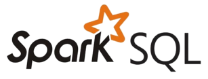


O Spark SQL faz parte do framework de Big Data Apache Spark, sendo utilizado no processamento de dados estruturados por meio de consultas SQL no conjunto de dados armazenados no Spark. Também é possível realizar processos como ETL sobre dados de diversos formatos como json, parquet, csv, entre outros.




###Criando mais variáveis

O objetivo é realizar uma transformação e processamento massivo nos dados da competição do Kaggle “Home Credit Default Risk” (https://www.kaggle.com/competitions/home-credit-default-risk/data), para enriquecer ainda mais os dados de treino da tabela application_train. Para isso, serão criadas diversas colunas combinando dados históricos transacionais da tabela bureau.csv.

- O foco não é criar um dashboard ou uma análise específica, mas combinar conceitos para criar variáveis massivamente para gerar mais poder preditivo para um modelo. 

- Foi assumido que os dados do kaggle estejam minimamente tratados para criar as variáveis

- Para entendimento das colunas, foram verificados os metadados que estão entre os arquivos .csv disponibilizados no Kaggle.



###Instalando o pyspark

In [1]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317145 sha256=c2547b53fd5ae5576a307daf37c462e15baf8fcdd46890f683b622b942be93e3
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark


###Mapeando o Google Drive, para possibilitar o acesso aos arquivos de leitura

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


###Etapas obrigatórias no pré-processamento de dados com Spark

Etapa 1: Importar a SparkSession para iniciar a sessão PySpark

In [3]:
from pyspark.sql import SparkSession

Etapa 2: Utilizar a função getOrCreate() para criar a sessão do Apache Spark

In [4]:
spark = SparkSession \
    .builder \
    .appName("Criando variáveis!") \
    .config('spark.ui.port', '4050') \
    .getOrCreate()

Etapa 3: Verificar se o objeto spark contém em um formato graphical

In [5]:
spark

###Lendo os arquivos de formado csv

- O dataframe df_colunas contém a descrição das colunas dos outros dfs

In [6]:
df_colunas = spark.read.csv("HomeCredit_columns_description.csv", header=True)

In [7]:
df_colunas.show()

+---+--------------------+--------------------+--------------------+--------------------+
|_c0|               Table|                 Row|         Description|             Special|
+---+--------------------+--------------------+--------------------+--------------------+
|  1|application_{trai...|          SK_ID_CURR|ID of loan in our...|                null|
|  2|application_{trai...|              TARGET|Target variable (...|                null|
|  5|application_{trai...|  NAME_CONTRACT_TYPE|Identification if...|                null|
|  6|application_{trai...|         CODE_GENDER|Gender of the client|                null|
|  7|application_{trai...|        FLAG_OWN_CAR|Flag if the clien...|                null|
|  8|application_{trai...|     FLAG_OWN_REALTY|Flag if client ow...|                null|
|  9|application_{trai...|        CNT_CHILDREN|Number of childre...|                null|
| 10|application_{trai...|    AMT_INCOME_TOTAL|Income of the client|                null|
| 11|appli

- O dataframe df_application_train contém os dados de treino

In [8]:
df_application_train = spark.read.csv('application_train.csv', header=True)

- O dataframe df_bureaus contém dados transacionais de saldos mensais dos créditos anteriores

In [9]:
df_bureau = spark.read.csv('criando_variaveis/bureau.csv', header=True)

####Criando Views Temporárias 

Para cada um dos dataframes, df_application_train e df_bureau, é necessário criar uma view temporária em memória para ser possível criar consultas em linguagem SQL


In [10]:
df_application_train.createOrReplaceTempView('application_train')
df_bureau.createOrReplaceTempView('bureau')

###Consulta spark.sql

- Lendo os dados da tabela application_train


In [ ]:
spark.sql("""
SELECT
*
FROM
application_train
LIMIT 20
""").show()

- Lendo os dados da tabela bureau

In [ ]:
spark.sql("""
SELECT
*
FROM
bureau
LIMIT 20
""").show()

- Contando a quantidade de linhas das tabelas application_train e bureau

In [13]:
spark.sql("""
SELECT
COUNT(SK_ID_CURR) AS Quantidade_SK_ID
FROM
application_train
""").show()

+----------------+
|Quantidade_SK_ID|
+----------------+
|          307511|
+----------------+



In [14]:
spark.sql("""
SELECT
Count(*) AS Quantidadede_Transacoes
FROM
bureau
""").show()

+-----------------------+
|Quantidadede_Transacoes|
+-----------------------+
|                1716428|
+-----------------------+



###Análise exploratória da chave SK_ID_CURR = '100002'

Pelo modelo entidade relacionamento (MER) tem-se que as tabelas application_train e bureau se relacionam pela chave 'SK_ID_CURR'.

- Lendo os dados do SK_ID_CURR = '100002' na tabela applicantion_train

In [ ]:
spark.sql("""
SELECT
*
FROM
application_train
WHERE SK_ID_CURR = '100002'
""").show()


- Lendo os dados do SK_ID_CURR = '100002' na tabela bureau

In [ ]:
spark.sql("""
SELECT
*
FROM
bureau
WHERE SK_ID_CURR = '100002'
""").show()


Através da vizualização da chave SK_ID_CURR = '100002' vemos que para um cadastro (tabela application_train) pode-se ter várias transações (tabela bureau). 


- Analisando os dados categóricos da tabela bureau, colunas:
  - CREDIT_ACTIVE
  - CREDIT_CURRENCY
  - CREDIT_TYPE

In [17]:
spark.sql("""
SELECT
SK_ID_CURR,
CREDIT_ACTIVE,
CREDIT_CURRENCY, 
CREDIT_TYPE
FROM
bureau
WHERE SK_ID_CURR = '100002'
""").show()

+----------+-------------+---------------+---------------+
|SK_ID_CURR|CREDIT_ACTIVE|CREDIT_CURRENCY|    CREDIT_TYPE|
+----------+-------------+---------------+---------------+
|    100002|       Closed|     currency 1|    Credit card|
|    100002|       Closed|     currency 1|    Credit card|
|    100002|       Closed|     currency 1|Consumer credit|
|    100002|       Closed|     currency 1|Consumer credit|
|    100002|       Closed|     currency 1|Consumer credit|
|    100002|       Active|     currency 1|    Credit card|
|    100002|       Active|     currency 1|Consumer credit|
|    100002|       Closed|     currency 1|    Credit card|
+----------+-------------+---------------+---------------+



Analisando a tabela acima vemos que cada coluna categórica possui domínios variados.

###Metodologia

- Como o foco principal é enriquecer a tabela de treino application_train com mais colunas, de modo que explique melhor as transações que determinado indivíduo fez, temos que agrupar as categorias em colunas.

- Para isso vamos criar colunas agregadas como:
  - SUM(CASE WHEN CREDIT_ACTIVE = 'Closed' THEN 1 ELSE 0 END) 
  
- A rotina acima cria uma coluna agregada que quando o crédito for igual a 'Closed' então conta como 1 senão é zero, e como está dentro de um SUM, cada vez que achar um 'Closed' vai somar 1. Com isso eu crio uma variável que pode ter vários créditos em situação 'Closed'.  Após isso, posso pegar esse dado e juntar com a tabela application_train, pois agora eu só tenho 1 linha para um único ID e não mais várias linhas.

- Com isso, podemos aplicar o máximo de conceitos de negócio, de combinação de conceitos e criar variáveis massivamente, ou seja, podemos criar um books de variáveis, com foco de aumentar o poder preditivo na parte de modelagem.


###Identificando todos domínios das variáveis categóricas da tabela 'bureau': 
  - CREDIT_ACTIVE
  - CREDIT_CURRENCY
  - CREDIT_TYPE

In [18]:
spark.sql("""
SELECT
CREDIT_ACTIVE, 
Count(*)
FROM
bureau
GROUP BY CREDIT_ACTIVE
ORDER BY Count(*)
""").show()

+-------------+--------+
|CREDIT_ACTIVE|count(1)|
+-------------+--------+
|     Bad debt|      21|
|         Sold|    6527|
|       Active|  630607|
|       Closed| 1079273|
+-------------+--------+



In [19]:
spark.sql("""
SELECT 
CREDIT_TYPE, 
Count(*)
FROM
bureau
GROUP BY
CREDIT_TYPE
ORDER BY Count(*)
""").show(truncate=False)

+--------------------------------------------+--------+
|CREDIT_TYPE                                 |count(1)|
+--------------------------------------------+--------+
|Mobile operator loan                        |1       |
|Interbank credit                            |1       |
|Loan for purchase of shares (margin lending)|4       |
|Loan for the purchase of equipment          |19      |
|Real estate loan                            |27      |
|Cash loan (non-earmarked)                   |56      |
|Loan for working capital replenishment      |469     |
|Unknown type of loan                        |555     |
|Another type of loan                        |1017    |
|Loan for business development               |1975    |
|Microloan                                   |12413   |
|Mortgage                                    |18391   |
|Car loan                                    |27690   |
|Credit card                                 |402195  |
|Consumer credit                             |12

In [20]:
spark.sql("""
SELECT
CREDIT_CURRENCY, 
Count(*)
FROM
bureau
GROUP BY CREDIT_CURRENCY
ORDER BY Count(*)
""").show()

+---------------+--------+
|CREDIT_CURRENCY|count(1)|
+---------------+--------+
|     currency 4|      10|
|     currency 3|     174|
|     currency 2|    1224|
|     currency 1| 1715020|
+---------------+--------+



###Transformando as variáveis categóricas em variáveis numéricas

- Agregando apenas as variáveis categóricas e seus domínios

In [21]:
df_bureau_cat = spark.sql("""
SELECT
  SK_ID_CURR,
  SUM(CASE WHEN CREDIT_ACTIVE = 'Closed' THEN 1 ELSE 0 END) AS qtd_credit_active_closed,
  SUM(CASE WHEN CREDIT_ACTIVE = 'Active' THEN 1 ELSE 0 END) AS qtd_credit_active_active,
  SUM(CASE WHEN CREDIT_ACTIVE = 'Bad debt' THEN 1 ELSE 0 END) AS qtd_credit_active_bad_debt,
  SUM(CASE WHEN CREDIT_ACTIVE = 'Sold' THEN 1 ELSE 0 END) AS qtd_credit_active_sold,
  SUM(CASE WHEN CREDIT_CURRENCY = 'currency 4' THEN 1 ELSE 0 END) AS qtd_credit_currency_4,
  SUM(CASE WHEN CREDIT_CURRENCY = 'currency 3' THEN 1 ELSE 0 END) AS qtd_credit_currency_3,
  SUM(CASE WHEN CREDIT_CURRENCY = 'currency 2' THEN 1 ELSE 0 END) AS qtd_credit_currency_2,
  SUM(CASE WHEN CREDIT_CURRENCY = 'currency 1' THEN 1 ELSE 0 END) AS qtd_credit_currency_1,
  SUM(CASE WHEN CREDIT_Type = 'Mobile operator loan' THEN 1 ELSE 0 END) AS qtd_credit_type_mobile_operator_loan,
  SUM(CASE WHEN CREDIT_Type = 'Interbank credit' THEN 1 ELSE 0 END) AS qtd_credit_type_interbank_credit,
  SUM(CASE WHEN CREDIT_Type = 'Loan for purchase of shares (margin lending)' THEN 1 ELSE 0 END) AS qtd_credit_type_loan_for_purchase_of_shares,
  SUM(CASE WHEN CREDIT_Type = 'Loan for the purchase of equipment' THEN 1 ELSE 0 END) AS qtd_credit_type_mobile_operator_loan_for_the_purchase_of_equipament,
  SUM(CASE WHEN CREDIT_Type = 'Real estate loan' THEN 1 ELSE 0 END) AS qtd_credit_type_real_estate_loan,
  SUM(CASE WHEN CREDIT_Type = 'Cash loan (non-earmarked)' THEN 1 ELSE 0 END) AS qtd_credit_type_cash_loan,
  SUM(CASE WHEN CREDIT_Type = 'Loan for working capital replenishment' THEN 1 ELSE 0 END) AS qtd_credit_type_loan_for_working_capital_replenishment,
  SUM(CASE WHEN CREDIT_Type = 'Unknown type of loan' THEN 1 ELSE 0 END) AS qtd_credit_type_unknown_type_of_loan,
  SUM(CASE WHEN CREDIT_Type = 'Another type of loan' THEN 1 ELSE 0 END) AS qtd_credit_type_another_type_of_loan,
  SUM(CASE WHEN CREDIT_Type = 'Loan for business development' THEN 1 ELSE 0 END) AS qtd_credit_type_loan_for_business_development,
  SUM(CASE WHEN CREDIT_Type = 'Microloan' THEN 1 ELSE 0 END) AS qtd_credit_type_microloan,
  SUM(CASE WHEN CREDIT_Type = 'Mortgage' THEN 1 ELSE 0 END) AS qtd_credit_type_mortgage,
  SUM(CASE WHEN CREDIT_Type = 'Car loan ' THEN 1 ELSE 0 END) AS qtd_credit_type_car_loan,
  SUM(CASE WHEN CREDIT_Type = 'Credit card' THEN 1 ELSE 0 END) AS qtd_credit_type_real_estate_loan,
  SUM(CASE WHEN CREDIT_Type = 'Consumer credit' THEN 1 ELSE 0 END) AS qtd_credit_type_real_estate_loan,
  MIN(CASE WHEN CREDIT_ACTIVE = 'Closed' THEN 1 ELSE 0 END) AS min_credit_active_closed,
  MIN(CASE WHEN CREDIT_ACTIVE = 'Active' THEN 1 ELSE 0 END) AS min_credit_active_active,
  MIN(CASE WHEN CREDIT_ACTIVE = 'Bad debt' THEN 1 ELSE 0 END) AS min_credit_active_bad_debt,
  MIN(CASE WHEN CREDIT_ACTIVE = 'Sold' THEN 1 ELSE 0 END) AS min_credit_active_sold,
  MIN(CASE WHEN CREDIT_CURRENCY = 'currency 4' THEN 1 ELSE 0 END) AS min_credit_currency_4,
  MIN(CASE WHEN CREDIT_CURRENCY = 'currency 3' THEN 1 ELSE 0 END) AS min_credit_currency_3,
  MIN(CASE WHEN CREDIT_CURRENCY = 'currency 2' THEN 1 ELSE 0 END) AS min_credit_currency_2,
  MIN(CASE WHEN CREDIT_CURRENCY = 'currency 1' THEN 1 ELSE 0 END) AS min_credit_currency_1,
  MIN(CASE WHEN CREDIT_Type = 'Mobile operator loan' THEN 1 ELSE 0 END) AS min_credit_type_mobile_operator_loan,
  MIN(CASE WHEN CREDIT_Type = 'Interbank credit' THEN 1 ELSE 0 END) AS min_credit_type_interbank_credit,
  MIN(CASE WHEN CREDIT_Type = 'Loan for purchase of shares (margin lending)' THEN 1 ELSE 0 END) AS min_credit_type_loan_for_purchase_of_shares,
  MIN(CASE WHEN CREDIT_Type = 'Loan for the purchase of equipment' THEN 1 ELSE 0 END) AS min_credit_type_mobile_operator_loan_for_the_purchase_of_equipament,
  MIN(CASE WHEN CREDIT_Type = 'Real estate loan' THEN 1 ELSE 0 END) AS min_credit_type_real_estate_loan,
  MIN(CASE WHEN CREDIT_Type = 'Cash loan (non-earmarked)' THEN 1 ELSE 0 END) AS min_credit_type_cash_loan,
  MIN(CASE WHEN CREDIT_Type = 'Loan for working capital replenishment' THEN 1 ELSE 0 END) AS min_credit_type_loan_for_working_capital_replenishment,
  MIN(CASE WHEN CREDIT_Type = 'Unknown type of loan' THEN 1 ELSE 0 END) AS min_credit_type_unknown_type_of_loan,
  MIN(CASE WHEN CREDIT_Type = 'Another type of loan' THEN 1 ELSE 0 END) AS min_credit_type_another_type_of_loan,
  MIN(CASE WHEN CREDIT_Type = 'Loan for business development' THEN 1 ELSE 0 END) AS min_credit_type_loan_for_business_development,
  MIN(CASE WHEN CREDIT_Type = 'Microloan' THEN 1 ELSE 0 END) AS min_credit_type_microloan,
  MIN(CASE WHEN CREDIT_Type = 'Mortgage' THEN 1 ELSE 0 END) AS min_credit_type_mortgage,
  MIN(CASE WHEN CREDIT_Type = 'Car loan ' THEN 1 ELSE 0 END) AS min_credit_type_car_loan,
  MIN(CASE WHEN CREDIT_Type = 'Credit card' THEN 1 ELSE 0 END) AS min_credit_type_real_estate_loan,
  MIN(CASE WHEN CREDIT_Type = 'Consumer credit' THEN 1 ELSE 0 END) AS min_credit_type_real_estate_loan,
  MAX(CASE WHEN CREDIT_ACTIVE = 'Closed' THEN 1 ELSE 0 END) AS max_credit_active_closed,
  MAX(CASE WHEN CREDIT_ACTIVE = 'Active' THEN 1 ELSE 0 END) AS max_credit_active_active,
  MAX(CASE WHEN CREDIT_ACTIVE = 'Bad debt' THEN 1 ELSE 0 END) AS max_credit_active_bad_debt,
  MAX(CASE WHEN CREDIT_ACTIVE = 'Sold' THEN 1 ELSE 0 END) AS max_credit_active_sold,
  MAX(CASE WHEN CREDIT_CURRENCY = 'currency 4' THEN 1 ELSE 0 END) AS max_credit_currency_4,
  MAX(CASE WHEN CREDIT_CURRENCY = 'currency 3' THEN 1 ELSE 0 END) AS max_credit_currency_3,
  MAX(CASE WHEN CREDIT_CURRENCY = 'currency 2' THEN 1 ELSE 0 END) AS max_credit_currency_2,
  MAX(CASE WHEN CREDIT_CURRENCY = 'currency 1' THEN 1 ELSE 0 END) AS max_credit_currency_1,
  MAX(CASE WHEN CREDIT_Type = 'Mobile operator loan' THEN 1 ELSE 0 END) AS max_credit_type_mobile_operator_loan,
  MAX(CASE WHEN CREDIT_Type = 'Interbank credit' THEN 1 ELSE 0 END) AS max_credit_type_interbank_credit,
  MAX(CASE WHEN CREDIT_Type = 'Loan for purchase of shares (margin lending)' THEN 1 ELSE 0 END) AS max_credit_type_loan_for_purchase_of_shares,
  MAX(CASE WHEN CREDIT_Type = 'Loan for the purchase of equipment' THEN 1 ELSE 0 END) AS max_credit_type_mobile_operator_loan_for_the_purchase_of_equipament,
  MAX(CASE WHEN CREDIT_Type = 'Real estate loan' THEN 1 ELSE 0 END) AS max_credit_type_real_estate_loan,
  MAX(CASE WHEN CREDIT_Type = 'Cash loan (non-earmarked)' THEN 1 ELSE 0 END) AS max_credit_type_cash_loan,
  MAX(CASE WHEN CREDIT_Type = 'Loan for working capital replenishment' THEN 1 ELSE 0 END) AS max_credit_type_loan_for_working_capital_replenishment,
  MAX(CASE WHEN CREDIT_Type = 'Unknown type of loan' THEN 1 ELSE 0 END) AS max_credit_type_unknown_type_of_loan,
  MAX(CASE WHEN CREDIT_Type = 'Another type of loan' THEN 1 ELSE 0 END) AS max_credit_type_another_type_of_loan,
  MAX(CASE WHEN CREDIT_Type = 'Loan for business development' THEN 1 ELSE 0 END) AS max_credit_type_loan_for_business_development,
  MAX(CASE WHEN CREDIT_Type = 'Microloan' THEN 1 ELSE 0 END) AS max_credit_type_microloan,
  MAX(CASE WHEN CREDIT_Type = 'Mortgage' THEN 1 ELSE 0 END) AS max_credit_type_mortgage,
  MAX(CASE WHEN CREDIT_Type = 'Car loan ' THEN 1 ELSE 0 END) AS max_credit_type_car_loan,
  MAX(CASE WHEN CREDIT_Type = 'Credit card' THEN 1 ELSE 0 END) AS max_credit_type_real_estate_loan,
  MAX(CASE WHEN CREDIT_Type = 'Consumer credit' THEN 1 ELSE 0 END) AS max_credit_type_real_estate_loan,
  AVG(CASE WHEN CREDIT_ACTIVE = 'Closed' THEN 1 ELSE 0 END) AS avg_credit_active_closed,
  AVG(CASE WHEN CREDIT_ACTIVE = 'Active' THEN 1 ELSE 0 END) AS avg_credit_active_active,
  AVG(CASE WHEN CREDIT_ACTIVE = 'Bad debt' THEN 1 ELSE 0 END) AS avg_credit_active_bad_debt,
  AVG(CASE WHEN CREDIT_ACTIVE = 'Sold' THEN 1 ELSE 0 END) AS avg_credit_active_sold,
  AVG(CASE WHEN CREDIT_CURRENCY = 'currency 4' THEN 1 ELSE 0 END) AS avg_credit_currency_4,
  AVG(CASE WHEN CREDIT_CURRENCY = 'currency 3' THEN 1 ELSE 0 END) AS avg_credit_currency_3,
  AVG(CASE WHEN CREDIT_CURRENCY = 'currency 2' THEN 1 ELSE 0 END) AS avg_credit_currency_2,
  AVG(CASE WHEN CREDIT_CURRENCY = 'currency 1' THEN 1 ELSE 0 END) AS avg_credit_currency_1,
  AVG(CASE WHEN CREDIT_Type = 'Mobile operator loan' THEN 1 ELSE 0 END) AS avg_credit_type_mobile_operator_loan,
  AVG(CASE WHEN CREDIT_Type = 'Interbank credit' THEN 1 ELSE 0 END) AS avg_credit_type_interbank_credit,
  AVG(CASE WHEN CREDIT_Type = 'Loan for purchase of shares (margin lending)' THEN 1 ELSE 0 END) AS avg_credit_type_loan_for_purchase_of_shares,
  AVG(CASE WHEN CREDIT_Type = 'Loan for the purchase of equipment' THEN 1 ELSE 0 END) AS avg_credit_type_mobile_operator_loan_for_the_purchase_of_equipament,
  AVG(CASE WHEN CREDIT_Type = 'Real estate loan' THEN 1 ELSE 0 END) AS avg_credit_type_real_estate_loan,
  AVG(CASE WHEN CREDIT_Type = 'Cash loan (non-earmarked)' THEN 1 ELSE 0 END) AS avg_credit_type_cash_loan,
  AVG(CASE WHEN CREDIT_Type = 'Loan for working capital replenishment' THEN 1 ELSE 0 END) AS avg_credit_type_loan_for_working_capital_replenishment,
  AVG(CASE WHEN CREDIT_Type = 'Unknown type of loan' THEN 1 ELSE 0 END) AS avg_credit_type_unknown_type_of_loan,
  AVG(CASE WHEN CREDIT_Type = 'Another type of loan' THEN 1 ELSE 0 END) AS avg_credit_type_another_type_of_loan,
  AVG(CASE WHEN CREDIT_Type = 'Loan for business development' THEN 1 ELSE 0 END) AS avg_credit_type_loan_for_business_development,
  AVG(CASE WHEN CREDIT_Type = 'Microloan' THEN 1 ELSE 0 END) AS avg_credit_type_microloan,
  AVG(CASE WHEN CREDIT_Type = 'Mortgage' THEN 1 ELSE 0 END) AS avg_credit_type_mortgage,
  AVG(CASE WHEN CREDIT_Type = 'Car loan ' THEN 1 ELSE 0 END) AS avg_credit_type_car_loan,
  AVG(CASE WHEN CREDIT_Type = 'Credit card' THEN 1 ELSE 0 END) AS avg_credit_type_real_estate_loan,
  AVG(CASE WHEN CREDIT_Type = 'Consumer credit' THEN 1 ELSE 0 END) AS avg_credit_type_real_estate_loan
FROM
  bureau
GROUP BY
  SK_ID_CURR
""")

Após criar o dataframe df_bureau_cat somente com agregações de variáveis categóricas, podemos criar outros dataframes com agregações entre as variáveis categóricas e numéricas. As variáveis numéricas da tabela bureau são:

- AMT_CREDIT_MAX_OVERDUE
- CNT_CREDIT_PROLONG
- AMT_CREDIT_SUM
- AMT_CREDIT_SUM_DEBT
- AMT_CREDIT_SUM_LIMIT
- AMT_CREDIT_SUM_OVERDUE
- AMT_ANNUITY

OBS: Para automatizar a criação de cada linha de agregação vamos desenvolver uma rotina que gera o texto de agregação. Após, basta susbstiruir na requesição SQL.

###Agregando cada variável numérica a cada variável categórica e seus domínios


1- Considerando a variável categórica CREDIT_ACTIVE


In [22]:
# Criando as agregações

agg = ['SUM', 'MIN', 'MAX', 'AVG']

# Criando a variável categórica

cat = ['CREDIT_ACTIVE']

# Criando os domínios

dominios_cat = ['Active', 'Closed', 'Bad debt', 'Sold']

# Criando variável numérica

var_num = ['AMT_CREDIT_MAX_OVERDUE', 'CNT_CREDIT_PROLONG', 'AMT_CREDIT_SUM', \
           'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_LIMIT', \
           'AMT_CREDIT_SUM_OVERDUE', 'AMT_ANNUITY']

In [23]:
# Criando uma rotina que gera o texto da função de agregação

for ag in agg:
  for cate in cat:
    for dominio in dominios_cat:
      for var_n in var_num:
        print(ag +'(CASE WHEN ' + cate + '= ' + "'" + dominio + "'" + " THEN " + var_n + " ELSE 0 END) AS " + ag + "_" + cate + "_" + dominio.replace(" ", "_") + "_" + var_n + ',')

    #SUM(CASE WHEN CREDIT_Type = 'Real estate loan' THEN 1 ELSE 0 END) AS qtd_credit_type_real_estate_loan

SUM(CASE WHEN CREDIT_ACTIVE= 'Active' THEN AMT_CREDIT_MAX_OVERDUE ELSE 0 END) AS SUM_CREDIT_ACTIVE_Active_AMT_CREDIT_MAX_OVERDUE,
SUM(CASE WHEN CREDIT_ACTIVE= 'Active' THEN CNT_CREDIT_PROLONG ELSE 0 END) AS SUM_CREDIT_ACTIVE_Active_CNT_CREDIT_PROLONG,
SUM(CASE WHEN CREDIT_ACTIVE= 'Active' THEN AMT_CREDIT_SUM ELSE 0 END) AS SUM_CREDIT_ACTIVE_Active_AMT_CREDIT_SUM,
SUM(CASE WHEN CREDIT_ACTIVE= 'Active' THEN AMT_CREDIT_SUM_DEBT ELSE 0 END) AS SUM_CREDIT_ACTIVE_Active_AMT_CREDIT_SUM_DEBT,
SUM(CASE WHEN CREDIT_ACTIVE= 'Active' THEN AMT_CREDIT_SUM_LIMIT ELSE 0 END) AS SUM_CREDIT_ACTIVE_Active_AMT_CREDIT_SUM_LIMIT,
SUM(CASE WHEN CREDIT_ACTIVE= 'Active' THEN AMT_CREDIT_SUM_OVERDUE ELSE 0 END) AS SUM_CREDIT_ACTIVE_Active_AMT_CREDIT_SUM_OVERDUE,
SUM(CASE WHEN CREDIT_ACTIVE= 'Active' THEN AMT_ANNUITY ELSE 0 END) AS SUM_CREDIT_ACTIVE_Active_AMT_ANNUITY,
SUM(CASE WHEN CREDIT_ACTIVE= 'Closed' THEN AMT_CREDIT_MAX_OVERDUE ELSE 0 END) AS SUM_CREDIT_ACTIVE_Closed_AMT_CREDIT_MAX_OVERDUE,
SUM(CASE WHEN CR

- Criando o dataframe df_bureau_credit_active_num

In [24]:
df_bureau_credit_active_num = spark.sql("""
SELECT
  SK_ID_CURR,
  SUM(CASE WHEN CREDIT_ACTIVE= 'Active' THEN AMT_CREDIT_MAX_OVERDUE ELSE 0 END) AS SUM_CREDIT_ACTIVE_Active_AMT_CREDIT_MAX_OVERDUE,
SUM(CASE WHEN CREDIT_ACTIVE= 'Active' THEN CNT_CREDIT_PROLONG ELSE 0 END) AS SUM_CREDIT_ACTIVE_Active_CNT_CREDIT_PROLONG,
SUM(CASE WHEN CREDIT_ACTIVE= 'Active' THEN AMT_CREDIT_SUM ELSE 0 END) AS SUM_CREDIT_ACTIVE_Active_AMT_CREDIT_SUM,
SUM(CASE WHEN CREDIT_ACTIVE= 'Active' THEN AMT_CREDIT_SUM_DEBT ELSE 0 END) AS SUM_CREDIT_ACTIVE_Active_AMT_CREDIT_SUM_DEBT,
SUM(CASE WHEN CREDIT_ACTIVE= 'Active' THEN AMT_CREDIT_SUM_LIMIT ELSE 0 END) AS SUM_CREDIT_ACTIVE_Active_AMT_CREDIT_SUM_LIMIT,
SUM(CASE WHEN CREDIT_ACTIVE= 'Active' THEN AMT_CREDIT_SUM_OVERDUE ELSE 0 END) AS SUM_CREDIT_ACTIVE_Active_AMT_CREDIT_SUM_OVERDUE,
SUM(CASE WHEN CREDIT_ACTIVE= 'Active' THEN AMT_ANNUITY ELSE 0 END) AS SUM_CREDIT_ACTIVE_Active_AMT_ANNUITY,
SUM(CASE WHEN CREDIT_ACTIVE= 'Closed' THEN AMT_CREDIT_MAX_OVERDUE ELSE 0 END) AS SUM_CREDIT_ACTIVE_Closed_AMT_CREDIT_MAX_OVERDUE,
SUM(CASE WHEN CREDIT_ACTIVE= 'Closed' THEN CNT_CREDIT_PROLONG ELSE 0 END) AS SUM_CREDIT_ACTIVE_Closed_CNT_CREDIT_PROLONG,
SUM(CASE WHEN CREDIT_ACTIVE= 'Closed' THEN AMT_CREDIT_SUM ELSE 0 END) AS SUM_CREDIT_ACTIVE_Closed_AMT_CREDIT_SUM,
SUM(CASE WHEN CREDIT_ACTIVE= 'Closed' THEN AMT_CREDIT_SUM_DEBT ELSE 0 END) AS SUM_CREDIT_ACTIVE_Closed_AMT_CREDIT_SUM_DEBT,
SUM(CASE WHEN CREDIT_ACTIVE= 'Closed' THEN AMT_CREDIT_SUM_LIMIT ELSE 0 END) AS SUM_CREDIT_ACTIVE_Closed_AMT_CREDIT_SUM_LIMIT,
SUM(CASE WHEN CREDIT_ACTIVE= 'Closed' THEN AMT_CREDIT_SUM_OVERDUE ELSE 0 END) AS SUM_CREDIT_ACTIVE_Closed_AMT_CREDIT_SUM_OVERDUE,
SUM(CASE WHEN CREDIT_ACTIVE= 'Closed' THEN AMT_ANNUITY ELSE 0 END) AS SUM_CREDIT_ACTIVE_Closed_AMT_ANNUITY,
SUM(CASE WHEN CREDIT_ACTIVE= 'Bad debt' THEN AMT_CREDIT_MAX_OVERDUE ELSE 0 END) AS SUM_CREDIT_ACTIVE_Bad_debt_AMT_CREDIT_MAX_OVERDUE,
SUM(CASE WHEN CREDIT_ACTIVE= 'Bad debt' THEN CNT_CREDIT_PROLONG ELSE 0 END) AS SUM_CREDIT_ACTIVE_Bad_debt_CNT_CREDIT_PROLONG,
SUM(CASE WHEN CREDIT_ACTIVE= 'Bad debt' THEN AMT_CREDIT_SUM ELSE 0 END) AS SUM_CREDIT_ACTIVE_Bad_debt_AMT_CREDIT_SUM,
SUM(CASE WHEN CREDIT_ACTIVE= 'Bad debt' THEN AMT_CREDIT_SUM_DEBT ELSE 0 END) AS SUM_CREDIT_ACTIVE_Bad_debt_AMT_CREDIT_SUM_DEBT,
SUM(CASE WHEN CREDIT_ACTIVE= 'Bad debt' THEN AMT_CREDIT_SUM_LIMIT ELSE 0 END) AS SUM_CREDIT_ACTIVE_Bad_debt_AMT_CREDIT_SUM_LIMIT,
SUM(CASE WHEN CREDIT_ACTIVE= 'Bad debt' THEN AMT_CREDIT_SUM_OVERDUE ELSE 0 END) AS SUM_CREDIT_ACTIVE_Bad_debt_AMT_CREDIT_SUM_OVERDUE,
SUM(CASE WHEN CREDIT_ACTIVE= 'Bad debt' THEN AMT_ANNUITY ELSE 0 END) AS SUM_CREDIT_ACTIVE_Bad_debt_AMT_ANNUITY,
SUM(CASE WHEN CREDIT_ACTIVE= 'Sold' THEN AMT_CREDIT_MAX_OVERDUE ELSE 0 END) AS SUM_CREDIT_ACTIVE_Sold_AMT_CREDIT_MAX_OVERDUE,
SUM(CASE WHEN CREDIT_ACTIVE= 'Sold' THEN CNT_CREDIT_PROLONG ELSE 0 END) AS SUM_CREDIT_ACTIVE_Sold_CNT_CREDIT_PROLONG,
SUM(CASE WHEN CREDIT_ACTIVE= 'Sold' THEN AMT_CREDIT_SUM ELSE 0 END) AS SUM_CREDIT_ACTIVE_Sold_AMT_CREDIT_SUM,
SUM(CASE WHEN CREDIT_ACTIVE= 'Sold' THEN AMT_CREDIT_SUM_DEBT ELSE 0 END) AS SUM_CREDIT_ACTIVE_Sold_AMT_CREDIT_SUM_DEBT,
SUM(CASE WHEN CREDIT_ACTIVE= 'Sold' THEN AMT_CREDIT_SUM_LIMIT ELSE 0 END) AS SUM_CREDIT_ACTIVE_Sold_AMT_CREDIT_SUM_LIMIT,
SUM(CASE WHEN CREDIT_ACTIVE= 'Sold' THEN AMT_CREDIT_SUM_OVERDUE ELSE 0 END) AS SUM_CREDIT_ACTIVE_Sold_AMT_CREDIT_SUM_OVERDUE,
SUM(CASE WHEN CREDIT_ACTIVE= 'Sold' THEN AMT_ANNUITY ELSE 0 END) AS SUM_CREDIT_ACTIVE_Sold_AMT_ANNUITY,
MIN(CASE WHEN CREDIT_ACTIVE= 'Active' THEN AMT_CREDIT_MAX_OVERDUE ELSE 0 END) AS MIN_CREDIT_ACTIVE_Active_AMT_CREDIT_MAX_OVERDUE,
MIN(CASE WHEN CREDIT_ACTIVE= 'Active' THEN CNT_CREDIT_PROLONG ELSE 0 END) AS MIN_CREDIT_ACTIVE_Active_CNT_CREDIT_PROLONG,
MIN(CASE WHEN CREDIT_ACTIVE= 'Active' THEN AMT_CREDIT_SUM ELSE 0 END) AS MIN_CREDIT_ACTIVE_Active_AMT_CREDIT_SUM,
MIN(CASE WHEN CREDIT_ACTIVE= 'Active' THEN AMT_CREDIT_SUM_DEBT ELSE 0 END) AS MIN_CREDIT_ACTIVE_Active_AMT_CREDIT_SUM_DEBT,
MIN(CASE WHEN CREDIT_ACTIVE= 'Active' THEN AMT_CREDIT_SUM_LIMIT ELSE 0 END) AS MIN_CREDIT_ACTIVE_Active_AMT_CREDIT_SUM_LIMIT,
MIN(CASE WHEN CREDIT_ACTIVE= 'Active' THEN AMT_CREDIT_SUM_OVERDUE ELSE 0 END) AS MIN_CREDIT_ACTIVE_Active_AMT_CREDIT_SUM_OVERDUE,
MIN(CASE WHEN CREDIT_ACTIVE= 'Active' THEN AMT_ANNUITY ELSE 0 END) AS MIN_CREDIT_ACTIVE_Active_AMT_ANNUITY,
MIN(CASE WHEN CREDIT_ACTIVE= 'Closed' THEN AMT_CREDIT_MAX_OVERDUE ELSE 0 END) AS MIN_CREDIT_ACTIVE_Closed_AMT_CREDIT_MAX_OVERDUE,
MIN(CASE WHEN CREDIT_ACTIVE= 'Closed' THEN CNT_CREDIT_PROLONG ELSE 0 END) AS MIN_CREDIT_ACTIVE_Closed_CNT_CREDIT_PROLONG,
MIN(CASE WHEN CREDIT_ACTIVE= 'Closed' THEN AMT_CREDIT_SUM ELSE 0 END) AS MIN_CREDIT_ACTIVE_Closed_AMT_CREDIT_SUM,
MIN(CASE WHEN CREDIT_ACTIVE= 'Closed' THEN AMT_CREDIT_SUM_DEBT ELSE 0 END) AS MIN_CREDIT_ACTIVE_Closed_AMT_CREDIT_SUM_DEBT,
MIN(CASE WHEN CREDIT_ACTIVE= 'Closed' THEN AMT_CREDIT_SUM_LIMIT ELSE 0 END) AS MIN_CREDIT_ACTIVE_Closed_AMT_CREDIT_SUM_LIMIT,
MIN(CASE WHEN CREDIT_ACTIVE= 'Closed' THEN AMT_CREDIT_SUM_OVERDUE ELSE 0 END) AS MIN_CREDIT_ACTIVE_Closed_AMT_CREDIT_SUM_OVERDUE,
MIN(CASE WHEN CREDIT_ACTIVE= 'Closed' THEN AMT_ANNUITY ELSE 0 END) AS MIN_CREDIT_ACTIVE_Closed_AMT_ANNUITY,
MIN(CASE WHEN CREDIT_ACTIVE= 'Bad debt' THEN AMT_CREDIT_MAX_OVERDUE ELSE 0 END) AS MIN_CREDIT_ACTIVE_Bad_debt_AMT_CREDIT_MAX_OVERDUE,
MIN(CASE WHEN CREDIT_ACTIVE= 'Bad debt' THEN CNT_CREDIT_PROLONG ELSE 0 END) AS MIN_CREDIT_ACTIVE_Bad_debt_CNT_CREDIT_PROLONG,
MIN(CASE WHEN CREDIT_ACTIVE= 'Bad debt' THEN AMT_CREDIT_SUM ELSE 0 END) AS MIN_CREDIT_ACTIVE_Bad_debt_AMT_CREDIT_SUM,
MIN(CASE WHEN CREDIT_ACTIVE= 'Bad debt' THEN AMT_CREDIT_SUM_DEBT ELSE 0 END) AS MIN_CREDIT_ACTIVE_Bad_debt_AMT_CREDIT_SUM_DEBT,
MIN(CASE WHEN CREDIT_ACTIVE= 'Bad debt' THEN AMT_CREDIT_SUM_LIMIT ELSE 0 END) AS MIN_CREDIT_ACTIVE_Bad_debt_AMT_CREDIT_SUM_LIMIT,
MIN(CASE WHEN CREDIT_ACTIVE= 'Bad debt' THEN AMT_CREDIT_SUM_OVERDUE ELSE 0 END) AS MIN_CREDIT_ACTIVE_Bad_debt_AMT_CREDIT_SUM_OVERDUE,
MIN(CASE WHEN CREDIT_ACTIVE= 'Bad debt' THEN AMT_ANNUITY ELSE 0 END) AS MIN_CREDIT_ACTIVE_Bad_debt_AMT_ANNUITY,
MIN(CASE WHEN CREDIT_ACTIVE= 'Sold' THEN AMT_CREDIT_MAX_OVERDUE ELSE 0 END) AS MIN_CREDIT_ACTIVE_Sold_AMT_CREDIT_MAX_OVERDUE,
MIN(CASE WHEN CREDIT_ACTIVE= 'Sold' THEN CNT_CREDIT_PROLONG ELSE 0 END) AS MIN_CREDIT_ACTIVE_Sold_CNT_CREDIT_PROLONG,
MIN(CASE WHEN CREDIT_ACTIVE= 'Sold' THEN AMT_CREDIT_SUM ELSE 0 END) AS MIN_CREDIT_ACTIVE_Sold_AMT_CREDIT_SUM,
MIN(CASE WHEN CREDIT_ACTIVE= 'Sold' THEN AMT_CREDIT_SUM_DEBT ELSE 0 END) AS MIN_CREDIT_ACTIVE_Sold_AMT_CREDIT_SUM_DEBT,
MIN(CASE WHEN CREDIT_ACTIVE= 'Sold' THEN AMT_CREDIT_SUM_LIMIT ELSE 0 END) AS MIN_CREDIT_ACTIVE_Sold_AMT_CREDIT_SUM_LIMIT,
MIN(CASE WHEN CREDIT_ACTIVE= 'Sold' THEN AMT_CREDIT_SUM_OVERDUE ELSE 0 END) AS MIN_CREDIT_ACTIVE_Sold_AMT_CREDIT_SUM_OVERDUE,
MIN(CASE WHEN CREDIT_ACTIVE= 'Sold' THEN AMT_ANNUITY ELSE 0 END) AS MIN_CREDIT_ACTIVE_Sold_AMT_ANNUITY,
MAX(CASE WHEN CREDIT_ACTIVE= 'Active' THEN AMT_CREDIT_MAX_OVERDUE ELSE 0 END) AS MAX_CREDIT_ACTIVE_Active_AMT_CREDIT_MAX_OVERDUE,
MAX(CASE WHEN CREDIT_ACTIVE= 'Active' THEN CNT_CREDIT_PROLONG ELSE 0 END) AS MAX_CREDIT_ACTIVE_Active_CNT_CREDIT_PROLONG,
MAX(CASE WHEN CREDIT_ACTIVE= 'Active' THEN AMT_CREDIT_SUM ELSE 0 END) AS MAX_CREDIT_ACTIVE_Active_AMT_CREDIT_SUM,
MAX(CASE WHEN CREDIT_ACTIVE= 'Active' THEN AMT_CREDIT_SUM_DEBT ELSE 0 END) AS MAX_CREDIT_ACTIVE_Active_AMT_CREDIT_SUM_DEBT,
MAX(CASE WHEN CREDIT_ACTIVE= 'Active' THEN AMT_CREDIT_SUM_LIMIT ELSE 0 END) AS MAX_CREDIT_ACTIVE_Active_AMT_CREDIT_SUM_LIMIT,
MAX(CASE WHEN CREDIT_ACTIVE= 'Active' THEN AMT_CREDIT_SUM_OVERDUE ELSE 0 END) AS MAX_CREDIT_ACTIVE_Active_AMT_CREDIT_SUM_OVERDUE,
MAX(CASE WHEN CREDIT_ACTIVE= 'Active' THEN AMT_ANNUITY ELSE 0 END) AS MAX_CREDIT_ACTIVE_Active_AMT_ANNUITY,
MAX(CASE WHEN CREDIT_ACTIVE= 'Closed' THEN AMT_CREDIT_MAX_OVERDUE ELSE 0 END) AS MAX_CREDIT_ACTIVE_Closed_AMT_CREDIT_MAX_OVERDUE,
MAX(CASE WHEN CREDIT_ACTIVE= 'Closed' THEN CNT_CREDIT_PROLONG ELSE 0 END) AS MAX_CREDIT_ACTIVE_Closed_CNT_CREDIT_PROLONG,
MAX(CASE WHEN CREDIT_ACTIVE= 'Closed' THEN AMT_CREDIT_SUM ELSE 0 END) AS MAX_CREDIT_ACTIVE_Closed_AMT_CREDIT_SUM,
MAX(CASE WHEN CREDIT_ACTIVE= 'Closed' THEN AMT_CREDIT_SUM_DEBT ELSE 0 END) AS MAX_CREDIT_ACTIVE_Closed_AMT_CREDIT_SUM_DEBT,
MAX(CASE WHEN CREDIT_ACTIVE= 'Closed' THEN AMT_CREDIT_SUM_LIMIT ELSE 0 END) AS MAX_CREDIT_ACTIVE_Closed_AMT_CREDIT_SUM_LIMIT,
MAX(CASE WHEN CREDIT_ACTIVE= 'Closed' THEN AMT_CREDIT_SUM_OVERDUE ELSE 0 END) AS MAX_CREDIT_ACTIVE_Closed_AMT_CREDIT_SUM_OVERDUE,
MAX(CASE WHEN CREDIT_ACTIVE= 'Closed' THEN AMT_ANNUITY ELSE 0 END) AS MAX_CREDIT_ACTIVE_Closed_AMT_ANNUITY,
MAX(CASE WHEN CREDIT_ACTIVE= 'Bad debt' THEN AMT_CREDIT_MAX_OVERDUE ELSE 0 END) AS MAX_CREDIT_ACTIVE_Bad_debt_AMT_CREDIT_MAX_OVERDUE,
MAX(CASE WHEN CREDIT_ACTIVE= 'Bad debt' THEN CNT_CREDIT_PROLONG ELSE 0 END) AS MAX_CREDIT_ACTIVE_Bad_debt_CNT_CREDIT_PROLONG,
MAX(CASE WHEN CREDIT_ACTIVE= 'Bad debt' THEN AMT_CREDIT_SUM ELSE 0 END) AS MAX_CREDIT_ACTIVE_Bad_debt_AMT_CREDIT_SUM,
MAX(CASE WHEN CREDIT_ACTIVE= 'Bad debt' THEN AMT_CREDIT_SUM_DEBT ELSE 0 END) AS MAX_CREDIT_ACTIVE_Bad_debt_AMT_CREDIT_SUM_DEBT,
MAX(CASE WHEN CREDIT_ACTIVE= 'Bad debt' THEN AMT_CREDIT_SUM_LIMIT ELSE 0 END) AS MAX_CREDIT_ACTIVE_Bad_debt_AMT_CREDIT_SUM_LIMIT,
MAX(CASE WHEN CREDIT_ACTIVE= 'Bad debt' THEN AMT_CREDIT_SUM_OVERDUE ELSE 0 END) AS MAX_CREDIT_ACTIVE_Bad_debt_AMT_CREDIT_SUM_OVERDUE,
MAX(CASE WHEN CREDIT_ACTIVE= 'Bad debt' THEN AMT_ANNUITY ELSE 0 END) AS MAX_CREDIT_ACTIVE_Bad_debt_AMT_ANNUITY,
MAX(CASE WHEN CREDIT_ACTIVE= 'Sold' THEN AMT_CREDIT_MAX_OVERDUE ELSE 0 END) AS MAX_CREDIT_ACTIVE_Sold_AMT_CREDIT_MAX_OVERDUE,
MAX(CASE WHEN CREDIT_ACTIVE= 'Sold' THEN CNT_CREDIT_PROLONG ELSE 0 END) AS MAX_CREDIT_ACTIVE_Sold_CNT_CREDIT_PROLONG,
MAX(CASE WHEN CREDIT_ACTIVE= 'Sold' THEN AMT_CREDIT_SUM ELSE 0 END) AS MAX_CREDIT_ACTIVE_Sold_AMT_CREDIT_SUM,
MAX(CASE WHEN CREDIT_ACTIVE= 'Sold' THEN AMT_CREDIT_SUM_DEBT ELSE 0 END) AS MAX_CREDIT_ACTIVE_Sold_AMT_CREDIT_SUM_DEBT,
MAX(CASE WHEN CREDIT_ACTIVE= 'Sold' THEN AMT_CREDIT_SUM_LIMIT ELSE 0 END) AS MAX_CREDIT_ACTIVE_Sold_AMT_CREDIT_SUM_LIMIT,
MAX(CASE WHEN CREDIT_ACTIVE= 'Sold' THEN AMT_CREDIT_SUM_OVERDUE ELSE 0 END) AS MAX_CREDIT_ACTIVE_Sold_AMT_CREDIT_SUM_OVERDUE,
MAX(CASE WHEN CREDIT_ACTIVE= 'Sold' THEN AMT_ANNUITY ELSE 0 END) AS MAX_CREDIT_ACTIVE_Sold_AMT_ANNUITY,
AVG(CASE WHEN CREDIT_ACTIVE= 'Active' THEN AMT_CREDIT_MAX_OVERDUE ELSE 0 END) AS AVG_CREDIT_ACTIVE_Active_AMT_CREDIT_MAX_OVERDUE,
AVG(CASE WHEN CREDIT_ACTIVE= 'Active' THEN CNT_CREDIT_PROLONG ELSE 0 END) AS AVG_CREDIT_ACTIVE_Active_CNT_CREDIT_PROLONG,
AVG(CASE WHEN CREDIT_ACTIVE= 'Active' THEN AMT_CREDIT_SUM ELSE 0 END) AS AVG_CREDIT_ACTIVE_Active_AMT_CREDIT_SUM,
AVG(CASE WHEN CREDIT_ACTIVE= 'Active' THEN AMT_CREDIT_SUM_DEBT ELSE 0 END) AS AVG_CREDIT_ACTIVE_Active_AMT_CREDIT_SUM_DEBT,
AVG(CASE WHEN CREDIT_ACTIVE= 'Active' THEN AMT_CREDIT_SUM_LIMIT ELSE 0 END) AS AVG_CREDIT_ACTIVE_Active_AMT_CREDIT_SUM_LIMIT,
AVG(CASE WHEN CREDIT_ACTIVE= 'Active' THEN AMT_CREDIT_SUM_OVERDUE ELSE 0 END) AS AVG_CREDIT_ACTIVE_Active_AMT_CREDIT_SUM_OVERDUE,
AVG(CASE WHEN CREDIT_ACTIVE= 'Active' THEN AMT_ANNUITY ELSE 0 END) AS AVG_CREDIT_ACTIVE_Active_AMT_ANNUITY,
AVG(CASE WHEN CREDIT_ACTIVE= 'Closed' THEN AMT_CREDIT_MAX_OVERDUE ELSE 0 END) AS AVG_CREDIT_ACTIVE_Closed_AMT_CREDIT_MAX_OVERDUE,
AVG(CASE WHEN CREDIT_ACTIVE= 'Closed' THEN CNT_CREDIT_PROLONG ELSE 0 END) AS AVG_CREDIT_ACTIVE_Closed_CNT_CREDIT_PROLONG,
AVG(CASE WHEN CREDIT_ACTIVE= 'Closed' THEN AMT_CREDIT_SUM ELSE 0 END) AS AVG_CREDIT_ACTIVE_Closed_AMT_CREDIT_SUM,
AVG(CASE WHEN CREDIT_ACTIVE= 'Closed' THEN AMT_CREDIT_SUM_DEBT ELSE 0 END) AS AVG_CREDIT_ACTIVE_Closed_AMT_CREDIT_SUM_DEBT,
AVG(CASE WHEN CREDIT_ACTIVE= 'Closed' THEN AMT_CREDIT_SUM_LIMIT ELSE 0 END) AS AVG_CREDIT_ACTIVE_Closed_AMT_CREDIT_SUM_LIMIT,
AVG(CASE WHEN CREDIT_ACTIVE= 'Closed' THEN AMT_CREDIT_SUM_OVERDUE ELSE 0 END) AS AVG_CREDIT_ACTIVE_Closed_AMT_CREDIT_SUM_OVERDUE,
AVG(CASE WHEN CREDIT_ACTIVE= 'Closed' THEN AMT_ANNUITY ELSE 0 END) AS AVG_CREDIT_ACTIVE_Closed_AMT_ANNUITY,
AVG(CASE WHEN CREDIT_ACTIVE= 'Bad debt' THEN AMT_CREDIT_MAX_OVERDUE ELSE 0 END) AS AVG_CREDIT_ACTIVE_Bad_debt_AMT_CREDIT_MAX_OVERDUE,
AVG(CASE WHEN CREDIT_ACTIVE= 'Bad debt' THEN CNT_CREDIT_PROLONG ELSE 0 END) AS AVG_CREDIT_ACTIVE_Bad_debt_CNT_CREDIT_PROLONG,
AVG(CASE WHEN CREDIT_ACTIVE= 'Bad debt' THEN AMT_CREDIT_SUM ELSE 0 END) AS AVG_CREDIT_ACTIVE_Bad_debt_AMT_CREDIT_SUM,
AVG(CASE WHEN CREDIT_ACTIVE= 'Bad debt' THEN AMT_CREDIT_SUM_DEBT ELSE 0 END) AS AVG_CREDIT_ACTIVE_Bad_debt_AMT_CREDIT_SUM_DEBT,
AVG(CASE WHEN CREDIT_ACTIVE= 'Bad debt' THEN AMT_CREDIT_SUM_LIMIT ELSE 0 END) AS AVG_CREDIT_ACTIVE_Bad_debt_AMT_CREDIT_SUM_LIMIT,
AVG(CASE WHEN CREDIT_ACTIVE= 'Bad debt' THEN AMT_CREDIT_SUM_OVERDUE ELSE 0 END) AS AVG_CREDIT_ACTIVE_Bad_debt_AMT_CREDIT_SUM_OVERDUE,
AVG(CASE WHEN CREDIT_ACTIVE= 'Bad debt' THEN AMT_ANNUITY ELSE 0 END) AS AVG_CREDIT_ACTIVE_Bad_debt_AMT_ANNUITY,
AVG(CASE WHEN CREDIT_ACTIVE= 'Sold' THEN AMT_CREDIT_MAX_OVERDUE ELSE 0 END) AS AVG_CREDIT_ACTIVE_Sold_AMT_CREDIT_MAX_OVERDUE,
AVG(CASE WHEN CREDIT_ACTIVE= 'Sold' THEN CNT_CREDIT_PROLONG ELSE 0 END) AS AVG_CREDIT_ACTIVE_Sold_CNT_CREDIT_PROLONG,
AVG(CASE WHEN CREDIT_ACTIVE= 'Sold' THEN AMT_CREDIT_SUM ELSE 0 END) AS AVG_CREDIT_ACTIVE_Sold_AMT_CREDIT_SUM,
AVG(CASE WHEN CREDIT_ACTIVE= 'Sold' THEN AMT_CREDIT_SUM_DEBT ELSE 0 END) AS AVG_CREDIT_ACTIVE_Sold_AMT_CREDIT_SUM_DEBT,
AVG(CASE WHEN CREDIT_ACTIVE= 'Sold' THEN AMT_CREDIT_SUM_LIMIT ELSE 0 END) AS AVG_CREDIT_ACTIVE_Sold_AMT_CREDIT_SUM_LIMIT,
AVG(CASE WHEN CREDIT_ACTIVE= 'Sold' THEN AMT_CREDIT_SUM_OVERDUE ELSE 0 END) AS AVG_CREDIT_ACTIVE_Sold_AMT_CREDIT_SUM_OVERDUE,
AVG(CASE WHEN CREDIT_ACTIVE= 'Sold' THEN AMT_ANNUITY ELSE 0 END) AS AVG_CREDIT_ACTIVE_Sold_AMT_ANNUITY
FROM
  bureau
GROUP BY
  SK_ID_CURR
""")

2- Considerando a variável categórica CREDIT_CURRENCY

In [25]:
# Criando as agregações

agg = ['SUM', 'MIN', 'MAX', 'AVG']

# Criando a variável categórica

cat = ['CREDIT_CURRENCY']

# Criando os domínios

dominios_cat = ['currency 4', 'currency 3', 'currency 2', 'currency 1']

# Criando a variável numérica

var_num = ['AMT_CREDIT_MAX_OVERDUE', 'CNT_CREDIT_PROLONG', 'AMT_CREDIT_SUM', \
           'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_LIMIT', \
           'AMT_CREDIT_SUM_OVERDUE', 'AMT_ANNUITY']

In [26]:
# Criando uma rotina que gera o texto da função de agregação

for ag in agg:
  for cate in cat:
    for dominio in dominios_cat:
      for var_n in var_num:
        print(ag +'(CASE WHEN ' + cate + '= ' + "'" + dominio + "'" + " THEN " + var_n + " ELSE 0 END) AS " + ag + "_" + cate + "_" + dominio.replace(" ", "_") + "_" + var_n + ',')


SUM(CASE WHEN CREDIT_CURRENCY= 'currency 4' THEN AMT_CREDIT_MAX_OVERDUE ELSE 0 END) AS SUM_CREDIT_CURRENCY_currency_4_AMT_CREDIT_MAX_OVERDUE,
SUM(CASE WHEN CREDIT_CURRENCY= 'currency 4' THEN CNT_CREDIT_PROLONG ELSE 0 END) AS SUM_CREDIT_CURRENCY_currency_4_CNT_CREDIT_PROLONG,
SUM(CASE WHEN CREDIT_CURRENCY= 'currency 4' THEN AMT_CREDIT_SUM ELSE 0 END) AS SUM_CREDIT_CURRENCY_currency_4_AMT_CREDIT_SUM,
SUM(CASE WHEN CREDIT_CURRENCY= 'currency 4' THEN AMT_CREDIT_SUM_DEBT ELSE 0 END) AS SUM_CREDIT_CURRENCY_currency_4_AMT_CREDIT_SUM_DEBT,
SUM(CASE WHEN CREDIT_CURRENCY= 'currency 4' THEN AMT_CREDIT_SUM_LIMIT ELSE 0 END) AS SUM_CREDIT_CURRENCY_currency_4_AMT_CREDIT_SUM_LIMIT,
SUM(CASE WHEN CREDIT_CURRENCY= 'currency 4' THEN AMT_CREDIT_SUM_OVERDUE ELSE 0 END) AS SUM_CREDIT_CURRENCY_currency_4_AMT_CREDIT_SUM_OVERDUE,
SUM(CASE WHEN CREDIT_CURRENCY= 'currency 4' THEN AMT_ANNUITY ELSE 0 END) AS SUM_CREDIT_CURRENCY_currency_4_AMT_ANNUITY,
SUM(CASE WHEN CREDIT_CURRENCY= 'currency 3' THEN AMT_CREDIT_MA

- Criando o dataframe df_bureau_credit_currency_num

In [27]:
df_bureau_credit_currency_num = spark.sql("""
SELECT
  SK_ID_CURR,
  SUM(CASE WHEN CREDIT_CURRENCY= 'currency 4' THEN AMT_CREDIT_MAX_OVERDUE ELSE 0 END) AS SUM_CREDIT_CURRENCY_currency_4_AMT_CREDIT_MAX_OVERDUE,
SUM(CASE WHEN CREDIT_CURRENCY= 'currency 4' THEN CNT_CREDIT_PROLONG ELSE 0 END) AS SUM_CREDIT_CURRENCY_currency_4_CNT_CREDIT_PROLONG,
SUM(CASE WHEN CREDIT_CURRENCY= 'currency 4' THEN AMT_CREDIT_SUM ELSE 0 END) AS SUM_CREDIT_CURRENCY_currency_4_AMT_CREDIT_SUM,
SUM(CASE WHEN CREDIT_CURRENCY= 'currency 4' THEN AMT_CREDIT_SUM_DEBT ELSE 0 END) AS SUM_CREDIT_CURRENCY_currency_4_AMT_CREDIT_SUM_DEBT,
SUM(CASE WHEN CREDIT_CURRENCY= 'currency 4' THEN AMT_CREDIT_SUM_LIMIT ELSE 0 END) AS SUM_CREDIT_CURRENCY_currency_4_AMT_CREDIT_SUM_LIMIT,
SUM(CASE WHEN CREDIT_CURRENCY= 'currency 4' THEN AMT_CREDIT_SUM_OVERDUE ELSE 0 END) AS SUM_CREDIT_CURRENCY_currency_4_AMT_CREDIT_SUM_OVERDUE,
SUM(CASE WHEN CREDIT_CURRENCY= 'currency 4' THEN AMT_ANNUITY ELSE 0 END) AS SUM_CREDIT_CURRENCY_currency_4_AMT_ANNUITY,
SUM(CASE WHEN CREDIT_CURRENCY= 'currency 3' THEN AMT_CREDIT_MAX_OVERDUE ELSE 0 END) AS SUM_CREDIT_CURRENCY_currency_3_AMT_CREDIT_MAX_OVERDUE,
SUM(CASE WHEN CREDIT_CURRENCY= 'currency 3' THEN CNT_CREDIT_PROLONG ELSE 0 END) AS SUM_CREDIT_CURRENCY_currency_3_CNT_CREDIT_PROLONG,
SUM(CASE WHEN CREDIT_CURRENCY= 'currency 3' THEN AMT_CREDIT_SUM ELSE 0 END) AS SUM_CREDIT_CURRENCY_currency_3_AMT_CREDIT_SUM,
SUM(CASE WHEN CREDIT_CURRENCY= 'currency 3' THEN AMT_CREDIT_SUM_DEBT ELSE 0 END) AS SUM_CREDIT_CURRENCY_currency_3_AMT_CREDIT_SUM_DEBT,
SUM(CASE WHEN CREDIT_CURRENCY= 'currency 3' THEN AMT_CREDIT_SUM_LIMIT ELSE 0 END) AS SUM_CREDIT_CURRENCY_currency_3_AMT_CREDIT_SUM_LIMIT,
SUM(CASE WHEN CREDIT_CURRENCY= 'currency 3' THEN AMT_CREDIT_SUM_OVERDUE ELSE 0 END) AS SUM_CREDIT_CURRENCY_currency_3_AMT_CREDIT_SUM_OVERDUE,
SUM(CASE WHEN CREDIT_CURRENCY= 'currency 3' THEN AMT_ANNUITY ELSE 0 END) AS SUM_CREDIT_CURRENCY_currency_3_AMT_ANNUITY,
SUM(CASE WHEN CREDIT_CURRENCY= 'currency 2' THEN AMT_CREDIT_MAX_OVERDUE ELSE 0 END) AS SUM_CREDIT_CURRENCY_currency_2_AMT_CREDIT_MAX_OVERDUE,
SUM(CASE WHEN CREDIT_CURRENCY= 'currency 2' THEN CNT_CREDIT_PROLONG ELSE 0 END) AS SUM_CREDIT_CURRENCY_currency_2_CNT_CREDIT_PROLONG,
SUM(CASE WHEN CREDIT_CURRENCY= 'currency 2' THEN AMT_CREDIT_SUM ELSE 0 END) AS SUM_CREDIT_CURRENCY_currency_2_AMT_CREDIT_SUM,
SUM(CASE WHEN CREDIT_CURRENCY= 'currency 2' THEN AMT_CREDIT_SUM_DEBT ELSE 0 END) AS SUM_CREDIT_CURRENCY_currency_2_AMT_CREDIT_SUM_DEBT,
SUM(CASE WHEN CREDIT_CURRENCY= 'currency 2' THEN AMT_CREDIT_SUM_LIMIT ELSE 0 END) AS SUM_CREDIT_CURRENCY_currency_2_AMT_CREDIT_SUM_LIMIT,
SUM(CASE WHEN CREDIT_CURRENCY= 'currency 2' THEN AMT_CREDIT_SUM_OVERDUE ELSE 0 END) AS SUM_CREDIT_CURRENCY_currency_2_AMT_CREDIT_SUM_OVERDUE,
SUM(CASE WHEN CREDIT_CURRENCY= 'currency 2' THEN AMT_ANNUITY ELSE 0 END) AS SUM_CREDIT_CURRENCY_currency_2_AMT_ANNUITY,
SUM(CASE WHEN CREDIT_CURRENCY= 'currency 1' THEN AMT_CREDIT_MAX_OVERDUE ELSE 0 END) AS SUM_CREDIT_CURRENCY_currency_1_AMT_CREDIT_MAX_OVERDUE,
SUM(CASE WHEN CREDIT_CURRENCY= 'currency 1' THEN CNT_CREDIT_PROLONG ELSE 0 END) AS SUM_CREDIT_CURRENCY_currency_1_CNT_CREDIT_PROLONG,
SUM(CASE WHEN CREDIT_CURRENCY= 'currency 1' THEN AMT_CREDIT_SUM ELSE 0 END) AS SUM_CREDIT_CURRENCY_currency_1_AMT_CREDIT_SUM,
SUM(CASE WHEN CREDIT_CURRENCY= 'currency 1' THEN AMT_CREDIT_SUM_DEBT ELSE 0 END) AS SUM_CREDIT_CURRENCY_currency_1_AMT_CREDIT_SUM_DEBT,
SUM(CASE WHEN CREDIT_CURRENCY= 'currency 1' THEN AMT_CREDIT_SUM_LIMIT ELSE 0 END) AS SUM_CREDIT_CURRENCY_currency_1_AMT_CREDIT_SUM_LIMIT,
SUM(CASE WHEN CREDIT_CURRENCY= 'currency 1' THEN AMT_CREDIT_SUM_OVERDUE ELSE 0 END) AS SUM_CREDIT_CURRENCY_currency_1_AMT_CREDIT_SUM_OVERDUE,
SUM(CASE WHEN CREDIT_CURRENCY= 'currency 1' THEN AMT_ANNUITY ELSE 0 END) AS SUM_CREDIT_CURRENCY_currency_1_AMT_ANNUITY,
MIN(CASE WHEN CREDIT_CURRENCY= 'currency 4' THEN AMT_CREDIT_MAX_OVERDUE ELSE 0 END) AS MIN_CREDIT_CURRENCY_currency_4_AMT_CREDIT_MAX_OVERDUE,
MIN(CASE WHEN CREDIT_CURRENCY= 'currency 4' THEN CNT_CREDIT_PROLONG ELSE 0 END) AS MIN_CREDIT_CURRENCY_currency_4_CNT_CREDIT_PROLONG,
MIN(CASE WHEN CREDIT_CURRENCY= 'currency 4' THEN AMT_CREDIT_SUM ELSE 0 END) AS MIN_CREDIT_CURRENCY_currency_4_AMT_CREDIT_SUM,
MIN(CASE WHEN CREDIT_CURRENCY= 'currency 4' THEN AMT_CREDIT_SUM_DEBT ELSE 0 END) AS MIN_CREDIT_CURRENCY_currency_4_AMT_CREDIT_SUM_DEBT,
MIN(CASE WHEN CREDIT_CURRENCY= 'currency 4' THEN AMT_CREDIT_SUM_LIMIT ELSE 0 END) AS MIN_CREDIT_CURRENCY_currency_4_AMT_CREDIT_SUM_LIMIT,
MIN(CASE WHEN CREDIT_CURRENCY= 'currency 4' THEN AMT_CREDIT_SUM_OVERDUE ELSE 0 END) AS MIN_CREDIT_CURRENCY_currency_4_AMT_CREDIT_SUM_OVERDUE,
MIN(CASE WHEN CREDIT_CURRENCY= 'currency 4' THEN AMT_ANNUITY ELSE 0 END) AS MIN_CREDIT_CURRENCY_currency_4_AMT_ANNUITY,
MIN(CASE WHEN CREDIT_CURRENCY= 'currency 3' THEN AMT_CREDIT_MAX_OVERDUE ELSE 0 END) AS MIN_CREDIT_CURRENCY_currency_3_AMT_CREDIT_MAX_OVERDUE,
MIN(CASE WHEN CREDIT_CURRENCY= 'currency 3' THEN CNT_CREDIT_PROLONG ELSE 0 END) AS MIN_CREDIT_CURRENCY_currency_3_CNT_CREDIT_PROLONG,
MIN(CASE WHEN CREDIT_CURRENCY= 'currency 3' THEN AMT_CREDIT_SUM ELSE 0 END) AS MIN_CREDIT_CURRENCY_currency_3_AMT_CREDIT_SUM,
MIN(CASE WHEN CREDIT_CURRENCY= 'currency 3' THEN AMT_CREDIT_SUM_DEBT ELSE 0 END) AS MIN_CREDIT_CURRENCY_currency_3_AMT_CREDIT_SUM_DEBT,
MIN(CASE WHEN CREDIT_CURRENCY= 'currency 3' THEN AMT_CREDIT_SUM_LIMIT ELSE 0 END) AS MIN_CREDIT_CURRENCY_currency_3_AMT_CREDIT_SUM_LIMIT,
MIN(CASE WHEN CREDIT_CURRENCY= 'currency 3' THEN AMT_CREDIT_SUM_OVERDUE ELSE 0 END) AS MIN_CREDIT_CURRENCY_currency_3_AMT_CREDIT_SUM_OVERDUE,
MIN(CASE WHEN CREDIT_CURRENCY= 'currency 3' THEN AMT_ANNUITY ELSE 0 END) AS MIN_CREDIT_CURRENCY_currency_3_AMT_ANNUITY,
MIN(CASE WHEN CREDIT_CURRENCY= 'currency 2' THEN AMT_CREDIT_MAX_OVERDUE ELSE 0 END) AS MIN_CREDIT_CURRENCY_currency_2_AMT_CREDIT_MAX_OVERDUE,
MIN(CASE WHEN CREDIT_CURRENCY= 'currency 2' THEN CNT_CREDIT_PROLONG ELSE 0 END) AS MIN_CREDIT_CURRENCY_currency_2_CNT_CREDIT_PROLONG,
MIN(CASE WHEN CREDIT_CURRENCY= 'currency 2' THEN AMT_CREDIT_SUM ELSE 0 END) AS MIN_CREDIT_CURRENCY_currency_2_AMT_CREDIT_SUM,
MIN(CASE WHEN CREDIT_CURRENCY= 'currency 2' THEN AMT_CREDIT_SUM_DEBT ELSE 0 END) AS MIN_CREDIT_CURRENCY_currency_2_AMT_CREDIT_SUM_DEBT,
MIN(CASE WHEN CREDIT_CURRENCY= 'currency 2' THEN AMT_CREDIT_SUM_LIMIT ELSE 0 END) AS MIN_CREDIT_CURRENCY_currency_2_AMT_CREDIT_SUM_LIMIT,
MIN(CASE WHEN CREDIT_CURRENCY= 'currency 2' THEN AMT_CREDIT_SUM_OVERDUE ELSE 0 END) AS MIN_CREDIT_CURRENCY_currency_2_AMT_CREDIT_SUM_OVERDUE,
MIN(CASE WHEN CREDIT_CURRENCY= 'currency 2' THEN AMT_ANNUITY ELSE 0 END) AS MIN_CREDIT_CURRENCY_currency_2_AMT_ANNUITY,
MIN(CASE WHEN CREDIT_CURRENCY= 'currency 1' THEN AMT_CREDIT_MAX_OVERDUE ELSE 0 END) AS MIN_CREDIT_CURRENCY_currency_1_AMT_CREDIT_MAX_OVERDUE,
MIN(CASE WHEN CREDIT_CURRENCY= 'currency 1' THEN CNT_CREDIT_PROLONG ELSE 0 END) AS MIN_CREDIT_CURRENCY_currency_1_CNT_CREDIT_PROLONG,
MIN(CASE WHEN CREDIT_CURRENCY= 'currency 1' THEN AMT_CREDIT_SUM ELSE 0 END) AS MIN_CREDIT_CURRENCY_currency_1_AMT_CREDIT_SUM,
MIN(CASE WHEN CREDIT_CURRENCY= 'currency 1' THEN AMT_CREDIT_SUM_DEBT ELSE 0 END) AS MIN_CREDIT_CURRENCY_currency_1_AMT_CREDIT_SUM_DEBT,
MIN(CASE WHEN CREDIT_CURRENCY= 'currency 1' THEN AMT_CREDIT_SUM_LIMIT ELSE 0 END) AS MIN_CREDIT_CURRENCY_currency_1_AMT_CREDIT_SUM_LIMIT,
MIN(CASE WHEN CREDIT_CURRENCY= 'currency 1' THEN AMT_CREDIT_SUM_OVERDUE ELSE 0 END) AS MIN_CREDIT_CURRENCY_currency_1_AMT_CREDIT_SUM_OVERDUE,
MIN(CASE WHEN CREDIT_CURRENCY= 'currency 1' THEN AMT_ANNUITY ELSE 0 END) AS MIN_CREDIT_CURRENCY_currency_1_AMT_ANNUITY,
MAX(CASE WHEN CREDIT_CURRENCY= 'currency 4' THEN AMT_CREDIT_MAX_OVERDUE ELSE 0 END) AS MAX_CREDIT_CURRENCY_currency_4_AMT_CREDIT_MAX_OVERDUE,
MAX(CASE WHEN CREDIT_CURRENCY= 'currency 4' THEN CNT_CREDIT_PROLONG ELSE 0 END) AS MAX_CREDIT_CURRENCY_currency_4_CNT_CREDIT_PROLONG,
MAX(CASE WHEN CREDIT_CURRENCY= 'currency 4' THEN AMT_CREDIT_SUM ELSE 0 END) AS MAX_CREDIT_CURRENCY_currency_4_AMT_CREDIT_SUM,
MAX(CASE WHEN CREDIT_CURRENCY= 'currency 4' THEN AMT_CREDIT_SUM_DEBT ELSE 0 END) AS MAX_CREDIT_CURRENCY_currency_4_AMT_CREDIT_SUM_DEBT,
MAX(CASE WHEN CREDIT_CURRENCY= 'currency 4' THEN AMT_CREDIT_SUM_LIMIT ELSE 0 END) AS MAX_CREDIT_CURRENCY_currency_4_AMT_CREDIT_SUM_LIMIT,
MAX(CASE WHEN CREDIT_CURRENCY= 'currency 4' THEN AMT_CREDIT_SUM_OVERDUE ELSE 0 END) AS MAX_CREDIT_CURRENCY_currency_4_AMT_CREDIT_SUM_OVERDUE,
MAX(CASE WHEN CREDIT_CURRENCY= 'currency 4' THEN AMT_ANNUITY ELSE 0 END) AS MAX_CREDIT_CURRENCY_currency_4_AMT_ANNUITY,
MAX(CASE WHEN CREDIT_CURRENCY= 'currency 3' THEN AMT_CREDIT_MAX_OVERDUE ELSE 0 END) AS MAX_CREDIT_CURRENCY_currency_3_AMT_CREDIT_MAX_OVERDUE,
MAX(CASE WHEN CREDIT_CURRENCY= 'currency 3' THEN CNT_CREDIT_PROLONG ELSE 0 END) AS MAX_CREDIT_CURRENCY_currency_3_CNT_CREDIT_PROLONG,
MAX(CASE WHEN CREDIT_CURRENCY= 'currency 3' THEN AMT_CREDIT_SUM ELSE 0 END) AS MAX_CREDIT_CURRENCY_currency_3_AMT_CREDIT_SUM,
MAX(CASE WHEN CREDIT_CURRENCY= 'currency 3' THEN AMT_CREDIT_SUM_DEBT ELSE 0 END) AS MAX_CREDIT_CURRENCY_currency_3_AMT_CREDIT_SUM_DEBT,
MAX(CASE WHEN CREDIT_CURRENCY= 'currency 3' THEN AMT_CREDIT_SUM_LIMIT ELSE 0 END) AS MAX_CREDIT_CURRENCY_currency_3_AMT_CREDIT_SUM_LIMIT,
MAX(CASE WHEN CREDIT_CURRENCY= 'currency 3' THEN AMT_CREDIT_SUM_OVERDUE ELSE 0 END) AS MAX_CREDIT_CURRENCY_currency_3_AMT_CREDIT_SUM_OVERDUE,
MAX(CASE WHEN CREDIT_CURRENCY= 'currency 3' THEN AMT_ANNUITY ELSE 0 END) AS MAX_CREDIT_CURRENCY_currency_3_AMT_ANNUITY,
MAX(CASE WHEN CREDIT_CURRENCY= 'currency 2' THEN AMT_CREDIT_MAX_OVERDUE ELSE 0 END) AS MAX_CREDIT_CURRENCY_currency_2_AMT_CREDIT_MAX_OVERDUE,
MAX(CASE WHEN CREDIT_CURRENCY= 'currency 2' THEN CNT_CREDIT_PROLONG ELSE 0 END) AS MAX_CREDIT_CURRENCY_currency_2_CNT_CREDIT_PROLONG,
MAX(CASE WHEN CREDIT_CURRENCY= 'currency 2' THEN AMT_CREDIT_SUM ELSE 0 END) AS MAX_CREDIT_CURRENCY_currency_2_AMT_CREDIT_SUM,
MAX(CASE WHEN CREDIT_CURRENCY= 'currency 2' THEN AMT_CREDIT_SUM_DEBT ELSE 0 END) AS MAX_CREDIT_CURRENCY_currency_2_AMT_CREDIT_SUM_DEBT,
MAX(CASE WHEN CREDIT_CURRENCY= 'currency 2' THEN AMT_CREDIT_SUM_LIMIT ELSE 0 END) AS MAX_CREDIT_CURRENCY_currency_2_AMT_CREDIT_SUM_LIMIT,
MAX(CASE WHEN CREDIT_CURRENCY= 'currency 2' THEN AMT_CREDIT_SUM_OVERDUE ELSE 0 END) AS MAX_CREDIT_CURRENCY_currency_2_AMT_CREDIT_SUM_OVERDUE,
MAX(CASE WHEN CREDIT_CURRENCY= 'currency 2' THEN AMT_ANNUITY ELSE 0 END) AS MAX_CREDIT_CURRENCY_currency_2_AMT_ANNUITY,
MAX(CASE WHEN CREDIT_CURRENCY= 'currency 1' THEN AMT_CREDIT_MAX_OVERDUE ELSE 0 END) AS MAX_CREDIT_CURRENCY_currency_1_AMT_CREDIT_MAX_OVERDUE,
MAX(CASE WHEN CREDIT_CURRENCY= 'currency 1' THEN CNT_CREDIT_PROLONG ELSE 0 END) AS MAX_CREDIT_CURRENCY_currency_1_CNT_CREDIT_PROLONG,
MAX(CASE WHEN CREDIT_CURRENCY= 'currency 1' THEN AMT_CREDIT_SUM ELSE 0 END) AS MAX_CREDIT_CURRENCY_currency_1_AMT_CREDIT_SUM,
MAX(CASE WHEN CREDIT_CURRENCY= 'currency 1' THEN AMT_CREDIT_SUM_DEBT ELSE 0 END) AS MAX_CREDIT_CURRENCY_currency_1_AMT_CREDIT_SUM_DEBT,
MAX(CASE WHEN CREDIT_CURRENCY= 'currency 1' THEN AMT_CREDIT_SUM_LIMIT ELSE 0 END) AS MAX_CREDIT_CURRENCY_currency_1_AMT_CREDIT_SUM_LIMIT,
MAX(CASE WHEN CREDIT_CURRENCY= 'currency 1' THEN AMT_CREDIT_SUM_OVERDUE ELSE 0 END) AS MAX_CREDIT_CURRENCY_currency_1_AMT_CREDIT_SUM_OVERDUE,
MAX(CASE WHEN CREDIT_CURRENCY= 'currency 1' THEN AMT_ANNUITY ELSE 0 END) AS MAX_CREDIT_CURRENCY_currency_1_AMT_ANNUITY,
AVG(CASE WHEN CREDIT_CURRENCY= 'currency 4' THEN AMT_CREDIT_MAX_OVERDUE ELSE 0 END) AS AVG_CREDIT_CURRENCY_currency_4_AMT_CREDIT_MAX_OVERDUE,
AVG(CASE WHEN CREDIT_CURRENCY= 'currency 4' THEN CNT_CREDIT_PROLONG ELSE 0 END) AS AVG_CREDIT_CURRENCY_currency_4_CNT_CREDIT_PROLONG,
AVG(CASE WHEN CREDIT_CURRENCY= 'currency 4' THEN AMT_CREDIT_SUM ELSE 0 END) AS AVG_CREDIT_CURRENCY_currency_4_AMT_CREDIT_SUM,
AVG(CASE WHEN CREDIT_CURRENCY= 'currency 4' THEN AMT_CREDIT_SUM_DEBT ELSE 0 END) AS AVG_CREDIT_CURRENCY_currency_4_AMT_CREDIT_SUM_DEBT,
AVG(CASE WHEN CREDIT_CURRENCY= 'currency 4' THEN AMT_CREDIT_SUM_LIMIT ELSE 0 END) AS AVG_CREDIT_CURRENCY_currency_4_AMT_CREDIT_SUM_LIMIT,
AVG(CASE WHEN CREDIT_CURRENCY= 'currency 4' THEN AMT_CREDIT_SUM_OVERDUE ELSE 0 END) AS AVG_CREDIT_CURRENCY_currency_4_AMT_CREDIT_SUM_OVERDUE,
AVG(CASE WHEN CREDIT_CURRENCY= 'currency 4' THEN AMT_ANNUITY ELSE 0 END) AS AVG_CREDIT_CURRENCY_currency_4_AMT_ANNUITY,
AVG(CASE WHEN CREDIT_CURRENCY= 'currency 3' THEN AMT_CREDIT_MAX_OVERDUE ELSE 0 END) AS AVG_CREDIT_CURRENCY_currency_3_AMT_CREDIT_MAX_OVERDUE,
AVG(CASE WHEN CREDIT_CURRENCY= 'currency 3' THEN CNT_CREDIT_PROLONG ELSE 0 END) AS AVG_CREDIT_CURRENCY_currency_3_CNT_CREDIT_PROLONG,
AVG(CASE WHEN CREDIT_CURRENCY= 'currency 3' THEN AMT_CREDIT_SUM ELSE 0 END) AS AVG_CREDIT_CURRENCY_currency_3_AMT_CREDIT_SUM,
AVG(CASE WHEN CREDIT_CURRENCY= 'currency 3' THEN AMT_CREDIT_SUM_DEBT ELSE 0 END) AS AVG_CREDIT_CURRENCY_currency_3_AMT_CREDIT_SUM_DEBT,
AVG(CASE WHEN CREDIT_CURRENCY= 'currency 3' THEN AMT_CREDIT_SUM_LIMIT ELSE 0 END) AS AVG_CREDIT_CURRENCY_currency_3_AMT_CREDIT_SUM_LIMIT,
AVG(CASE WHEN CREDIT_CURRENCY= 'currency 3' THEN AMT_CREDIT_SUM_OVERDUE ELSE 0 END) AS AVG_CREDIT_CURRENCY_currency_3_AMT_CREDIT_SUM_OVERDUE,
AVG(CASE WHEN CREDIT_CURRENCY= 'currency 3' THEN AMT_ANNUITY ELSE 0 END) AS AVG_CREDIT_CURRENCY_currency_3_AMT_ANNUITY,
AVG(CASE WHEN CREDIT_CURRENCY= 'currency 2' THEN AMT_CREDIT_MAX_OVERDUE ELSE 0 END) AS AVG_CREDIT_CURRENCY_currency_2_AMT_CREDIT_MAX_OVERDUE,
AVG(CASE WHEN CREDIT_CURRENCY= 'currency 2' THEN CNT_CREDIT_PROLONG ELSE 0 END) AS AVG_CREDIT_CURRENCY_currency_2_CNT_CREDIT_PROLONG,
AVG(CASE WHEN CREDIT_CURRENCY= 'currency 2' THEN AMT_CREDIT_SUM ELSE 0 END) AS AVG_CREDIT_CURRENCY_currency_2_AMT_CREDIT_SUM,
AVG(CASE WHEN CREDIT_CURRENCY= 'currency 2' THEN AMT_CREDIT_SUM_DEBT ELSE 0 END) AS AVG_CREDIT_CURRENCY_currency_2_AMT_CREDIT_SUM_DEBT,
AVG(CASE WHEN CREDIT_CURRENCY= 'currency 2' THEN AMT_CREDIT_SUM_LIMIT ELSE 0 END) AS AVG_CREDIT_CURRENCY_currency_2_AMT_CREDIT_SUM_LIMIT,
AVG(CASE WHEN CREDIT_CURRENCY= 'currency 2' THEN AMT_CREDIT_SUM_OVERDUE ELSE 0 END) AS AVG_CREDIT_CURRENCY_currency_2_AMT_CREDIT_SUM_OVERDUE,
AVG(CASE WHEN CREDIT_CURRENCY= 'currency 2' THEN AMT_ANNUITY ELSE 0 END) AS AVG_CREDIT_CURRENCY_currency_2_AMT_ANNUITY,
AVG(CASE WHEN CREDIT_CURRENCY= 'currency 1' THEN AMT_CREDIT_MAX_OVERDUE ELSE 0 END) AS AVG_CREDIT_CURRENCY_currency_1_AMT_CREDIT_MAX_OVERDUE,
AVG(CASE WHEN CREDIT_CURRENCY= 'currency 1' THEN CNT_CREDIT_PROLONG ELSE 0 END) AS AVG_CREDIT_CURRENCY_currency_1_CNT_CREDIT_PROLONG,
AVG(CASE WHEN CREDIT_CURRENCY= 'currency 1' THEN AMT_CREDIT_SUM ELSE 0 END) AS AVG_CREDIT_CURRENCY_currency_1_AMT_CREDIT_SUM,
AVG(CASE WHEN CREDIT_CURRENCY= 'currency 1' THEN AMT_CREDIT_SUM_DEBT ELSE 0 END) AS AVG_CREDIT_CURRENCY_currency_1_AMT_CREDIT_SUM_DEBT,
AVG(CASE WHEN CREDIT_CURRENCY= 'currency 1' THEN AMT_CREDIT_SUM_LIMIT ELSE 0 END) AS AVG_CREDIT_CURRENCY_currency_1_AMT_CREDIT_SUM_LIMIT,
AVG(CASE WHEN CREDIT_CURRENCY= 'currency 1' THEN AMT_CREDIT_SUM_OVERDUE ELSE 0 END) AS AVG_CREDIT_CURRENCY_currency_1_AMT_CREDIT_SUM_OVERDUE,
AVG(CASE WHEN CREDIT_CURRENCY= 'currency 1' THEN AMT_ANNUITY ELSE 0 END) AS AVG_CREDIT_CURRENCY_currency_1_AMT_ANNUIT
FROM
  bureau
GROUP BY
  SK_ID_CURR
""")

3- Considerando a variável categórica CREDIT_TYPE

In [28]:
# Criando as agregações

agg = ['SUM', 'MIN', 'MAX', 'AVG']

# Criando a variável categórica

cat = ['CREDIT_TYPE']

# Criando os domínios

dominios_cat = ['Mobile operator loan', 'Interbank credit', \
                'Loan for purchase of shares', \
                'Loan for the purchase of equipment', \
                'Real estate loan', 'Cash loan', \
                'Loan for working capital replenishment', \
                'Unknown type of loan', 'Another type of loan', \
                'Loan for business development', 'Microloan', \
                'Mortgage', 'Car loan', 'Credit card', 'Consumer credit']

# Criando a variável numérica

var_num = ['AMT_CREDIT_MAX_OVERDUE', 'CNT_CREDIT_PROLONG', 'AMT_CREDIT_SUM', \
           'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_LIMIT', \
           'AMT_CREDIT_SUM_OVERDUE', 'AMT_ANNUITY']

In [29]:
# Criando uma rotina que gera o texto da função de agregação

for ag in agg:
  for cate in cat:
    for dominio in dominios_cat:
      for var_n in var_num:
        print(ag +'(CASE WHEN ' + cate + '= ' + "'" + dominio + "'" + " THEN " + var_n + " ELSE 0 END) AS " + ag + "_" + cate + "_" + dominio.replace(" ", "_") + "_" + var_n + ',')

    #SUM(CASE WHEN CREDIT_Type = 'Real estate loan' THEN 1 ELSE 0 END) AS qtd_credit_type_real_estate_loan

SUM(CASE WHEN CREDIT_TYPE= 'Mobile operator loan' THEN AMT_CREDIT_MAX_OVERDUE ELSE 0 END) AS SUM_CREDIT_TYPE_Mobile_operator_loan_AMT_CREDIT_MAX_OVERDUE,
SUM(CASE WHEN CREDIT_TYPE= 'Mobile operator loan' THEN CNT_CREDIT_PROLONG ELSE 0 END) AS SUM_CREDIT_TYPE_Mobile_operator_loan_CNT_CREDIT_PROLONG,
SUM(CASE WHEN CREDIT_TYPE= 'Mobile operator loan' THEN AMT_CREDIT_SUM ELSE 0 END) AS SUM_CREDIT_TYPE_Mobile_operator_loan_AMT_CREDIT_SUM,
SUM(CASE WHEN CREDIT_TYPE= 'Mobile operator loan' THEN AMT_CREDIT_SUM_DEBT ELSE 0 END) AS SUM_CREDIT_TYPE_Mobile_operator_loan_AMT_CREDIT_SUM_DEBT,
SUM(CASE WHEN CREDIT_TYPE= 'Mobile operator loan' THEN AMT_CREDIT_SUM_LIMIT ELSE 0 END) AS SUM_CREDIT_TYPE_Mobile_operator_loan_AMT_CREDIT_SUM_LIMIT,
SUM(CASE WHEN CREDIT_TYPE= 'Mobile operator loan' THEN AMT_CREDIT_SUM_OVERDUE ELSE 0 END) AS SUM_CREDIT_TYPE_Mobile_operator_loan_AMT_CREDIT_SUM_OVERDUE,
SUM(CASE WHEN CREDIT_TYPE= 'Mobile operator loan' THEN AMT_ANNUITY ELSE 0 END) AS SUM_CREDIT_TYPE_Mobile_opera

- Craindo o dataframe df_bureau_credit_type_num

In [30]:
df_bureau_credit_type_num = spark.sql("""
SELECT
  SK_ID_CURR,
SUM(CASE WHEN CREDIT_TYPE= 'Mobile operator loan' THEN AMT_CREDIT_MAX_OVERDUE ELSE 0 END) AS SUM_CREDIT_TYPE_Mobile_operator_loan_AMT_CREDIT_MAX_OVERDUE,
SUM(CASE WHEN CREDIT_TYPE= 'Mobile operator loan' THEN CNT_CREDIT_PROLONG ELSE 0 END) AS SUM_CREDIT_TYPE_Mobile_operator_loan_CNT_CREDIT_PROLONG,
SUM(CASE WHEN CREDIT_TYPE= 'Mobile operator loan' THEN AMT_CREDIT_SUM ELSE 0 END) AS SUM_CREDIT_TYPE_Mobile_operator_loan_AMT_CREDIT_SUM,
SUM(CASE WHEN CREDIT_TYPE= 'Mobile operator loan' THEN AMT_CREDIT_SUM_DEBT ELSE 0 END) AS SUM_CREDIT_TYPE_Mobile_operator_loan_AMT_CREDIT_SUM_DEBT,
SUM(CASE WHEN CREDIT_TYPE= 'Mobile operator loan' THEN AMT_CREDIT_SUM_LIMIT ELSE 0 END) AS SUM_CREDIT_TYPE_Mobile_operator_loan_AMT_CREDIT_SUM_LIMIT,
SUM(CASE WHEN CREDIT_TYPE= 'Mobile operator loan' THEN AMT_CREDIT_SUM_OVERDUE ELSE 0 END) AS SUM_CREDIT_TYPE_Mobile_operator_loan_AMT_CREDIT_SUM_OVERDUE,
SUM(CASE WHEN CREDIT_TYPE= 'Mobile operator loan' THEN AMT_ANNUITY ELSE 0 END) AS SUM_CREDIT_TYPE_Mobile_operator_loan_AMT_ANNUITY,
SUM(CASE WHEN CREDIT_TYPE= 'Interbank credit' THEN AMT_CREDIT_MAX_OVERDUE ELSE 0 END) AS SUM_CREDIT_TYPE_Interbank_credit_AMT_CREDIT_MAX_OVERDUE,
SUM(CASE WHEN CREDIT_TYPE= 'Interbank credit' THEN CNT_CREDIT_PROLONG ELSE 0 END) AS SUM_CREDIT_TYPE_Interbank_credit_CNT_CREDIT_PROLONG,
SUM(CASE WHEN CREDIT_TYPE= 'Interbank credit' THEN AMT_CREDIT_SUM ELSE 0 END) AS SUM_CREDIT_TYPE_Interbank_credit_AMT_CREDIT_SUM,
SUM(CASE WHEN CREDIT_TYPE= 'Interbank credit' THEN AMT_CREDIT_SUM_DEBT ELSE 0 END) AS SUM_CREDIT_TYPE_Interbank_credit_AMT_CREDIT_SUM_DEBT,
SUM(CASE WHEN CREDIT_TYPE= 'Interbank credit' THEN AMT_CREDIT_SUM_LIMIT ELSE 0 END) AS SUM_CREDIT_TYPE_Interbank_credit_AMT_CREDIT_SUM_LIMIT,
SUM(CASE WHEN CREDIT_TYPE= 'Interbank credit' THEN AMT_CREDIT_SUM_OVERDUE ELSE 0 END) AS SUM_CREDIT_TYPE_Interbank_credit_AMT_CREDIT_SUM_OVERDUE,
SUM(CASE WHEN CREDIT_TYPE= 'Interbank credit' THEN AMT_ANNUITY ELSE 0 END) AS SUM_CREDIT_TYPE_Interbank_credit_AMT_ANNUITY,
SUM(CASE WHEN CREDIT_TYPE= 'Loan for purchase of shares' THEN AMT_CREDIT_MAX_OVERDUE ELSE 0 END) AS SUM_CREDIT_TYPE_Loan_for_purchase_of_shares_AMT_CREDIT_MAX_OVERDUE,
SUM(CASE WHEN CREDIT_TYPE= 'Loan for purchase of shares' THEN CNT_CREDIT_PROLONG ELSE 0 END) AS SUM_CREDIT_TYPE_Loan_for_purchase_of_shares_CNT_CREDIT_PROLONG,
SUM(CASE WHEN CREDIT_TYPE= 'Loan for purchase of shares' THEN AMT_CREDIT_SUM ELSE 0 END) AS SUM_CREDIT_TYPE_Loan_for_purchase_of_shares_AMT_CREDIT_SUM,
SUM(CASE WHEN CREDIT_TYPE= 'Loan for purchase of shares' THEN AMT_CREDIT_SUM_DEBT ELSE 0 END) AS SUM_CREDIT_TYPE_Loan_for_purchase_of_shares_AMT_CREDIT_SUM_DEBT,
SUM(CASE WHEN CREDIT_TYPE= 'Loan for purchase of shares' THEN AMT_CREDIT_SUM_LIMIT ELSE 0 END) AS SUM_CREDIT_TYPE_Loan_for_purchase_of_shares_AMT_CREDIT_SUM_LIMIT,
SUM(CASE WHEN CREDIT_TYPE= 'Loan for purchase of shares' THEN AMT_CREDIT_SUM_OVERDUE ELSE 0 END) AS SUM_CREDIT_TYPE_Loan_for_purchase_of_shares_AMT_CREDIT_SUM_OVERDUE,
SUM(CASE WHEN CREDIT_TYPE= 'Loan for purchase of shares' THEN AMT_ANNUITY ELSE 0 END) AS SUM_CREDIT_TYPE_Loan_for_purchase_of_shares_AMT_ANNUITY,
SUM(CASE WHEN CREDIT_TYPE= 'Loan for the purchase of equipment' THEN AMT_CREDIT_MAX_OVERDUE ELSE 0 END) AS SUM_CREDIT_TYPE_Loan_for_the_purchase_of_equipment_AMT_CREDIT_MAX_OVERDUE,
SUM(CASE WHEN CREDIT_TYPE= 'Loan for the purchase of equipment' THEN CNT_CREDIT_PROLONG ELSE 0 END) AS SUM_CREDIT_TYPE_Loan_for_the_purchase_of_equipment_CNT_CREDIT_PROLONG,
SUM(CASE WHEN CREDIT_TYPE= 'Loan for the purchase of equipment' THEN AMT_CREDIT_SUM ELSE 0 END) AS SUM_CREDIT_TYPE_Loan_for_the_purchase_of_equipment_AMT_CREDIT_SUM,
SUM(CASE WHEN CREDIT_TYPE= 'Loan for the purchase of equipment' THEN AMT_CREDIT_SUM_DEBT ELSE 0 END) AS SUM_CREDIT_TYPE_Loan_for_the_purchase_of_equipment_AMT_CREDIT_SUM_DEBT,
SUM(CASE WHEN CREDIT_TYPE= 'Loan for the purchase of equipment' THEN AMT_CREDIT_SUM_LIMIT ELSE 0 END) AS SUM_CREDIT_TYPE_Loan_for_the_purchase_of_equipment_AMT_CREDIT_SUM_LIMIT,
SUM(CASE WHEN CREDIT_TYPE= 'Loan for the purchase of equipment' THEN AMT_CREDIT_SUM_OVERDUE ELSE 0 END) AS SUM_CREDIT_TYPE_Loan_for_the_purchase_of_equipment_AMT_CREDIT_SUM_OVERDUE,
SUM(CASE WHEN CREDIT_TYPE= 'Loan for the purchase of equipment' THEN AMT_ANNUITY ELSE 0 END) AS SUM_CREDIT_TYPE_Loan_for_the_purchase_of_equipment_AMT_ANNUITY,
SUM(CASE WHEN CREDIT_TYPE= 'Real estate loan' THEN AMT_CREDIT_MAX_OVERDUE ELSE 0 END) AS SUM_CREDIT_TYPE_Real_estate_loan_AMT_CREDIT_MAX_OVERDUE,
SUM(CASE WHEN CREDIT_TYPE= 'Real estate loan' THEN CNT_CREDIT_PROLONG ELSE 0 END) AS SUM_CREDIT_TYPE_Real_estate_loan_CNT_CREDIT_PROLONG,
SUM(CASE WHEN CREDIT_TYPE= 'Real estate loan' THEN AMT_CREDIT_SUM ELSE 0 END) AS SUM_CREDIT_TYPE_Real_estate_loan_AMT_CREDIT_SUM,
SUM(CASE WHEN CREDIT_TYPE= 'Real estate loan' THEN AMT_CREDIT_SUM_DEBT ELSE 0 END) AS SUM_CREDIT_TYPE_Real_estate_loan_AMT_CREDIT_SUM_DEBT,
SUM(CASE WHEN CREDIT_TYPE= 'Real estate loan' THEN AMT_CREDIT_SUM_LIMIT ELSE 0 END) AS SUM_CREDIT_TYPE_Real_estate_loan_AMT_CREDIT_SUM_LIMIT,
SUM(CASE WHEN CREDIT_TYPE= 'Real estate loan' THEN AMT_CREDIT_SUM_OVERDUE ELSE 0 END) AS SUM_CREDIT_TYPE_Real_estate_loan_AMT_CREDIT_SUM_OVERDUE,
SUM(CASE WHEN CREDIT_TYPE= 'Real estate loan' THEN AMT_ANNUITY ELSE 0 END) AS SUM_CREDIT_TYPE_Real_estate_loan_AMT_ANNUITY,
SUM(CASE WHEN CREDIT_TYPE= 'Cash loan' THEN AMT_CREDIT_MAX_OVERDUE ELSE 0 END) AS SUM_CREDIT_TYPE_Cash_loan_AMT_CREDIT_MAX_OVERDUE,
SUM(CASE WHEN CREDIT_TYPE= 'Cash loan' THEN CNT_CREDIT_PROLONG ELSE 0 END) AS SUM_CREDIT_TYPE_Cash_loan_CNT_CREDIT_PROLONG,
SUM(CASE WHEN CREDIT_TYPE= 'Cash loan' THEN AMT_CREDIT_SUM ELSE 0 END) AS SUM_CREDIT_TYPE_Cash_loan_AMT_CREDIT_SUM,
SUM(CASE WHEN CREDIT_TYPE= 'Cash loan' THEN AMT_CREDIT_SUM_DEBT ELSE 0 END) AS SUM_CREDIT_TYPE_Cash_loan_AMT_CREDIT_SUM_DEBT,
SUM(CASE WHEN CREDIT_TYPE= 'Cash loan' THEN AMT_CREDIT_SUM_LIMIT ELSE 0 END) AS SUM_CREDIT_TYPE_Cash_loan_AMT_CREDIT_SUM_LIMIT,
SUM(CASE WHEN CREDIT_TYPE= 'Cash loan' THEN AMT_CREDIT_SUM_OVERDUE ELSE 0 END) AS SUM_CREDIT_TYPE_Cash_loan_AMT_CREDIT_SUM_OVERDUE,
SUM(CASE WHEN CREDIT_TYPE= 'Cash loan' THEN AMT_ANNUITY ELSE 0 END) AS SUM_CREDIT_TYPE_Cash_loan_AMT_ANNUITY,
SUM(CASE WHEN CREDIT_TYPE= 'Loan for working capital replenishment' THEN AMT_CREDIT_MAX_OVERDUE ELSE 0 END) AS SUM_CREDIT_TYPE_Loan_for_working_capital_replenishment_AMT_CREDIT_MAX_OVERDUE,
SUM(CASE WHEN CREDIT_TYPE= 'Loan for working capital replenishment' THEN CNT_CREDIT_PROLONG ELSE 0 END) AS SUM_CREDIT_TYPE_Loan_for_working_capital_replenishment_CNT_CREDIT_PROLONG,
SUM(CASE WHEN CREDIT_TYPE= 'Loan for working capital replenishment' THEN AMT_CREDIT_SUM ELSE 0 END) AS SUM_CREDIT_TYPE_Loan_for_working_capital_replenishment_AMT_CREDIT_SUM,
SUM(CASE WHEN CREDIT_TYPE= 'Loan for working capital replenishment' THEN AMT_CREDIT_SUM_DEBT ELSE 0 END) AS SUM_CREDIT_TYPE_Loan_for_working_capital_replenishment_AMT_CREDIT_SUM_DEBT,
SUM(CASE WHEN CREDIT_TYPE= 'Loan for working capital replenishment' THEN AMT_CREDIT_SUM_LIMIT ELSE 0 END) AS SUM_CREDIT_TYPE_Loan_for_working_capital_replenishment_AMT_CREDIT_SUM_LIMIT,
SUM(CASE WHEN CREDIT_TYPE= 'Loan for working capital replenishment' THEN AMT_CREDIT_SUM_OVERDUE ELSE 0 END) AS SUM_CREDIT_TYPE_Loan_for_working_capital_replenishment_AMT_CREDIT_SUM_OVERDUE,
SUM(CASE WHEN CREDIT_TYPE= 'Loan for working capital replenishment' THEN AMT_ANNUITY ELSE 0 END) AS SUM_CREDIT_TYPE_Loan_for_working_capital_replenishment_AMT_ANNUITY,
SUM(CASE WHEN CREDIT_TYPE= 'Unknown type of loan' THEN AMT_CREDIT_MAX_OVERDUE ELSE 0 END) AS SUM_CREDIT_TYPE_Unknown_type_of_loan_AMT_CREDIT_MAX_OVERDUE,
SUM(CASE WHEN CREDIT_TYPE= 'Unknown type of loan' THEN CNT_CREDIT_PROLONG ELSE 0 END) AS SUM_CREDIT_TYPE_Unknown_type_of_loan_CNT_CREDIT_PROLONG,
SUM(CASE WHEN CREDIT_TYPE= 'Unknown type of loan' THEN AMT_CREDIT_SUM ELSE 0 END) AS SUM_CREDIT_TYPE_Unknown_type_of_loan_AMT_CREDIT_SUM,
SUM(CASE WHEN CREDIT_TYPE= 'Unknown type of loan' THEN AMT_CREDIT_SUM_DEBT ELSE 0 END) AS SUM_CREDIT_TYPE_Unknown_type_of_loan_AMT_CREDIT_SUM_DEBT,
SUM(CASE WHEN CREDIT_TYPE= 'Unknown type of loan' THEN AMT_CREDIT_SUM_LIMIT ELSE 0 END) AS SUM_CREDIT_TYPE_Unknown_type_of_loan_AMT_CREDIT_SUM_LIMIT,
SUM(CASE WHEN CREDIT_TYPE= 'Unknown type of loan' THEN AMT_CREDIT_SUM_OVERDUE ELSE 0 END) AS SUM_CREDIT_TYPE_Unknown_type_of_loan_AMT_CREDIT_SUM_OVERDUE,
SUM(CASE WHEN CREDIT_TYPE= 'Unknown type of loan' THEN AMT_ANNUITY ELSE 0 END) AS SUM_CREDIT_TYPE_Unknown_type_of_loan_AMT_ANNUITY,
SUM(CASE WHEN CREDIT_TYPE= 'Another type of loan' THEN AMT_CREDIT_MAX_OVERDUE ELSE 0 END) AS SUM_CREDIT_TYPE_Another_type_of_loan_AMT_CREDIT_MAX_OVERDUE,
SUM(CASE WHEN CREDIT_TYPE= 'Another type of loan' THEN CNT_CREDIT_PROLONG ELSE 0 END) AS SUM_CREDIT_TYPE_Another_type_of_loan_CNT_CREDIT_PROLONG,
SUM(CASE WHEN CREDIT_TYPE= 'Another type of loan' THEN AMT_CREDIT_SUM ELSE 0 END) AS SUM_CREDIT_TYPE_Another_type_of_loan_AMT_CREDIT_SUM,
SUM(CASE WHEN CREDIT_TYPE= 'Another type of loan' THEN AMT_CREDIT_SUM_DEBT ELSE 0 END) AS SUM_CREDIT_TYPE_Another_type_of_loan_AMT_CREDIT_SUM_DEBT,
SUM(CASE WHEN CREDIT_TYPE= 'Another type of loan' THEN AMT_CREDIT_SUM_LIMIT ELSE 0 END) AS SUM_CREDIT_TYPE_Another_type_of_loan_AMT_CREDIT_SUM_LIMIT,
SUM(CASE WHEN CREDIT_TYPE= 'Another type of loan' THEN AMT_CREDIT_SUM_OVERDUE ELSE 0 END) AS SUM_CREDIT_TYPE_Another_type_of_loan_AMT_CREDIT_SUM_OVERDUE,
SUM(CASE WHEN CREDIT_TYPE= 'Another type of loan' THEN AMT_ANNUITY ELSE 0 END) AS SUM_CREDIT_TYPE_Another_type_of_loan_AMT_ANNUITY,
SUM(CASE WHEN CREDIT_TYPE= 'Loan for business development' THEN AMT_CREDIT_MAX_OVERDUE ELSE 0 END) AS SUM_CREDIT_TYPE_Loan_for_business_development_AMT_CREDIT_MAX_OVERDUE,
SUM(CASE WHEN CREDIT_TYPE= 'Loan for business development' THEN CNT_CREDIT_PROLONG ELSE 0 END) AS SUM_CREDIT_TYPE_Loan_for_business_development_CNT_CREDIT_PROLONG,
SUM(CASE WHEN CREDIT_TYPE= 'Loan for business development' THEN AMT_CREDIT_SUM ELSE 0 END) AS SUM_CREDIT_TYPE_Loan_for_business_development_AMT_CREDIT_SUM,
SUM(CASE WHEN CREDIT_TYPE= 'Loan for business development' THEN AMT_CREDIT_SUM_DEBT ELSE 0 END) AS SUM_CREDIT_TYPE_Loan_for_business_development_AMT_CREDIT_SUM_DEBT,
SUM(CASE WHEN CREDIT_TYPE= 'Loan for business development' THEN AMT_CREDIT_SUM_LIMIT ELSE 0 END) AS SUM_CREDIT_TYPE_Loan_for_business_development_AMT_CREDIT_SUM_LIMIT,
SUM(CASE WHEN CREDIT_TYPE= 'Loan for business development' THEN AMT_CREDIT_SUM_OVERDUE ELSE 0 END) AS SUM_CREDIT_TYPE_Loan_for_business_development_AMT_CREDIT_SUM_OVERDUE,
SUM(CASE WHEN CREDIT_TYPE= 'Loan for business development' THEN AMT_ANNUITY ELSE 0 END) AS SUM_CREDIT_TYPE_Loan_for_business_development_AMT_ANNUITY,
SUM(CASE WHEN CREDIT_TYPE= 'Microloan' THEN AMT_CREDIT_MAX_OVERDUE ELSE 0 END) AS SUM_CREDIT_TYPE_Microloan_AMT_CREDIT_MAX_OVERDUE,
SUM(CASE WHEN CREDIT_TYPE= 'Microloan' THEN CNT_CREDIT_PROLONG ELSE 0 END) AS SUM_CREDIT_TYPE_Microloan_CNT_CREDIT_PROLONG,
SUM(CASE WHEN CREDIT_TYPE= 'Microloan' THEN AMT_CREDIT_SUM ELSE 0 END) AS SUM_CREDIT_TYPE_Microloan_AMT_CREDIT_SUM,
SUM(CASE WHEN CREDIT_TYPE= 'Microloan' THEN AMT_CREDIT_SUM_DEBT ELSE 0 END) AS SUM_CREDIT_TYPE_Microloan_AMT_CREDIT_SUM_DEBT,
SUM(CASE WHEN CREDIT_TYPE= 'Microloan' THEN AMT_CREDIT_SUM_LIMIT ELSE 0 END) AS SUM_CREDIT_TYPE_Microloan_AMT_CREDIT_SUM_LIMIT,
SUM(CASE WHEN CREDIT_TYPE= 'Microloan' THEN AMT_CREDIT_SUM_OVERDUE ELSE 0 END) AS SUM_CREDIT_TYPE_Microloan_AMT_CREDIT_SUM_OVERDUE,
SUM(CASE WHEN CREDIT_TYPE= 'Microloan' THEN AMT_ANNUITY ELSE 0 END) AS SUM_CREDIT_TYPE_Microloan_AMT_ANNUITY,
SUM(CASE WHEN CREDIT_TYPE= 'Mortgage' THEN AMT_CREDIT_MAX_OVERDUE ELSE 0 END) AS SUM_CREDIT_TYPE_Mortgage_AMT_CREDIT_MAX_OVERDUE,
SUM(CASE WHEN CREDIT_TYPE= 'Mortgage' THEN CNT_CREDIT_PROLONG ELSE 0 END) AS SUM_CREDIT_TYPE_Mortgage_CNT_CREDIT_PROLONG,
SUM(CASE WHEN CREDIT_TYPE= 'Mortgage' THEN AMT_CREDIT_SUM ELSE 0 END) AS SUM_CREDIT_TYPE_Mortgage_AMT_CREDIT_SUM,
SUM(CASE WHEN CREDIT_TYPE= 'Mortgage' THEN AMT_CREDIT_SUM_DEBT ELSE 0 END) AS SUM_CREDIT_TYPE_Mortgage_AMT_CREDIT_SUM_DEBT,
SUM(CASE WHEN CREDIT_TYPE= 'Mortgage' THEN AMT_CREDIT_SUM_LIMIT ELSE 0 END) AS SUM_CREDIT_TYPE_Mortgage_AMT_CREDIT_SUM_LIMIT,
SUM(CASE WHEN CREDIT_TYPE= 'Mortgage' THEN AMT_CREDIT_SUM_OVERDUE ELSE 0 END) AS SUM_CREDIT_TYPE_Mortgage_AMT_CREDIT_SUM_OVERDUE,
SUM(CASE WHEN CREDIT_TYPE= 'Mortgage' THEN AMT_ANNUITY ELSE 0 END) AS SUM_CREDIT_TYPE_Mortgage_AMT_ANNUITY,
SUM(CASE WHEN CREDIT_TYPE= 'Car loan' THEN AMT_CREDIT_MAX_OVERDUE ELSE 0 END) AS SUM_CREDIT_TYPE_Car_loan_AMT_CREDIT_MAX_OVERDUE,
SUM(CASE WHEN CREDIT_TYPE= 'Car loan' THEN CNT_CREDIT_PROLONG ELSE 0 END) AS SUM_CREDIT_TYPE_Car_loan_CNT_CREDIT_PROLONG,
SUM(CASE WHEN CREDIT_TYPE= 'Car loan' THEN AMT_CREDIT_SUM ELSE 0 END) AS SUM_CREDIT_TYPE_Car_loan_AMT_CREDIT_SUM,
SUM(CASE WHEN CREDIT_TYPE= 'Car loan' THEN AMT_CREDIT_SUM_DEBT ELSE 0 END) AS SUM_CREDIT_TYPE_Car_loan_AMT_CREDIT_SUM_DEBT,
SUM(CASE WHEN CREDIT_TYPE= 'Car loan' THEN AMT_CREDIT_SUM_LIMIT ELSE 0 END) AS SUM_CREDIT_TYPE_Car_loan_AMT_CREDIT_SUM_LIMIT,
SUM(CASE WHEN CREDIT_TYPE= 'Car loan' THEN AMT_CREDIT_SUM_OVERDUE ELSE 0 END) AS SUM_CREDIT_TYPE_Car_loan_AMT_CREDIT_SUM_OVERDUE,
SUM(CASE WHEN CREDIT_TYPE= 'Car loan' THEN AMT_ANNUITY ELSE 0 END) AS SUM_CREDIT_TYPE_Car_loan_AMT_ANNUITY,
SUM(CASE WHEN CREDIT_TYPE= 'Credit card' THEN AMT_CREDIT_MAX_OVERDUE ELSE 0 END) AS SUM_CREDIT_TYPE_Credit_card_AMT_CREDIT_MAX_OVERDUE,
SUM(CASE WHEN CREDIT_TYPE= 'Credit card' THEN CNT_CREDIT_PROLONG ELSE 0 END) AS SUM_CREDIT_TYPE_Credit_card_CNT_CREDIT_PROLONG,
SUM(CASE WHEN CREDIT_TYPE= 'Credit card' THEN AMT_CREDIT_SUM ELSE 0 END) AS SUM_CREDIT_TYPE_Credit_card_AMT_CREDIT_SUM,
SUM(CASE WHEN CREDIT_TYPE= 'Credit card' THEN AMT_CREDIT_SUM_DEBT ELSE 0 END) AS SUM_CREDIT_TYPE_Credit_card_AMT_CREDIT_SUM_DEBT,
SUM(CASE WHEN CREDIT_TYPE= 'Credit card' THEN AMT_CREDIT_SUM_LIMIT ELSE 0 END) AS SUM_CREDIT_TYPE_Credit_card_AMT_CREDIT_SUM_LIMIT,
SUM(CASE WHEN CREDIT_TYPE= 'Credit card' THEN AMT_CREDIT_SUM_OVERDUE ELSE 0 END) AS SUM_CREDIT_TYPE_Credit_card_AMT_CREDIT_SUM_OVERDUE,
SUM(CASE WHEN CREDIT_TYPE= 'Credit card' THEN AMT_ANNUITY ELSE 0 END) AS SUM_CREDIT_TYPE_Credit_card_AMT_ANNUITY,
SUM(CASE WHEN CREDIT_TYPE= 'Consumer credit' THEN AMT_CREDIT_MAX_OVERDUE ELSE 0 END) AS SUM_CREDIT_TYPE_Consumer_credit_AMT_CREDIT_MAX_OVERDUE,
SUM(CASE WHEN CREDIT_TYPE= 'Consumer credit' THEN CNT_CREDIT_PROLONG ELSE 0 END) AS SUM_CREDIT_TYPE_Consumer_credit_CNT_CREDIT_PROLONG,
SUM(CASE WHEN CREDIT_TYPE= 'Consumer credit' THEN AMT_CREDIT_SUM ELSE 0 END) AS SUM_CREDIT_TYPE_Consumer_credit_AMT_CREDIT_SUM,
SUM(CASE WHEN CREDIT_TYPE= 'Consumer credit' THEN AMT_CREDIT_SUM_DEBT ELSE 0 END) AS SUM_CREDIT_TYPE_Consumer_credit_AMT_CREDIT_SUM_DEBT,
SUM(CASE WHEN CREDIT_TYPE= 'Consumer credit' THEN AMT_CREDIT_SUM_LIMIT ELSE 0 END) AS SUM_CREDIT_TYPE_Consumer_credit_AMT_CREDIT_SUM_LIMIT,
SUM(CASE WHEN CREDIT_TYPE= 'Consumer credit' THEN AMT_CREDIT_SUM_OVERDUE ELSE 0 END) AS SUM_CREDIT_TYPE_Consumer_credit_AMT_CREDIT_SUM_OVERDUE,
SUM(CASE WHEN CREDIT_TYPE= 'Consumer credit' THEN AMT_ANNUITY ELSE 0 END) AS SUM_CREDIT_TYPE_Consumer_credit_AMT_ANNUITY,
MIN(CASE WHEN CREDIT_TYPE= 'Mobile operator loan' THEN AMT_CREDIT_MAX_OVERDUE ELSE 0 END) AS MIN_CREDIT_TYPE_Mobile_operator_loan_AMT_CREDIT_MAX_OVERDUE,
MIN(CASE WHEN CREDIT_TYPE= 'Mobile operator loan' THEN CNT_CREDIT_PROLONG ELSE 0 END) AS MIN_CREDIT_TYPE_Mobile_operator_loan_CNT_CREDIT_PROLONG,
MIN(CASE WHEN CREDIT_TYPE= 'Mobile operator loan' THEN AMT_CREDIT_SUM ELSE 0 END) AS MIN_CREDIT_TYPE_Mobile_operator_loan_AMT_CREDIT_SUM,
MIN(CASE WHEN CREDIT_TYPE= 'Mobile operator loan' THEN AMT_CREDIT_SUM_DEBT ELSE 0 END) AS MIN_CREDIT_TYPE_Mobile_operator_loan_AMT_CREDIT_SUM_DEBT,
MIN(CASE WHEN CREDIT_TYPE= 'Mobile operator loan' THEN AMT_CREDIT_SUM_LIMIT ELSE 0 END) AS MIN_CREDIT_TYPE_Mobile_operator_loan_AMT_CREDIT_SUM_LIMIT,
MIN(CASE WHEN CREDIT_TYPE= 'Mobile operator loan' THEN AMT_CREDIT_SUM_OVERDUE ELSE 0 END) AS MIN_CREDIT_TYPE_Mobile_operator_loan_AMT_CREDIT_SUM_OVERDUE,
MIN(CASE WHEN CREDIT_TYPE= 'Mobile operator loan' THEN AMT_ANNUITY ELSE 0 END) AS MIN_CREDIT_TYPE_Mobile_operator_loan_AMT_ANNUITY,
MIN(CASE WHEN CREDIT_TYPE= 'Interbank credit' THEN AMT_CREDIT_MAX_OVERDUE ELSE 0 END) AS MIN_CREDIT_TYPE_Interbank_credit_AMT_CREDIT_MAX_OVERDUE,
MIN(CASE WHEN CREDIT_TYPE= 'Interbank credit' THEN CNT_CREDIT_PROLONG ELSE 0 END) AS MIN_CREDIT_TYPE_Interbank_credit_CNT_CREDIT_PROLONG,
MIN(CASE WHEN CREDIT_TYPE= 'Interbank credit' THEN AMT_CREDIT_SUM ELSE 0 END) AS MIN_CREDIT_TYPE_Interbank_credit_AMT_CREDIT_SUM,
MIN(CASE WHEN CREDIT_TYPE= 'Interbank credit' THEN AMT_CREDIT_SUM_DEBT ELSE 0 END) AS MIN_CREDIT_TYPE_Interbank_credit_AMT_CREDIT_SUM_DEBT,
MIN(CASE WHEN CREDIT_TYPE= 'Interbank credit' THEN AMT_CREDIT_SUM_LIMIT ELSE 0 END) AS MIN_CREDIT_TYPE_Interbank_credit_AMT_CREDIT_SUM_LIMIT,
MIN(CASE WHEN CREDIT_TYPE= 'Interbank credit' THEN AMT_CREDIT_SUM_OVERDUE ELSE 0 END) AS MIN_CREDIT_TYPE_Interbank_credit_AMT_CREDIT_SUM_OVERDUE,
MIN(CASE WHEN CREDIT_TYPE= 'Interbank credit' THEN AMT_ANNUITY ELSE 0 END) AS MIN_CREDIT_TYPE_Interbank_credit_AMT_ANNUITY,
MIN(CASE WHEN CREDIT_TYPE= 'Loan for purchase of shares' THEN AMT_CREDIT_MAX_OVERDUE ELSE 0 END) AS MIN_CREDIT_TYPE_Loan_for_purchase_of_shares_AMT_CREDIT_MAX_OVERDUE,
MIN(CASE WHEN CREDIT_TYPE= 'Loan for purchase of shares' THEN CNT_CREDIT_PROLONG ELSE 0 END) AS MIN_CREDIT_TYPE_Loan_for_purchase_of_shares_CNT_CREDIT_PROLONG,
MIN(CASE WHEN CREDIT_TYPE= 'Loan for purchase of shares' THEN AMT_CREDIT_SUM ELSE 0 END) AS MIN_CREDIT_TYPE_Loan_for_purchase_of_shares_AMT_CREDIT_SUM,
MIN(CASE WHEN CREDIT_TYPE= 'Loan for purchase of shares' THEN AMT_CREDIT_SUM_DEBT ELSE 0 END) AS MIN_CREDIT_TYPE_Loan_for_purchase_of_shares_AMT_CREDIT_SUM_DEBT,
MIN(CASE WHEN CREDIT_TYPE= 'Loan for purchase of shares' THEN AMT_CREDIT_SUM_LIMIT ELSE 0 END) AS MIN_CREDIT_TYPE_Loan_for_purchase_of_shares_AMT_CREDIT_SUM_LIMIT,
MIN(CASE WHEN CREDIT_TYPE= 'Loan for purchase of shares' THEN AMT_CREDIT_SUM_OVERDUE ELSE 0 END) AS MIN_CREDIT_TYPE_Loan_for_purchase_of_shares_AMT_CREDIT_SUM_OVERDUE,
MIN(CASE WHEN CREDIT_TYPE= 'Loan for purchase of shares' THEN AMT_ANNUITY ELSE 0 END) AS MIN_CREDIT_TYPE_Loan_for_purchase_of_shares_AMT_ANNUITY,
MIN(CASE WHEN CREDIT_TYPE= 'Loan for the purchase of equipment' THEN AMT_CREDIT_MAX_OVERDUE ELSE 0 END) AS MIN_CREDIT_TYPE_Loan_for_the_purchase_of_equipment_AMT_CREDIT_MAX_OVERDUE,
MIN(CASE WHEN CREDIT_TYPE= 'Loan for the purchase of equipment' THEN CNT_CREDIT_PROLONG ELSE 0 END) AS MIN_CREDIT_TYPE_Loan_for_the_purchase_of_equipment_CNT_CREDIT_PROLONG,
MIN(CASE WHEN CREDIT_TYPE= 'Loan for the purchase of equipment' THEN AMT_CREDIT_SUM ELSE 0 END) AS MIN_CREDIT_TYPE_Loan_for_the_purchase_of_equipment_AMT_CREDIT_SUM,
MIN(CASE WHEN CREDIT_TYPE= 'Loan for the purchase of equipment' THEN AMT_CREDIT_SUM_DEBT ELSE 0 END) AS MIN_CREDIT_TYPE_Loan_for_the_purchase_of_equipment_AMT_CREDIT_SUM_DEBT,
MIN(CASE WHEN CREDIT_TYPE= 'Loan for the purchase of equipment' THEN AMT_CREDIT_SUM_LIMIT ELSE 0 END) AS MIN_CREDIT_TYPE_Loan_for_the_purchase_of_equipment_AMT_CREDIT_SUM_LIMIT,
MIN(CASE WHEN CREDIT_TYPE= 'Loan for the purchase of equipment' THEN AMT_CREDIT_SUM_OVERDUE ELSE 0 END) AS MIN_CREDIT_TYPE_Loan_for_the_purchase_of_equipment_AMT_CREDIT_SUM_OVERDUE,
MIN(CASE WHEN CREDIT_TYPE= 'Loan for the purchase of equipment' THEN AMT_ANNUITY ELSE 0 END) AS MIN_CREDIT_TYPE_Loan_for_the_purchase_of_equipment_AMT_ANNUITY,
MIN(CASE WHEN CREDIT_TYPE= 'Real estate loan' THEN AMT_CREDIT_MAX_OVERDUE ELSE 0 END) AS MIN_CREDIT_TYPE_Real_estate_loan_AMT_CREDIT_MAX_OVERDUE,
MIN(CASE WHEN CREDIT_TYPE= 'Real estate loan' THEN CNT_CREDIT_PROLONG ELSE 0 END) AS MIN_CREDIT_TYPE_Real_estate_loan_CNT_CREDIT_PROLONG,
MIN(CASE WHEN CREDIT_TYPE= 'Real estate loan' THEN AMT_CREDIT_SUM ELSE 0 END) AS MIN_CREDIT_TYPE_Real_estate_loan_AMT_CREDIT_SUM,
MIN(CASE WHEN CREDIT_TYPE= 'Real estate loan' THEN AMT_CREDIT_SUM_DEBT ELSE 0 END) AS MIN_CREDIT_TYPE_Real_estate_loan_AMT_CREDIT_SUM_DEBT,
MIN(CASE WHEN CREDIT_TYPE= 'Real estate loan' THEN AMT_CREDIT_SUM_LIMIT ELSE 0 END) AS MIN_CREDIT_TYPE_Real_estate_loan_AMT_CREDIT_SUM_LIMIT,
MIN(CASE WHEN CREDIT_TYPE= 'Real estate loan' THEN AMT_CREDIT_SUM_OVERDUE ELSE 0 END) AS MIN_CREDIT_TYPE_Real_estate_loan_AMT_CREDIT_SUM_OVERDUE,
MIN(CASE WHEN CREDIT_TYPE= 'Real estate loan' THEN AMT_ANNUITY ELSE 0 END) AS MIN_CREDIT_TYPE_Real_estate_loan_AMT_ANNUITY,
MIN(CASE WHEN CREDIT_TYPE= 'Cash loan' THEN AMT_CREDIT_MAX_OVERDUE ELSE 0 END) AS MIN_CREDIT_TYPE_Cash_loan_AMT_CREDIT_MAX_OVERDUE,
MIN(CASE WHEN CREDIT_TYPE= 'Cash loan' THEN CNT_CREDIT_PROLONG ELSE 0 END) AS MIN_CREDIT_TYPE_Cash_loan_CNT_CREDIT_PROLONG,
MIN(CASE WHEN CREDIT_TYPE= 'Cash loan' THEN AMT_CREDIT_SUM ELSE 0 END) AS MIN_CREDIT_TYPE_Cash_loan_AMT_CREDIT_SUM,
MIN(CASE WHEN CREDIT_TYPE= 'Cash loan' THEN AMT_CREDIT_SUM_DEBT ELSE 0 END) AS MIN_CREDIT_TYPE_Cash_loan_AMT_CREDIT_SUM_DEBT,
MIN(CASE WHEN CREDIT_TYPE= 'Cash loan' THEN AMT_CREDIT_SUM_LIMIT ELSE 0 END) AS MIN_CREDIT_TYPE_Cash_loan_AMT_CREDIT_SUM_LIMIT,
MIN(CASE WHEN CREDIT_TYPE= 'Cash loan' THEN AMT_CREDIT_SUM_OVERDUE ELSE 0 END) AS MIN_CREDIT_TYPE_Cash_loan_AMT_CREDIT_SUM_OVERDUE,
MIN(CASE WHEN CREDIT_TYPE= 'Cash loan' THEN AMT_ANNUITY ELSE 0 END) AS MIN_CREDIT_TYPE_Cash_loan_AMT_ANNUITY,
MIN(CASE WHEN CREDIT_TYPE= 'Loan for working capital replenishment' THEN AMT_CREDIT_MAX_OVERDUE ELSE 0 END) AS MIN_CREDIT_TYPE_Loan_for_working_capital_replenishment_AMT_CREDIT_MAX_OVERDUE,
MIN(CASE WHEN CREDIT_TYPE= 'Loan for working capital replenishment' THEN CNT_CREDIT_PROLONG ELSE 0 END) AS MIN_CREDIT_TYPE_Loan_for_working_capital_replenishment_CNT_CREDIT_PROLONG,
MIN(CASE WHEN CREDIT_TYPE= 'Loan for working capital replenishment' THEN AMT_CREDIT_SUM ELSE 0 END) AS MIN_CREDIT_TYPE_Loan_for_working_capital_replenishment_AMT_CREDIT_SUM,
MIN(CASE WHEN CREDIT_TYPE= 'Loan for working capital replenishment' THEN AMT_CREDIT_SUM_DEBT ELSE 0 END) AS MIN_CREDIT_TYPE_Loan_for_working_capital_replenishment_AMT_CREDIT_SUM_DEBT,
MIN(CASE WHEN CREDIT_TYPE= 'Loan for working capital replenishment' THEN AMT_CREDIT_SUM_LIMIT ELSE 0 END) AS MIN_CREDIT_TYPE_Loan_for_working_capital_replenishment_AMT_CREDIT_SUM_LIMIT,
MIN(CASE WHEN CREDIT_TYPE= 'Loan for working capital replenishment' THEN AMT_CREDIT_SUM_OVERDUE ELSE 0 END) AS MIN_CREDIT_TYPE_Loan_for_working_capital_replenishment_AMT_CREDIT_SUM_OVERDUE,
MIN(CASE WHEN CREDIT_TYPE= 'Loan for working capital replenishment' THEN AMT_ANNUITY ELSE 0 END) AS MIN_CREDIT_TYPE_Loan_for_working_capital_replenishment_AMT_ANNUITY,
MIN(CASE WHEN CREDIT_TYPE= 'Unknown type of loan' THEN AMT_CREDIT_MAX_OVERDUE ELSE 0 END) AS MIN_CREDIT_TYPE_Unknown_type_of_loan_AMT_CREDIT_MAX_OVERDUE,
MIN(CASE WHEN CREDIT_TYPE= 'Unknown type of loan' THEN CNT_CREDIT_PROLONG ELSE 0 END) AS MIN_CREDIT_TYPE_Unknown_type_of_loan_CNT_CREDIT_PROLONG,
MIN(CASE WHEN CREDIT_TYPE= 'Unknown type of loan' THEN AMT_CREDIT_SUM ELSE 0 END) AS MIN_CREDIT_TYPE_Unknown_type_of_loan_AMT_CREDIT_SUM,
MIN(CASE WHEN CREDIT_TYPE= 'Unknown type of loan' THEN AMT_CREDIT_SUM_DEBT ELSE 0 END) AS MIN_CREDIT_TYPE_Unknown_type_of_loan_AMT_CREDIT_SUM_DEBT,
MIN(CASE WHEN CREDIT_TYPE= 'Unknown type of loan' THEN AMT_CREDIT_SUM_LIMIT ELSE 0 END) AS MIN_CREDIT_TYPE_Unknown_type_of_loan_AMT_CREDIT_SUM_LIMIT,
MIN(CASE WHEN CREDIT_TYPE= 'Unknown type of loan' THEN AMT_CREDIT_SUM_OVERDUE ELSE 0 END) AS MIN_CREDIT_TYPE_Unknown_type_of_loan_AMT_CREDIT_SUM_OVERDUE,
MIN(CASE WHEN CREDIT_TYPE= 'Unknown type of loan' THEN AMT_ANNUITY ELSE 0 END) AS MIN_CREDIT_TYPE_Unknown_type_of_loan_AMT_ANNUITY,
MIN(CASE WHEN CREDIT_TYPE= 'Another type of loan' THEN AMT_CREDIT_MAX_OVERDUE ELSE 0 END) AS MIN_CREDIT_TYPE_Another_type_of_loan_AMT_CREDIT_MAX_OVERDUE,
MIN(CASE WHEN CREDIT_TYPE= 'Another type of loan' THEN CNT_CREDIT_PROLONG ELSE 0 END) AS MIN_CREDIT_TYPE_Another_type_of_loan_CNT_CREDIT_PROLONG,
MIN(CASE WHEN CREDIT_TYPE= 'Another type of loan' THEN AMT_CREDIT_SUM ELSE 0 END) AS MIN_CREDIT_TYPE_Another_type_of_loan_AMT_CREDIT_SUM,
MIN(CASE WHEN CREDIT_TYPE= 'Another type of loan' THEN AMT_CREDIT_SUM_DEBT ELSE 0 END) AS MIN_CREDIT_TYPE_Another_type_of_loan_AMT_CREDIT_SUM_DEBT,
MIN(CASE WHEN CREDIT_TYPE= 'Another type of loan' THEN AMT_CREDIT_SUM_LIMIT ELSE 0 END) AS MIN_CREDIT_TYPE_Another_type_of_loan_AMT_CREDIT_SUM_LIMIT,
MIN(CASE WHEN CREDIT_TYPE= 'Another type of loan' THEN AMT_CREDIT_SUM_OVERDUE ELSE 0 END) AS MIN_CREDIT_TYPE_Another_type_of_loan_AMT_CREDIT_SUM_OVERDUE,
MIN(CASE WHEN CREDIT_TYPE= 'Another type of loan' THEN AMT_ANNUITY ELSE 0 END) AS MIN_CREDIT_TYPE_Another_type_of_loan_AMT_ANNUITY,
MIN(CASE WHEN CREDIT_TYPE= 'Loan for business development' THEN AMT_CREDIT_MAX_OVERDUE ELSE 0 END) AS MIN_CREDIT_TYPE_Loan_for_business_development_AMT_CREDIT_MAX_OVERDUE,
MIN(CASE WHEN CREDIT_TYPE= 'Loan for business development' THEN CNT_CREDIT_PROLONG ELSE 0 END) AS MIN_CREDIT_TYPE_Loan_for_business_development_CNT_CREDIT_PROLONG,
MIN(CASE WHEN CREDIT_TYPE= 'Loan for business development' THEN AMT_CREDIT_SUM ELSE 0 END) AS MIN_CREDIT_TYPE_Loan_for_business_development_AMT_CREDIT_SUM,
MIN(CASE WHEN CREDIT_TYPE= 'Loan for business development' THEN AMT_CREDIT_SUM_DEBT ELSE 0 END) AS MIN_CREDIT_TYPE_Loan_for_business_development_AMT_CREDIT_SUM_DEBT,
MIN(CASE WHEN CREDIT_TYPE= 'Loan for business development' THEN AMT_CREDIT_SUM_LIMIT ELSE 0 END) AS MIN_CREDIT_TYPE_Loan_for_business_development_AMT_CREDIT_SUM_LIMIT,
MIN(CASE WHEN CREDIT_TYPE= 'Loan for business development' THEN AMT_CREDIT_SUM_OVERDUE ELSE 0 END) AS MIN_CREDIT_TYPE_Loan_for_business_development_AMT_CREDIT_SUM_OVERDUE,
MIN(CASE WHEN CREDIT_TYPE= 'Loan for business development' THEN AMT_ANNUITY ELSE 0 END) AS MIN_CREDIT_TYPE_Loan_for_business_development_AMT_ANNUITY,
MIN(CASE WHEN CREDIT_TYPE= 'Microloan' THEN AMT_CREDIT_MAX_OVERDUE ELSE 0 END) AS MIN_CREDIT_TYPE_Microloan_AMT_CREDIT_MAX_OVERDUE,
MIN(CASE WHEN CREDIT_TYPE= 'Microloan' THEN CNT_CREDIT_PROLONG ELSE 0 END) AS MIN_CREDIT_TYPE_Microloan_CNT_CREDIT_PROLONG,
MIN(CASE WHEN CREDIT_TYPE= 'Microloan' THEN AMT_CREDIT_SUM ELSE 0 END) AS MIN_CREDIT_TYPE_Microloan_AMT_CREDIT_SUM,
MIN(CASE WHEN CREDIT_TYPE= 'Microloan' THEN AMT_CREDIT_SUM_DEBT ELSE 0 END) AS MIN_CREDIT_TYPE_Microloan_AMT_CREDIT_SUM_DEBT,
MIN(CASE WHEN CREDIT_TYPE= 'Microloan' THEN AMT_CREDIT_SUM_LIMIT ELSE 0 END) AS MIN_CREDIT_TYPE_Microloan_AMT_CREDIT_SUM_LIMIT,
MIN(CASE WHEN CREDIT_TYPE= 'Microloan' THEN AMT_CREDIT_SUM_OVERDUE ELSE 0 END) AS MIN_CREDIT_TYPE_Microloan_AMT_CREDIT_SUM_OVERDUE,
MIN(CASE WHEN CREDIT_TYPE= 'Microloan' THEN AMT_ANNUITY ELSE 0 END) AS MIN_CREDIT_TYPE_Microloan_AMT_ANNUITY,
MIN(CASE WHEN CREDIT_TYPE= 'Mortgage' THEN AMT_CREDIT_MAX_OVERDUE ELSE 0 END) AS MIN_CREDIT_TYPE_Mortgage_AMT_CREDIT_MAX_OVERDUE,
MIN(CASE WHEN CREDIT_TYPE= 'Mortgage' THEN CNT_CREDIT_PROLONG ELSE 0 END) AS MIN_CREDIT_TYPE_Mortgage_CNT_CREDIT_PROLONG,
MIN(CASE WHEN CREDIT_TYPE= 'Mortgage' THEN AMT_CREDIT_SUM ELSE 0 END) AS MIN_CREDIT_TYPE_Mortgage_AMT_CREDIT_SUM,
MIN(CASE WHEN CREDIT_TYPE= 'Mortgage' THEN AMT_CREDIT_SUM_DEBT ELSE 0 END) AS MIN_CREDIT_TYPE_Mortgage_AMT_CREDIT_SUM_DEBT,
MIN(CASE WHEN CREDIT_TYPE= 'Mortgage' THEN AMT_CREDIT_SUM_LIMIT ELSE 0 END) AS MIN_CREDIT_TYPE_Mortgage_AMT_CREDIT_SUM_LIMIT,
MIN(CASE WHEN CREDIT_TYPE= 'Mortgage' THEN AMT_CREDIT_SUM_OVERDUE ELSE 0 END) AS MIN_CREDIT_TYPE_Mortgage_AMT_CREDIT_SUM_OVERDUE,
MIN(CASE WHEN CREDIT_TYPE= 'Mortgage' THEN AMT_ANNUITY ELSE 0 END) AS MIN_CREDIT_TYPE_Mortgage_AMT_ANNUITY,
MIN(CASE WHEN CREDIT_TYPE= 'Car loan' THEN AMT_CREDIT_MAX_OVERDUE ELSE 0 END) AS MIN_CREDIT_TYPE_Car_loan_AMT_CREDIT_MAX_OVERDUE,
MIN(CASE WHEN CREDIT_TYPE= 'Car loan' THEN CNT_CREDIT_PROLONG ELSE 0 END) AS MIN_CREDIT_TYPE_Car_loan_CNT_CREDIT_PROLONG,
MIN(CASE WHEN CREDIT_TYPE= 'Car loan' THEN AMT_CREDIT_SUM ELSE 0 END) AS MIN_CREDIT_TYPE_Car_loan_AMT_CREDIT_SUM,
MIN(CASE WHEN CREDIT_TYPE= 'Car loan' THEN AMT_CREDIT_SUM_DEBT ELSE 0 END) AS MIN_CREDIT_TYPE_Car_loan_AMT_CREDIT_SUM_DEBT,
MIN(CASE WHEN CREDIT_TYPE= 'Car loan' THEN AMT_CREDIT_SUM_LIMIT ELSE 0 END) AS MIN_CREDIT_TYPE_Car_loan_AMT_CREDIT_SUM_LIMIT,
MIN(CASE WHEN CREDIT_TYPE= 'Car loan' THEN AMT_CREDIT_SUM_OVERDUE ELSE 0 END) AS MIN_CREDIT_TYPE_Car_loan_AMT_CREDIT_SUM_OVERDUE,
MIN(CASE WHEN CREDIT_TYPE= 'Car loan' THEN AMT_ANNUITY ELSE 0 END) AS MIN_CREDIT_TYPE_Car_loan_AMT_ANNUITY,
MIN(CASE WHEN CREDIT_TYPE= 'Credit card' THEN AMT_CREDIT_MAX_OVERDUE ELSE 0 END) AS MIN_CREDIT_TYPE_Credit_card_AMT_CREDIT_MAX_OVERDUE,
MIN(CASE WHEN CREDIT_TYPE= 'Credit card' THEN CNT_CREDIT_PROLONG ELSE 0 END) AS MIN_CREDIT_TYPE_Credit_card_CNT_CREDIT_PROLONG,
MIN(CASE WHEN CREDIT_TYPE= 'Credit card' THEN AMT_CREDIT_SUM ELSE 0 END) AS MIN_CREDIT_TYPE_Credit_card_AMT_CREDIT_SUM,
MIN(CASE WHEN CREDIT_TYPE= 'Credit card' THEN AMT_CREDIT_SUM_DEBT ELSE 0 END) AS MIN_CREDIT_TYPE_Credit_card_AMT_CREDIT_SUM_DEBT,
MIN(CASE WHEN CREDIT_TYPE= 'Credit card' THEN AMT_CREDIT_SUM_LIMIT ELSE 0 END) AS MIN_CREDIT_TYPE_Credit_card_AMT_CREDIT_SUM_LIMIT,
MIN(CASE WHEN CREDIT_TYPE= 'Credit card' THEN AMT_CREDIT_SUM_OVERDUE ELSE 0 END) AS MIN_CREDIT_TYPE_Credit_card_AMT_CREDIT_SUM_OVERDUE,
MIN(CASE WHEN CREDIT_TYPE= 'Credit card' THEN AMT_ANNUITY ELSE 0 END) AS MIN_CREDIT_TYPE_Credit_card_AMT_ANNUITY,
MIN(CASE WHEN CREDIT_TYPE= 'Consumer credit' THEN AMT_CREDIT_MAX_OVERDUE ELSE 0 END) AS MIN_CREDIT_TYPE_Consumer_credit_AMT_CREDIT_MAX_OVERDUE,
MIN(CASE WHEN CREDIT_TYPE= 'Consumer credit' THEN CNT_CREDIT_PROLONG ELSE 0 END) AS MIN_CREDIT_TYPE_Consumer_credit_CNT_CREDIT_PROLONG,
MIN(CASE WHEN CREDIT_TYPE= 'Consumer credit' THEN AMT_CREDIT_SUM ELSE 0 END) AS MIN_CREDIT_TYPE_Consumer_credit_AMT_CREDIT_SUM,
MIN(CASE WHEN CREDIT_TYPE= 'Consumer credit' THEN AMT_CREDIT_SUM_DEBT ELSE 0 END) AS MIN_CREDIT_TYPE_Consumer_credit_AMT_CREDIT_SUM_DEBT,
MIN(CASE WHEN CREDIT_TYPE= 'Consumer credit' THEN AMT_CREDIT_SUM_LIMIT ELSE 0 END) AS MIN_CREDIT_TYPE_Consumer_credit_AMT_CREDIT_SUM_LIMIT,
MIN(CASE WHEN CREDIT_TYPE= 'Consumer credit' THEN AMT_CREDIT_SUM_OVERDUE ELSE 0 END) AS MIN_CREDIT_TYPE_Consumer_credit_AMT_CREDIT_SUM_OVERDUE,
MIN(CASE WHEN CREDIT_TYPE= 'Consumer credit' THEN AMT_ANNUITY ELSE 0 END) AS MIN_CREDIT_TYPE_Consumer_credit_AMT_ANNUITY,
MAX(CASE WHEN CREDIT_TYPE= 'Mobile operator loan' THEN AMT_CREDIT_MAX_OVERDUE ELSE 0 END) AS MAX_CREDIT_TYPE_Mobile_operator_loan_AMT_CREDIT_MAX_OVERDUE,
MAX(CASE WHEN CREDIT_TYPE= 'Mobile operator loan' THEN CNT_CREDIT_PROLONG ELSE 0 END) AS MAX_CREDIT_TYPE_Mobile_operator_loan_CNT_CREDIT_PROLONG,
MAX(CASE WHEN CREDIT_TYPE= 'Mobile operator loan' THEN AMT_CREDIT_SUM ELSE 0 END) AS MAX_CREDIT_TYPE_Mobile_operator_loan_AMT_CREDIT_SUM,
MAX(CASE WHEN CREDIT_TYPE= 'Mobile operator loan' THEN AMT_CREDIT_SUM_DEBT ELSE 0 END) AS MAX_CREDIT_TYPE_Mobile_operator_loan_AMT_CREDIT_SUM_DEBT,
MAX(CASE WHEN CREDIT_TYPE= 'Mobile operator loan' THEN AMT_CREDIT_SUM_LIMIT ELSE 0 END) AS MAX_CREDIT_TYPE_Mobile_operator_loan_AMT_CREDIT_SUM_LIMIT,
MAX(CASE WHEN CREDIT_TYPE= 'Mobile operator loan' THEN AMT_CREDIT_SUM_OVERDUE ELSE 0 END) AS MAX_CREDIT_TYPE_Mobile_operator_loan_AMT_CREDIT_SUM_OVERDUE,
MAX(CASE WHEN CREDIT_TYPE= 'Mobile operator loan' THEN AMT_ANNUITY ELSE 0 END) AS MAX_CREDIT_TYPE_Mobile_operator_loan_AMT_ANNUITY,
MAX(CASE WHEN CREDIT_TYPE= 'Interbank credit' THEN AMT_CREDIT_MAX_OVERDUE ELSE 0 END) AS MAX_CREDIT_TYPE_Interbank_credit_AMT_CREDIT_MAX_OVERDUE,
MAX(CASE WHEN CREDIT_TYPE= 'Interbank credit' THEN CNT_CREDIT_PROLONG ELSE 0 END) AS MAX_CREDIT_TYPE_Interbank_credit_CNT_CREDIT_PROLONG,
MAX(CASE WHEN CREDIT_TYPE= 'Interbank credit' THEN AMT_CREDIT_SUM ELSE 0 END) AS MAX_CREDIT_TYPE_Interbank_credit_AMT_CREDIT_SUM,
MAX(CASE WHEN CREDIT_TYPE= 'Interbank credit' THEN AMT_CREDIT_SUM_DEBT ELSE 0 END) AS MAX_CREDIT_TYPE_Interbank_credit_AMT_CREDIT_SUM_DEBT,
MAX(CASE WHEN CREDIT_TYPE= 'Interbank credit' THEN AMT_CREDIT_SUM_LIMIT ELSE 0 END) AS MAX_CREDIT_TYPE_Interbank_credit_AMT_CREDIT_SUM_LIMIT,
MAX(CASE WHEN CREDIT_TYPE= 'Interbank credit' THEN AMT_CREDIT_SUM_OVERDUE ELSE 0 END) AS MAX_CREDIT_TYPE_Interbank_credit_AMT_CREDIT_SUM_OVERDUE,
MAX(CASE WHEN CREDIT_TYPE= 'Interbank credit' THEN AMT_ANNUITY ELSE 0 END) AS MAX_CREDIT_TYPE_Interbank_credit_AMT_ANNUITY,
MAX(CASE WHEN CREDIT_TYPE= 'Loan for purchase of shares' THEN AMT_CREDIT_MAX_OVERDUE ELSE 0 END) AS MAX_CREDIT_TYPE_Loan_for_purchase_of_shares_AMT_CREDIT_MAX_OVERDUE,
MAX(CASE WHEN CREDIT_TYPE= 'Loan for purchase of shares' THEN CNT_CREDIT_PROLONG ELSE 0 END) AS MAX_CREDIT_TYPE_Loan_for_purchase_of_shares_CNT_CREDIT_PROLONG,
MAX(CASE WHEN CREDIT_TYPE= 'Loan for purchase of shares' THEN AMT_CREDIT_SUM ELSE 0 END) AS MAX_CREDIT_TYPE_Loan_for_purchase_of_shares_AMT_CREDIT_SUM,
MAX(CASE WHEN CREDIT_TYPE= 'Loan for purchase of shares' THEN AMT_CREDIT_SUM_DEBT ELSE 0 END) AS MAX_CREDIT_TYPE_Loan_for_purchase_of_shares_AMT_CREDIT_SUM_DEBT,
MAX(CASE WHEN CREDIT_TYPE= 'Loan for purchase of shares' THEN AMT_CREDIT_SUM_LIMIT ELSE 0 END) AS MAX_CREDIT_TYPE_Loan_for_purchase_of_shares_AMT_CREDIT_SUM_LIMIT,
MAX(CASE WHEN CREDIT_TYPE= 'Loan for purchase of shares' THEN AMT_CREDIT_SUM_OVERDUE ELSE 0 END) AS MAX_CREDIT_TYPE_Loan_for_purchase_of_shares_AMT_CREDIT_SUM_OVERDUE,
MAX(CASE WHEN CREDIT_TYPE= 'Loan for purchase of shares' THEN AMT_ANNUITY ELSE 0 END) AS MAX_CREDIT_TYPE_Loan_for_purchase_of_shares_AMT_ANNUITY,
MAX(CASE WHEN CREDIT_TYPE= 'Loan for the purchase of equipment' THEN AMT_CREDIT_MAX_OVERDUE ELSE 0 END) AS MAX_CREDIT_TYPE_Loan_for_the_purchase_of_equipment_AMT_CREDIT_MAX_OVERDUE,
MAX(CASE WHEN CREDIT_TYPE= 'Loan for the purchase of equipment' THEN CNT_CREDIT_PROLONG ELSE 0 END) AS MAX_CREDIT_TYPE_Loan_for_the_purchase_of_equipment_CNT_CREDIT_PROLONG,
MAX(CASE WHEN CREDIT_TYPE= 'Loan for the purchase of equipment' THEN AMT_CREDIT_SUM ELSE 0 END) AS MAX_CREDIT_TYPE_Loan_for_the_purchase_of_equipment_AMT_CREDIT_SUM,
MAX(CASE WHEN CREDIT_TYPE= 'Loan for the purchase of equipment' THEN AMT_CREDIT_SUM_DEBT ELSE 0 END) AS MAX_CREDIT_TYPE_Loan_for_the_purchase_of_equipment_AMT_CREDIT_SUM_DEBT,
MAX(CASE WHEN CREDIT_TYPE= 'Loan for the purchase of equipment' THEN AMT_CREDIT_SUM_LIMIT ELSE 0 END) AS MAX_CREDIT_TYPE_Loan_for_the_purchase_of_equipment_AMT_CREDIT_SUM_LIMIT,
MAX(CASE WHEN CREDIT_TYPE= 'Loan for the purchase of equipment' THEN AMT_CREDIT_SUM_OVERDUE ELSE 0 END) AS MAX_CREDIT_TYPE_Loan_for_the_purchase_of_equipment_AMT_CREDIT_SUM_OVERDUE,
MAX(CASE WHEN CREDIT_TYPE= 'Loan for the purchase of equipment' THEN AMT_ANNUITY ELSE 0 END) AS MAX_CREDIT_TYPE_Loan_for_the_purchase_of_equipment_AMT_ANNUITY,
MAX(CASE WHEN CREDIT_TYPE= 'Real estate loan' THEN AMT_CREDIT_MAX_OVERDUE ELSE 0 END) AS MAX_CREDIT_TYPE_Real_estate_loan_AMT_CREDIT_MAX_OVERDUE,
MAX(CASE WHEN CREDIT_TYPE= 'Real estate loan' THEN CNT_CREDIT_PROLONG ELSE 0 END) AS MAX_CREDIT_TYPE_Real_estate_loan_CNT_CREDIT_PROLONG,
MAX(CASE WHEN CREDIT_TYPE= 'Real estate loan' THEN AMT_CREDIT_SUM ELSE 0 END) AS MAX_CREDIT_TYPE_Real_estate_loan_AMT_CREDIT_SUM,
MAX(CASE WHEN CREDIT_TYPE= 'Real estate loan' THEN AMT_CREDIT_SUM_DEBT ELSE 0 END) AS MAX_CREDIT_TYPE_Real_estate_loan_AMT_CREDIT_SUM_DEBT,
MAX(CASE WHEN CREDIT_TYPE= 'Real estate loan' THEN AMT_CREDIT_SUM_LIMIT ELSE 0 END) AS MAX_CREDIT_TYPE_Real_estate_loan_AMT_CREDIT_SUM_LIMIT,
MAX(CASE WHEN CREDIT_TYPE= 'Real estate loan' THEN AMT_CREDIT_SUM_OVERDUE ELSE 0 END) AS MAX_CREDIT_TYPE_Real_estate_loan_AMT_CREDIT_SUM_OVERDUE,
MAX(CASE WHEN CREDIT_TYPE= 'Real estate loan' THEN AMT_ANNUITY ELSE 0 END) AS MAX_CREDIT_TYPE_Real_estate_loan_AMT_ANNUITY,
MAX(CASE WHEN CREDIT_TYPE= 'Cash loan' THEN AMT_CREDIT_MAX_OVERDUE ELSE 0 END) AS MAX_CREDIT_TYPE_Cash_loan_AMT_CREDIT_MAX_OVERDUE,
MAX(CASE WHEN CREDIT_TYPE= 'Cash loan' THEN CNT_CREDIT_PROLONG ELSE 0 END) AS MAX_CREDIT_TYPE_Cash_loan_CNT_CREDIT_PROLONG,
MAX(CASE WHEN CREDIT_TYPE= 'Cash loan' THEN AMT_CREDIT_SUM ELSE 0 END) AS MAX_CREDIT_TYPE_Cash_loan_AMT_CREDIT_SUM,
MAX(CASE WHEN CREDIT_TYPE= 'Cash loan' THEN AMT_CREDIT_SUM_DEBT ELSE 0 END) AS MAX_CREDIT_TYPE_Cash_loan_AMT_CREDIT_SUM_DEBT,
MAX(CASE WHEN CREDIT_TYPE= 'Cash loan' THEN AMT_CREDIT_SUM_LIMIT ELSE 0 END) AS MAX_CREDIT_TYPE_Cash_loan_AMT_CREDIT_SUM_LIMIT,
MAX(CASE WHEN CREDIT_TYPE= 'Cash loan' THEN AMT_CREDIT_SUM_OVERDUE ELSE 0 END) AS MAX_CREDIT_TYPE_Cash_loan_AMT_CREDIT_SUM_OVERDUE,
MAX(CASE WHEN CREDIT_TYPE= 'Cash loan' THEN AMT_ANNUITY ELSE 0 END) AS MAX_CREDIT_TYPE_Cash_loan_AMT_ANNUITY,
MAX(CASE WHEN CREDIT_TYPE= 'Loan for working capital replenishment' THEN AMT_CREDIT_MAX_OVERDUE ELSE 0 END) AS MAX_CREDIT_TYPE_Loan_for_working_capital_replenishment_AMT_CREDIT_MAX_OVERDUE,
MAX(CASE WHEN CREDIT_TYPE= 'Loan for working capital replenishment' THEN CNT_CREDIT_PROLONG ELSE 0 END) AS MAX_CREDIT_TYPE_Loan_for_working_capital_replenishment_CNT_CREDIT_PROLONG,
MAX(CASE WHEN CREDIT_TYPE= 'Loan for working capital replenishment' THEN AMT_CREDIT_SUM ELSE 0 END) AS MAX_CREDIT_TYPE_Loan_for_working_capital_replenishment_AMT_CREDIT_SUM,
MAX(CASE WHEN CREDIT_TYPE= 'Loan for working capital replenishment' THEN AMT_CREDIT_SUM_DEBT ELSE 0 END) AS MAX_CREDIT_TYPE_Loan_for_working_capital_replenishment_AMT_CREDIT_SUM_DEBT,
MAX(CASE WHEN CREDIT_TYPE= 'Loan for working capital replenishment' THEN AMT_CREDIT_SUM_LIMIT ELSE 0 END) AS MAX_CREDIT_TYPE_Loan_for_working_capital_replenishment_AMT_CREDIT_SUM_LIMIT,
MAX(CASE WHEN CREDIT_TYPE= 'Loan for working capital replenishment' THEN AMT_CREDIT_SUM_OVERDUE ELSE 0 END) AS MAX_CREDIT_TYPE_Loan_for_working_capital_replenishment_AMT_CREDIT_SUM_OVERDUE,
MAX(CASE WHEN CREDIT_TYPE= 'Loan for working capital replenishment' THEN AMT_ANNUITY ELSE 0 END) AS MAX_CREDIT_TYPE_Loan_for_working_capital_replenishment_AMT_ANNUITY,
MAX(CASE WHEN CREDIT_TYPE= 'Unknown type of loan' THEN AMT_CREDIT_MAX_OVERDUE ELSE 0 END) AS MAX_CREDIT_TYPE_Unknown_type_of_loan_AMT_CREDIT_MAX_OVERDUE,
MAX(CASE WHEN CREDIT_TYPE= 'Unknown type of loan' THEN CNT_CREDIT_PROLONG ELSE 0 END) AS MAX_CREDIT_TYPE_Unknown_type_of_loan_CNT_CREDIT_PROLONG,
MAX(CASE WHEN CREDIT_TYPE= 'Unknown type of loan' THEN AMT_CREDIT_SUM ELSE 0 END) AS MAX_CREDIT_TYPE_Unknown_type_of_loan_AMT_CREDIT_SUM,
MAX(CASE WHEN CREDIT_TYPE= 'Unknown type of loan' THEN AMT_CREDIT_SUM_DEBT ELSE 0 END) AS MAX_CREDIT_TYPE_Unknown_type_of_loan_AMT_CREDIT_SUM_DEBT,
MAX(CASE WHEN CREDIT_TYPE= 'Unknown type of loan' THEN AMT_CREDIT_SUM_LIMIT ELSE 0 END) AS MAX_CREDIT_TYPE_Unknown_type_of_loan_AMT_CREDIT_SUM_LIMIT,
MAX(CASE WHEN CREDIT_TYPE= 'Unknown type of loan' THEN AMT_CREDIT_SUM_OVERDUE ELSE 0 END) AS MAX_CREDIT_TYPE_Unknown_type_of_loan_AMT_CREDIT_SUM_OVERDUE,
MAX(CASE WHEN CREDIT_TYPE= 'Unknown type of loan' THEN AMT_ANNUITY ELSE 0 END) AS MAX_CREDIT_TYPE_Unknown_type_of_loan_AMT_ANNUITY,
MAX(CASE WHEN CREDIT_TYPE= 'Another type of loan' THEN AMT_CREDIT_MAX_OVERDUE ELSE 0 END) AS MAX_CREDIT_TYPE_Another_type_of_loan_AMT_CREDIT_MAX_OVERDUE,
MAX(CASE WHEN CREDIT_TYPE= 'Another type of loan' THEN CNT_CREDIT_PROLONG ELSE 0 END) AS MAX_CREDIT_TYPE_Another_type_of_loan_CNT_CREDIT_PROLONG,
MAX(CASE WHEN CREDIT_TYPE= 'Another type of loan' THEN AMT_CREDIT_SUM ELSE 0 END) AS MAX_CREDIT_TYPE_Another_type_of_loan_AMT_CREDIT_SUM,
MAX(CASE WHEN CREDIT_TYPE= 'Another type of loan' THEN AMT_CREDIT_SUM_DEBT ELSE 0 END) AS MAX_CREDIT_TYPE_Another_type_of_loan_AMT_CREDIT_SUM_DEBT,
MAX(CASE WHEN CREDIT_TYPE= 'Another type of loan' THEN AMT_CREDIT_SUM_LIMIT ELSE 0 END) AS MAX_CREDIT_TYPE_Another_type_of_loan_AMT_CREDIT_SUM_LIMIT,
MAX(CASE WHEN CREDIT_TYPE= 'Another type of loan' THEN AMT_CREDIT_SUM_OVERDUE ELSE 0 END) AS MAX_CREDIT_TYPE_Another_type_of_loan_AMT_CREDIT_SUM_OVERDUE,
MAX(CASE WHEN CREDIT_TYPE= 'Another type of loan' THEN AMT_ANNUITY ELSE 0 END) AS MAX_CREDIT_TYPE_Another_type_of_loan_AMT_ANNUITY,
MAX(CASE WHEN CREDIT_TYPE= 'Loan for business development' THEN AMT_CREDIT_MAX_OVERDUE ELSE 0 END) AS MAX_CREDIT_TYPE_Loan_for_business_development_AMT_CREDIT_MAX_OVERDUE,
MAX(CASE WHEN CREDIT_TYPE= 'Loan for business development' THEN CNT_CREDIT_PROLONG ELSE 0 END) AS MAX_CREDIT_TYPE_Loan_for_business_development_CNT_CREDIT_PROLONG,
MAX(CASE WHEN CREDIT_TYPE= 'Loan for business development' THEN AMT_CREDIT_SUM ELSE 0 END) AS MAX_CREDIT_TYPE_Loan_for_business_development_AMT_CREDIT_SUM,
MAX(CASE WHEN CREDIT_TYPE= 'Loan for business development' THEN AMT_CREDIT_SUM_DEBT ELSE 0 END) AS MAX_CREDIT_TYPE_Loan_for_business_development_AMT_CREDIT_SUM_DEBT,
MAX(CASE WHEN CREDIT_TYPE= 'Loan for business development' THEN AMT_CREDIT_SUM_LIMIT ELSE 0 END) AS MAX_CREDIT_TYPE_Loan_for_business_development_AMT_CREDIT_SUM_LIMIT,
MAX(CASE WHEN CREDIT_TYPE= 'Loan for business development' THEN AMT_CREDIT_SUM_OVERDUE ELSE 0 END) AS MAX_CREDIT_TYPE_Loan_for_business_development_AMT_CREDIT_SUM_OVERDUE,
MAX(CASE WHEN CREDIT_TYPE= 'Loan for business development' THEN AMT_ANNUITY ELSE 0 END) AS MAX_CREDIT_TYPE_Loan_for_business_development_AMT_ANNUITY,
MAX(CASE WHEN CREDIT_TYPE= 'Microloan' THEN AMT_CREDIT_MAX_OVERDUE ELSE 0 END) AS MAX_CREDIT_TYPE_Microloan_AMT_CREDIT_MAX_OVERDUE,
MAX(CASE WHEN CREDIT_TYPE= 'Microloan' THEN CNT_CREDIT_PROLONG ELSE 0 END) AS MAX_CREDIT_TYPE_Microloan_CNT_CREDIT_PROLONG,
MAX(CASE WHEN CREDIT_TYPE= 'Microloan' THEN AMT_CREDIT_SUM ELSE 0 END) AS MAX_CREDIT_TYPE_Microloan_AMT_CREDIT_SUM,
MAX(CASE WHEN CREDIT_TYPE= 'Microloan' THEN AMT_CREDIT_SUM_DEBT ELSE 0 END) AS MAX_CREDIT_TYPE_Microloan_AMT_CREDIT_SUM_DEBT,
MAX(CASE WHEN CREDIT_TYPE= 'Microloan' THEN AMT_CREDIT_SUM_LIMIT ELSE 0 END) AS MAX_CREDIT_TYPE_Microloan_AMT_CREDIT_SUM_LIMIT,
MAX(CASE WHEN CREDIT_TYPE= 'Microloan' THEN AMT_CREDIT_SUM_OVERDUE ELSE 0 END) AS MAX_CREDIT_TYPE_Microloan_AMT_CREDIT_SUM_OVERDUE,
MAX(CASE WHEN CREDIT_TYPE= 'Microloan' THEN AMT_ANNUITY ELSE 0 END) AS MAX_CREDIT_TYPE_Microloan_AMT_ANNUITY,
MAX(CASE WHEN CREDIT_TYPE= 'Mortgage' THEN AMT_CREDIT_MAX_OVERDUE ELSE 0 END) AS MAX_CREDIT_TYPE_Mortgage_AMT_CREDIT_MAX_OVERDUE,
MAX(CASE WHEN CREDIT_TYPE= 'Mortgage' THEN CNT_CREDIT_PROLONG ELSE 0 END) AS MAX_CREDIT_TYPE_Mortgage_CNT_CREDIT_PROLONG,
MAX(CASE WHEN CREDIT_TYPE= 'Mortgage' THEN AMT_CREDIT_SUM ELSE 0 END) AS MAX_CREDIT_TYPE_Mortgage_AMT_CREDIT_SUM,
MAX(CASE WHEN CREDIT_TYPE= 'Mortgage' THEN AMT_CREDIT_SUM_DEBT ELSE 0 END) AS MAX_CREDIT_TYPE_Mortgage_AMT_CREDIT_SUM_DEBT,
MAX(CASE WHEN CREDIT_TYPE= 'Mortgage' THEN AMT_CREDIT_SUM_LIMIT ELSE 0 END) AS MAX_CREDIT_TYPE_Mortgage_AMT_CREDIT_SUM_LIMIT,
MAX(CASE WHEN CREDIT_TYPE= 'Mortgage' THEN AMT_CREDIT_SUM_OVERDUE ELSE 0 END) AS MAX_CREDIT_TYPE_Mortgage_AMT_CREDIT_SUM_OVERDUE,
MAX(CASE WHEN CREDIT_TYPE= 'Mortgage' THEN AMT_ANNUITY ELSE 0 END) AS MAX_CREDIT_TYPE_Mortgage_AMT_ANNUITY,
MAX(CASE WHEN CREDIT_TYPE= 'Car loan' THEN AMT_CREDIT_MAX_OVERDUE ELSE 0 END) AS MAX_CREDIT_TYPE_Car_loan_AMT_CREDIT_MAX_OVERDUE,
MAX(CASE WHEN CREDIT_TYPE= 'Car loan' THEN CNT_CREDIT_PROLONG ELSE 0 END) AS MAX_CREDIT_TYPE_Car_loan_CNT_CREDIT_PROLONG,
MAX(CASE WHEN CREDIT_TYPE= 'Car loan' THEN AMT_CREDIT_SUM ELSE 0 END) AS MAX_CREDIT_TYPE_Car_loan_AMT_CREDIT_SUM,
MAX(CASE WHEN CREDIT_TYPE= 'Car loan' THEN AMT_CREDIT_SUM_DEBT ELSE 0 END) AS MAX_CREDIT_TYPE_Car_loan_AMT_CREDIT_SUM_DEBT,
MAX(CASE WHEN CREDIT_TYPE= 'Car loan' THEN AMT_CREDIT_SUM_LIMIT ELSE 0 END) AS MAX_CREDIT_TYPE_Car_loan_AMT_CREDIT_SUM_LIMIT,
MAX(CASE WHEN CREDIT_TYPE= 'Car loan' THEN AMT_CREDIT_SUM_OVERDUE ELSE 0 END) AS MAX_CREDIT_TYPE_Car_loan_AMT_CREDIT_SUM_OVERDUE,
MAX(CASE WHEN CREDIT_TYPE= 'Car loan' THEN AMT_ANNUITY ELSE 0 END) AS MAX_CREDIT_TYPE_Car_loan_AMT_ANNUITY,
MAX(CASE WHEN CREDIT_TYPE= 'Credit card' THEN AMT_CREDIT_MAX_OVERDUE ELSE 0 END) AS MAX_CREDIT_TYPE_Credit_card_AMT_CREDIT_MAX_OVERDUE,
MAX(CASE WHEN CREDIT_TYPE= 'Credit card' THEN CNT_CREDIT_PROLONG ELSE 0 END) AS MAX_CREDIT_TYPE_Credit_card_CNT_CREDIT_PROLONG,
MAX(CASE WHEN CREDIT_TYPE= 'Credit card' THEN AMT_CREDIT_SUM ELSE 0 END) AS MAX_CREDIT_TYPE_Credit_card_AMT_CREDIT_SUM,
MAX(CASE WHEN CREDIT_TYPE= 'Credit card' THEN AMT_CREDIT_SUM_DEBT ELSE 0 END) AS MAX_CREDIT_TYPE_Credit_card_AMT_CREDIT_SUM_DEBT,
MAX(CASE WHEN CREDIT_TYPE= 'Credit card' THEN AMT_CREDIT_SUM_LIMIT ELSE 0 END) AS MAX_CREDIT_TYPE_Credit_card_AMT_CREDIT_SUM_LIMIT,
MAX(CASE WHEN CREDIT_TYPE= 'Credit card' THEN AMT_CREDIT_SUM_OVERDUE ELSE 0 END) AS MAX_CREDIT_TYPE_Credit_card_AMT_CREDIT_SUM_OVERDUE,
MAX(CASE WHEN CREDIT_TYPE= 'Credit card' THEN AMT_ANNUITY ELSE 0 END) AS MAX_CREDIT_TYPE_Credit_card_AMT_ANNUITY,
MAX(CASE WHEN CREDIT_TYPE= 'Consumer credit' THEN AMT_CREDIT_MAX_OVERDUE ELSE 0 END) AS MAX_CREDIT_TYPE_Consumer_credit_AMT_CREDIT_MAX_OVERDUE,
MAX(CASE WHEN CREDIT_TYPE= 'Consumer credit' THEN CNT_CREDIT_PROLONG ELSE 0 END) AS MAX_CREDIT_TYPE_Consumer_credit_CNT_CREDIT_PROLONG,
MAX(CASE WHEN CREDIT_TYPE= 'Consumer credit' THEN AMT_CREDIT_SUM ELSE 0 END) AS MAX_CREDIT_TYPE_Consumer_credit_AMT_CREDIT_SUM,
MAX(CASE WHEN CREDIT_TYPE= 'Consumer credit' THEN AMT_CREDIT_SUM_DEBT ELSE 0 END) AS MAX_CREDIT_TYPE_Consumer_credit_AMT_CREDIT_SUM_DEBT,
MAX(CASE WHEN CREDIT_TYPE= 'Consumer credit' THEN AMT_CREDIT_SUM_LIMIT ELSE 0 END) AS MAX_CREDIT_TYPE_Consumer_credit_AMT_CREDIT_SUM_LIMIT,
MAX(CASE WHEN CREDIT_TYPE= 'Consumer credit' THEN AMT_CREDIT_SUM_OVERDUE ELSE 0 END) AS MAX_CREDIT_TYPE_Consumer_credit_AMT_CREDIT_SUM_OVERDUE,
MAX(CASE WHEN CREDIT_TYPE= 'Consumer credit' THEN AMT_ANNUITY ELSE 0 END) AS MAX_CREDIT_TYPE_Consumer_credit_AMT_ANNUITY,
AVG(CASE WHEN CREDIT_TYPE= 'Mobile operator loan' THEN AMT_CREDIT_MAX_OVERDUE ELSE 0 END) AS AVG_CREDIT_TYPE_Mobile_operator_loan_AMT_CREDIT_MAX_OVERDUE,
AVG(CASE WHEN CREDIT_TYPE= 'Mobile operator loan' THEN CNT_CREDIT_PROLONG ELSE 0 END) AS AVG_CREDIT_TYPE_Mobile_operator_loan_CNT_CREDIT_PROLONG,
AVG(CASE WHEN CREDIT_TYPE= 'Mobile operator loan' THEN AMT_CREDIT_SUM ELSE 0 END) AS AVG_CREDIT_TYPE_Mobile_operator_loan_AMT_CREDIT_SUM,
AVG(CASE WHEN CREDIT_TYPE= 'Mobile operator loan' THEN AMT_CREDIT_SUM_DEBT ELSE 0 END) AS AVG_CREDIT_TYPE_Mobile_operator_loan_AMT_CREDIT_SUM_DEBT,
AVG(CASE WHEN CREDIT_TYPE= 'Mobile operator loan' THEN AMT_CREDIT_SUM_LIMIT ELSE 0 END) AS AVG_CREDIT_TYPE_Mobile_operator_loan_AMT_CREDIT_SUM_LIMIT,
AVG(CASE WHEN CREDIT_TYPE= 'Mobile operator loan' THEN AMT_CREDIT_SUM_OVERDUE ELSE 0 END) AS AVG_CREDIT_TYPE_Mobile_operator_loan_AMT_CREDIT_SUM_OVERDUE,
AVG(CASE WHEN CREDIT_TYPE= 'Mobile operator loan' THEN AMT_ANNUITY ELSE 0 END) AS AVG_CREDIT_TYPE_Mobile_operator_loan_AMT_ANNUITY,
AVG(CASE WHEN CREDIT_TYPE= 'Interbank credit' THEN AMT_CREDIT_MAX_OVERDUE ELSE 0 END) AS AVG_CREDIT_TYPE_Interbank_credit_AMT_CREDIT_MAX_OVERDUE,
AVG(CASE WHEN CREDIT_TYPE= 'Interbank credit' THEN CNT_CREDIT_PROLONG ELSE 0 END) AS AVG_CREDIT_TYPE_Interbank_credit_CNT_CREDIT_PROLONG,
AVG(CASE WHEN CREDIT_TYPE= 'Interbank credit' THEN AMT_CREDIT_SUM ELSE 0 END) AS AVG_CREDIT_TYPE_Interbank_credit_AMT_CREDIT_SUM,
AVG(CASE WHEN CREDIT_TYPE= 'Interbank credit' THEN AMT_CREDIT_SUM_DEBT ELSE 0 END) AS AVG_CREDIT_TYPE_Interbank_credit_AMT_CREDIT_SUM_DEBT,
AVG(CASE WHEN CREDIT_TYPE= 'Interbank credit' THEN AMT_CREDIT_SUM_LIMIT ELSE 0 END) AS AVG_CREDIT_TYPE_Interbank_credit_AMT_CREDIT_SUM_LIMIT,
AVG(CASE WHEN CREDIT_TYPE= 'Interbank credit' THEN AMT_CREDIT_SUM_OVERDUE ELSE 0 END) AS AVG_CREDIT_TYPE_Interbank_credit_AMT_CREDIT_SUM_OVERDUE,
AVG(CASE WHEN CREDIT_TYPE= 'Interbank credit' THEN AMT_ANNUITY ELSE 0 END) AS AVG_CREDIT_TYPE_Interbank_credit_AMT_ANNUITY,
AVG(CASE WHEN CREDIT_TYPE= 'Loan for purchase of shares' THEN AMT_CREDIT_MAX_OVERDUE ELSE 0 END) AS AVG_CREDIT_TYPE_Loan_for_purchase_of_shares_AMT_CREDIT_MAX_OVERDUE,
AVG(CASE WHEN CREDIT_TYPE= 'Loan for purchase of shares' THEN CNT_CREDIT_PROLONG ELSE 0 END) AS AVG_CREDIT_TYPE_Loan_for_purchase_of_shares_CNT_CREDIT_PROLONG,
AVG(CASE WHEN CREDIT_TYPE= 'Loan for purchase of shares' THEN AMT_CREDIT_SUM ELSE 0 END) AS AVG_CREDIT_TYPE_Loan_for_purchase_of_shares_AMT_CREDIT_SUM,
AVG(CASE WHEN CREDIT_TYPE= 'Loan for purchase of shares' THEN AMT_CREDIT_SUM_DEBT ELSE 0 END) AS AVG_CREDIT_TYPE_Loan_for_purchase_of_shares_AMT_CREDIT_SUM_DEBT,
AVG(CASE WHEN CREDIT_TYPE= 'Loan for purchase of shares' THEN AMT_CREDIT_SUM_LIMIT ELSE 0 END) AS AVG_CREDIT_TYPE_Loan_for_purchase_of_shares_AMT_CREDIT_SUM_LIMIT,
AVG(CASE WHEN CREDIT_TYPE= 'Loan for purchase of shares' THEN AMT_CREDIT_SUM_OVERDUE ELSE 0 END) AS AVG_CREDIT_TYPE_Loan_for_purchase_of_shares_AMT_CREDIT_SUM_OVERDUE,
AVG(CASE WHEN CREDIT_TYPE= 'Loan for purchase of shares' THEN AMT_ANNUITY ELSE 0 END) AS AVG_CREDIT_TYPE_Loan_for_purchase_of_shares_AMT_ANNUITY,
AVG(CASE WHEN CREDIT_TYPE= 'Loan for the purchase of equipment' THEN AMT_CREDIT_MAX_OVERDUE ELSE 0 END) AS AVG_CREDIT_TYPE_Loan_for_the_purchase_of_equipment_AMT_CREDIT_MAX_OVERDUE,
AVG(CASE WHEN CREDIT_TYPE= 'Loan for the purchase of equipment' THEN CNT_CREDIT_PROLONG ELSE 0 END) AS AVG_CREDIT_TYPE_Loan_for_the_purchase_of_equipment_CNT_CREDIT_PROLONG,
AVG(CASE WHEN CREDIT_TYPE= 'Loan for the purchase of equipment' THEN AMT_CREDIT_SUM ELSE 0 END) AS AVG_CREDIT_TYPE_Loan_for_the_purchase_of_equipment_AMT_CREDIT_SUM,
AVG(CASE WHEN CREDIT_TYPE= 'Loan for the purchase of equipment' THEN AMT_CREDIT_SUM_DEBT ELSE 0 END) AS AVG_CREDIT_TYPE_Loan_for_the_purchase_of_equipment_AMT_CREDIT_SUM_DEBT,
AVG(CASE WHEN CREDIT_TYPE= 'Loan for the purchase of equipment' THEN AMT_CREDIT_SUM_LIMIT ELSE 0 END) AS AVG_CREDIT_TYPE_Loan_for_the_purchase_of_equipment_AMT_CREDIT_SUM_LIMIT,
AVG(CASE WHEN CREDIT_TYPE= 'Loan for the purchase of equipment' THEN AMT_CREDIT_SUM_OVERDUE ELSE 0 END) AS AVG_CREDIT_TYPE_Loan_for_the_purchase_of_equipment_AMT_CREDIT_SUM_OVERDUE,
AVG(CASE WHEN CREDIT_TYPE= 'Loan for the purchase of equipment' THEN AMT_ANNUITY ELSE 0 END) AS AVG_CREDIT_TYPE_Loan_for_the_purchase_of_equipment_AMT_ANNUITY,
AVG(CASE WHEN CREDIT_TYPE= 'Real estate loan' THEN AMT_CREDIT_MAX_OVERDUE ELSE 0 END) AS AVG_CREDIT_TYPE_Real_estate_loan_AMT_CREDIT_MAX_OVERDUE,
AVG(CASE WHEN CREDIT_TYPE= 'Real estate loan' THEN CNT_CREDIT_PROLONG ELSE 0 END) AS AVG_CREDIT_TYPE_Real_estate_loan_CNT_CREDIT_PROLONG,
AVG(CASE WHEN CREDIT_TYPE= 'Real estate loan' THEN AMT_CREDIT_SUM ELSE 0 END) AS AVG_CREDIT_TYPE_Real_estate_loan_AMT_CREDIT_SUM,
AVG(CASE WHEN CREDIT_TYPE= 'Real estate loan' THEN AMT_CREDIT_SUM_DEBT ELSE 0 END) AS AVG_CREDIT_TYPE_Real_estate_loan_AMT_CREDIT_SUM_DEBT,
AVG(CASE WHEN CREDIT_TYPE= 'Real estate loan' THEN AMT_CREDIT_SUM_LIMIT ELSE 0 END) AS AVG_CREDIT_TYPE_Real_estate_loan_AMT_CREDIT_SUM_LIMIT,
AVG(CASE WHEN CREDIT_TYPE= 'Real estate loan' THEN AMT_CREDIT_SUM_OVERDUE ELSE 0 END) AS AVG_CREDIT_TYPE_Real_estate_loan_AMT_CREDIT_SUM_OVERDUE,
AVG(CASE WHEN CREDIT_TYPE= 'Real estate loan' THEN AMT_ANNUITY ELSE 0 END) AS AVG_CREDIT_TYPE_Real_estate_loan_AMT_ANNUITY,
AVG(CASE WHEN CREDIT_TYPE= 'Cash loan' THEN AMT_CREDIT_MAX_OVERDUE ELSE 0 END) AS AVG_CREDIT_TYPE_Cash_loan_AMT_CREDIT_MAX_OVERDUE,
AVG(CASE WHEN CREDIT_TYPE= 'Cash loan' THEN CNT_CREDIT_PROLONG ELSE 0 END) AS AVG_CREDIT_TYPE_Cash_loan_CNT_CREDIT_PROLONG,
AVG(CASE WHEN CREDIT_TYPE= 'Cash loan' THEN AMT_CREDIT_SUM ELSE 0 END) AS AVG_CREDIT_TYPE_Cash_loan_AMT_CREDIT_SUM,
AVG(CASE WHEN CREDIT_TYPE= 'Cash loan' THEN AMT_CREDIT_SUM_DEBT ELSE 0 END) AS AVG_CREDIT_TYPE_Cash_loan_AMT_CREDIT_SUM_DEBT,
AVG(CASE WHEN CREDIT_TYPE= 'Cash loan' THEN AMT_CREDIT_SUM_LIMIT ELSE 0 END) AS AVG_CREDIT_TYPE_Cash_loan_AMT_CREDIT_SUM_LIMIT,
AVG(CASE WHEN CREDIT_TYPE= 'Cash loan' THEN AMT_CREDIT_SUM_OVERDUE ELSE 0 END) AS AVG_CREDIT_TYPE_Cash_loan_AMT_CREDIT_SUM_OVERDUE,
AVG(CASE WHEN CREDIT_TYPE= 'Cash loan' THEN AMT_ANNUITY ELSE 0 END) AS AVG_CREDIT_TYPE_Cash_loan_AMT_ANNUITY,
AVG(CASE WHEN CREDIT_TYPE= 'Loan for working capital replenishment' THEN AMT_CREDIT_MAX_OVERDUE ELSE 0 END) AS AVG_CREDIT_TYPE_Loan_for_working_capital_replenishment_AMT_CREDIT_MAX_OVERDUE,
AVG(CASE WHEN CREDIT_TYPE= 'Loan for working capital replenishment' THEN CNT_CREDIT_PROLONG ELSE 0 END) AS AVG_CREDIT_TYPE_Loan_for_working_capital_replenishment_CNT_CREDIT_PROLONG,
AVG(CASE WHEN CREDIT_TYPE= 'Loan for working capital replenishment' THEN AMT_CREDIT_SUM ELSE 0 END) AS AVG_CREDIT_TYPE_Loan_for_working_capital_replenishment_AMT_CREDIT_SUM,
AVG(CASE WHEN CREDIT_TYPE= 'Loan for working capital replenishment' THEN AMT_CREDIT_SUM_DEBT ELSE 0 END) AS AVG_CREDIT_TYPE_Loan_for_working_capital_replenishment_AMT_CREDIT_SUM_DEBT,
AVG(CASE WHEN CREDIT_TYPE= 'Loan for working capital replenishment' THEN AMT_CREDIT_SUM_LIMIT ELSE 0 END) AS AVG_CREDIT_TYPE_Loan_for_working_capital_replenishment_AMT_CREDIT_SUM_LIMIT,
AVG(CASE WHEN CREDIT_TYPE= 'Loan for working capital replenishment' THEN AMT_CREDIT_SUM_OVERDUE ELSE 0 END) AS AVG_CREDIT_TYPE_Loan_for_working_capital_replenishment_AMT_CREDIT_SUM_OVERDUE,
AVG(CASE WHEN CREDIT_TYPE= 'Loan for working capital replenishment' THEN AMT_ANNUITY ELSE 0 END) AS AVG_CREDIT_TYPE_Loan_for_working_capital_replenishment_AMT_ANNUITY,
AVG(CASE WHEN CREDIT_TYPE= 'Unknown type of loan' THEN AMT_CREDIT_MAX_OVERDUE ELSE 0 END) AS AVG_CREDIT_TYPE_Unknown_type_of_loan_AMT_CREDIT_MAX_OVERDUE,
AVG(CASE WHEN CREDIT_TYPE= 'Unknown type of loan' THEN CNT_CREDIT_PROLONG ELSE 0 END) AS AVG_CREDIT_TYPE_Unknown_type_of_loan_CNT_CREDIT_PROLONG,
AVG(CASE WHEN CREDIT_TYPE= 'Unknown type of loan' THEN AMT_CREDIT_SUM ELSE 0 END) AS AVG_CREDIT_TYPE_Unknown_type_of_loan_AMT_CREDIT_SUM,
AVG(CASE WHEN CREDIT_TYPE= 'Unknown type of loan' THEN AMT_CREDIT_SUM_DEBT ELSE 0 END) AS AVG_CREDIT_TYPE_Unknown_type_of_loan_AMT_CREDIT_SUM_DEBT,
AVG(CASE WHEN CREDIT_TYPE= 'Unknown type of loan' THEN AMT_CREDIT_SUM_LIMIT ELSE 0 END) AS AVG_CREDIT_TYPE_Unknown_type_of_loan_AMT_CREDIT_SUM_LIMIT,
AVG(CASE WHEN CREDIT_TYPE= 'Unknown type of loan' THEN AMT_CREDIT_SUM_OVERDUE ELSE 0 END) AS AVG_CREDIT_TYPE_Unknown_type_of_loan_AMT_CREDIT_SUM_OVERDUE,
AVG(CASE WHEN CREDIT_TYPE= 'Unknown type of loan' THEN AMT_ANNUITY ELSE 0 END) AS AVG_CREDIT_TYPE_Unknown_type_of_loan_AMT_ANNUITY,
AVG(CASE WHEN CREDIT_TYPE= 'Another type of loan' THEN AMT_CREDIT_MAX_OVERDUE ELSE 0 END) AS AVG_CREDIT_TYPE_Another_type_of_loan_AMT_CREDIT_MAX_OVERDUE,
AVG(CASE WHEN CREDIT_TYPE= 'Another type of loan' THEN CNT_CREDIT_PROLONG ELSE 0 END) AS AVG_CREDIT_TYPE_Another_type_of_loan_CNT_CREDIT_PROLONG,
AVG(CASE WHEN CREDIT_TYPE= 'Another type of loan' THEN AMT_CREDIT_SUM ELSE 0 END) AS AVG_CREDIT_TYPE_Another_type_of_loan_AMT_CREDIT_SUM,
AVG(CASE WHEN CREDIT_TYPE= 'Another type of loan' THEN AMT_CREDIT_SUM_DEBT ELSE 0 END) AS AVG_CREDIT_TYPE_Another_type_of_loan_AMT_CREDIT_SUM_DEBT,
AVG(CASE WHEN CREDIT_TYPE= 'Another type of loan' THEN AMT_CREDIT_SUM_LIMIT ELSE 0 END) AS AVG_CREDIT_TYPE_Another_type_of_loan_AMT_CREDIT_SUM_LIMIT,
AVG(CASE WHEN CREDIT_TYPE= 'Another type of loan' THEN AMT_CREDIT_SUM_OVERDUE ELSE 0 END) AS AVG_CREDIT_TYPE_Another_type_of_loan_AMT_CREDIT_SUM_OVERDUE,
AVG(CASE WHEN CREDIT_TYPE= 'Another type of loan' THEN AMT_ANNUITY ELSE 0 END) AS AVG_CREDIT_TYPE_Another_type_of_loan_AMT_ANNUITY,
AVG(CASE WHEN CREDIT_TYPE= 'Loan for business development' THEN AMT_CREDIT_MAX_OVERDUE ELSE 0 END) AS AVG_CREDIT_TYPE_Loan_for_business_development_AMT_CREDIT_MAX_OVERDUE,
AVG(CASE WHEN CREDIT_TYPE= 'Loan for business development' THEN CNT_CREDIT_PROLONG ELSE 0 END) AS AVG_CREDIT_TYPE_Loan_for_business_development_CNT_CREDIT_PROLONG,
AVG(CASE WHEN CREDIT_TYPE= 'Loan for business development' THEN AMT_CREDIT_SUM ELSE 0 END) AS AVG_CREDIT_TYPE_Loan_for_business_development_AMT_CREDIT_SUM,
AVG(CASE WHEN CREDIT_TYPE= 'Loan for business development' THEN AMT_CREDIT_SUM_DEBT ELSE 0 END) AS AVG_CREDIT_TYPE_Loan_for_business_development_AMT_CREDIT_SUM_DEBT,
AVG(CASE WHEN CREDIT_TYPE= 'Loan for business development' THEN AMT_CREDIT_SUM_LIMIT ELSE 0 END) AS AVG_CREDIT_TYPE_Loan_for_business_development_AMT_CREDIT_SUM_LIMIT,
AVG(CASE WHEN CREDIT_TYPE= 'Loan for business development' THEN AMT_CREDIT_SUM_OVERDUE ELSE 0 END) AS AVG_CREDIT_TYPE_Loan_for_business_development_AMT_CREDIT_SUM_OVERDUE,
AVG(CASE WHEN CREDIT_TYPE= 'Loan for business development' THEN AMT_ANNUITY ELSE 0 END) AS AVG_CREDIT_TYPE_Loan_for_business_development_AMT_ANNUITY,
AVG(CASE WHEN CREDIT_TYPE= 'Microloan' THEN AMT_CREDIT_MAX_OVERDUE ELSE 0 END) AS AVG_CREDIT_TYPE_Microloan_AMT_CREDIT_MAX_OVERDUE,
AVG(CASE WHEN CREDIT_TYPE= 'Microloan' THEN CNT_CREDIT_PROLONG ELSE 0 END) AS AVG_CREDIT_TYPE_Microloan_CNT_CREDIT_PROLONG,
AVG(CASE WHEN CREDIT_TYPE= 'Microloan' THEN AMT_CREDIT_SUM ELSE 0 END) AS AVG_CREDIT_TYPE_Microloan_AMT_CREDIT_SUM,
AVG(CASE WHEN CREDIT_TYPE= 'Microloan' THEN AMT_CREDIT_SUM_DEBT ELSE 0 END) AS AVG_CREDIT_TYPE_Microloan_AMT_CREDIT_SUM_DEBT,
AVG(CASE WHEN CREDIT_TYPE= 'Microloan' THEN AMT_CREDIT_SUM_LIMIT ELSE 0 END) AS AVG_CREDIT_TYPE_Microloan_AMT_CREDIT_SUM_LIMIT,
AVG(CASE WHEN CREDIT_TYPE= 'Microloan' THEN AMT_CREDIT_SUM_OVERDUE ELSE 0 END) AS AVG_CREDIT_TYPE_Microloan_AMT_CREDIT_SUM_OVERDUE,
AVG(CASE WHEN CREDIT_TYPE= 'Microloan' THEN AMT_ANNUITY ELSE 0 END) AS AVG_CREDIT_TYPE_Microloan_AMT_ANNUITY,
AVG(CASE WHEN CREDIT_TYPE= 'Mortgage' THEN AMT_CREDIT_MAX_OVERDUE ELSE 0 END) AS AVG_CREDIT_TYPE_Mortgage_AMT_CREDIT_MAX_OVERDUE,
AVG(CASE WHEN CREDIT_TYPE= 'Mortgage' THEN CNT_CREDIT_PROLONG ELSE 0 END) AS AVG_CREDIT_TYPE_Mortgage_CNT_CREDIT_PROLONG,
AVG(CASE WHEN CREDIT_TYPE= 'Mortgage' THEN AMT_CREDIT_SUM ELSE 0 END) AS AVG_CREDIT_TYPE_Mortgage_AMT_CREDIT_SUM,
AVG(CASE WHEN CREDIT_TYPE= 'Mortgage' THEN AMT_CREDIT_SUM_DEBT ELSE 0 END) AS AVG_CREDIT_TYPE_Mortgage_AMT_CREDIT_SUM_DEBT,
AVG(CASE WHEN CREDIT_TYPE= 'Mortgage' THEN AMT_CREDIT_SUM_LIMIT ELSE 0 END) AS AVG_CREDIT_TYPE_Mortgage_AMT_CREDIT_SUM_LIMIT,
AVG(CASE WHEN CREDIT_TYPE= 'Mortgage' THEN AMT_CREDIT_SUM_OVERDUE ELSE 0 END) AS AVG_CREDIT_TYPE_Mortgage_AMT_CREDIT_SUM_OVERDUE,
AVG(CASE WHEN CREDIT_TYPE= 'Mortgage' THEN AMT_ANNUITY ELSE 0 END) AS AVG_CREDIT_TYPE_Mortgage_AMT_ANNUITY,
AVG(CASE WHEN CREDIT_TYPE= 'Car loan' THEN AMT_CREDIT_MAX_OVERDUE ELSE 0 END) AS AVG_CREDIT_TYPE_Car_loan_AMT_CREDIT_MAX_OVERDUE,
AVG(CASE WHEN CREDIT_TYPE= 'Car loan' THEN CNT_CREDIT_PROLONG ELSE 0 END) AS AVG_CREDIT_TYPE_Car_loan_CNT_CREDIT_PROLONG,
AVG(CASE WHEN CREDIT_TYPE= 'Car loan' THEN AMT_CREDIT_SUM ELSE 0 END) AS AVG_CREDIT_TYPE_Car_loan_AMT_CREDIT_SUM,
AVG(CASE WHEN CREDIT_TYPE= 'Car loan' THEN AMT_CREDIT_SUM_DEBT ELSE 0 END) AS AVG_CREDIT_TYPE_Car_loan_AMT_CREDIT_SUM_DEBT,
AVG(CASE WHEN CREDIT_TYPE= 'Car loan' THEN AMT_CREDIT_SUM_LIMIT ELSE 0 END) AS AVG_CREDIT_TYPE_Car_loan_AMT_CREDIT_SUM_LIMIT,
AVG(CASE WHEN CREDIT_TYPE= 'Car loan' THEN AMT_CREDIT_SUM_OVERDUE ELSE 0 END) AS AVG_CREDIT_TYPE_Car_loan_AMT_CREDIT_SUM_OVERDUE,
AVG(CASE WHEN CREDIT_TYPE= 'Car loan' THEN AMT_ANNUITY ELSE 0 END) AS AVG_CREDIT_TYPE_Car_loan_AMT_ANNUITY,
AVG(CASE WHEN CREDIT_TYPE= 'Credit card' THEN AMT_CREDIT_MAX_OVERDUE ELSE 0 END) AS AVG_CREDIT_TYPE_Credit_card_AMT_CREDIT_MAX_OVERDUE,
AVG(CASE WHEN CREDIT_TYPE= 'Credit card' THEN CNT_CREDIT_PROLONG ELSE 0 END) AS AVG_CREDIT_TYPE_Credit_card_CNT_CREDIT_PROLONG,
AVG(CASE WHEN CREDIT_TYPE= 'Credit card' THEN AMT_CREDIT_SUM ELSE 0 END) AS AVG_CREDIT_TYPE_Credit_card_AMT_CREDIT_SUM,
AVG(CASE WHEN CREDIT_TYPE= 'Credit card' THEN AMT_CREDIT_SUM_DEBT ELSE 0 END) AS AVG_CREDIT_TYPE_Credit_card_AMT_CREDIT_SUM_DEBT,
AVG(CASE WHEN CREDIT_TYPE= 'Credit card' THEN AMT_CREDIT_SUM_LIMIT ELSE 0 END) AS AVG_CREDIT_TYPE_Credit_card_AMT_CREDIT_SUM_LIMIT,
AVG(CASE WHEN CREDIT_TYPE= 'Credit card' THEN AMT_CREDIT_SUM_OVERDUE ELSE 0 END) AS AVG_CREDIT_TYPE_Credit_card_AMT_CREDIT_SUM_OVERDUE,
AVG(CASE WHEN CREDIT_TYPE= 'Credit card' THEN AMT_ANNUITY ELSE 0 END) AS AVG_CREDIT_TYPE_Credit_card_AMT_ANNUITY,
AVG(CASE WHEN CREDIT_TYPE= 'Consumer credit' THEN AMT_CREDIT_MAX_OVERDUE ELSE 0 END) AS AVG_CREDIT_TYPE_Consumer_credit_AMT_CREDIT_MAX_OVERDUE,
AVG(CASE WHEN CREDIT_TYPE= 'Consumer credit' THEN CNT_CREDIT_PROLONG ELSE 0 END) AS AVG_CREDIT_TYPE_Consumer_credit_CNT_CREDIT_PROLONG,
AVG(CASE WHEN CREDIT_TYPE= 'Consumer credit' THEN AMT_CREDIT_SUM ELSE 0 END) AS AVG_CREDIT_TYPE_Consumer_credit_AMT_CREDIT_SUM,
AVG(CASE WHEN CREDIT_TYPE= 'Consumer credit' THEN AMT_CREDIT_SUM_DEBT ELSE 0 END) AS AVG_CREDIT_TYPE_Consumer_credit_AMT_CREDIT_SUM_DEBT,
AVG(CASE WHEN CREDIT_TYPE= 'Consumer credit' THEN AMT_CREDIT_SUM_LIMIT ELSE 0 END) AS AVG_CREDIT_TYPE_Consumer_credit_AMT_CREDIT_SUM_LIMIT,
AVG(CASE WHEN CREDIT_TYPE= 'Consumer credit' THEN AMT_CREDIT_SUM_OVERDUE ELSE 0 END) AS AVG_CREDIT_TYPE_Consumer_credit_AMT_CREDIT_SUM_OVERDUE,
AVG(CASE WHEN CREDIT_TYPE= 'Consumer credit' THEN AMT_ANNUITY ELSE 0 END) AS AVG_CREDIT_TYPE_Consumer_credit_AMT_ANNUITY 
FROM
  bureau
GROUP BY
  SK_ID_CURR
""")

###Criando variáveis agregadas somente com as variáveis numéricas e datas da tabela bureau

As colunas numéricas e de datas são:

- AMT_CREDIT_MAX_OVERDUE
- CNT_CREDIT_PROLONG
- AMT_CREDIT_SUM
- AMT_CREDIT_SUM_DEBT
- AMT_CREDIT_SUM_LIMIT
- AMT_CREDIT_SUM_OVERDUE
- AMT_ANNUITY 
- DAYS_CREDIT
- CREDIT_DAY_OVERDUE
- DAYS_CREDIT_ENDDATE
- DAYS_ENDDATE_FACT
- DAYS_CREDIT_UPDATE

In [31]:
# Criando as agregações

agg = ['SUM', 'MIN', 'MAX', 'AVG']

# Criando a variável numérica e de data

var_num = ['AMT_CREDIT_MAX_OVERDUE', 'CNT_CREDIT_PROLONG', 'AMT_CREDIT_SUM', \
           'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_LIMIT', \
           'AMT_CREDIT_SUM_OVERDUE', 'AMT_ANNUITY', 'DAYS_CREDIT',
           'CREDIT_DAY_OVERDUE', 'DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT', \
           'DAYS_CREDIT_UPDATE'] 

In [32]:
# Criando uma rotina que gera o texto da função de agregação

for ag in agg:
  for var_n in var_num:
        print(ag + "(" + var_n + ") AS " + ag + "_" + var_n + ',')

    #SUM(AMT_CREDIT_MAX_OVERDUE) AS sum_credit_max_overdue

SUM(AMT_CREDIT_MAX_OVERDUE) AS SUM_AMT_CREDIT_MAX_OVERDUE,
SUM(CNT_CREDIT_PROLONG) AS SUM_CNT_CREDIT_PROLONG,
SUM(AMT_CREDIT_SUM) AS SUM_AMT_CREDIT_SUM,
SUM(AMT_CREDIT_SUM_DEBT) AS SUM_AMT_CREDIT_SUM_DEBT,
SUM(AMT_CREDIT_SUM_LIMIT) AS SUM_AMT_CREDIT_SUM_LIMIT,
SUM(AMT_CREDIT_SUM_OVERDUE) AS SUM_AMT_CREDIT_SUM_OVERDUE,
SUM(AMT_ANNUITY) AS SUM_AMT_ANNUITY,
SUM(DAYS_CREDIT) AS SUM_DAYS_CREDIT,
SUM(CREDIT_DAY_OVERDUE) AS SUM_CREDIT_DAY_OVERDUE,
SUM(DAYS_CREDIT_ENDDATE) AS SUM_DAYS_CREDIT_ENDDATE,
SUM(DAYS_ENDDATE_FACT) AS SUM_DAYS_ENDDATE_FACT,
SUM(DAYS_CREDIT_UPDATE) AS SUM_DAYS_CREDIT_UPDATE,
MIN(AMT_CREDIT_MAX_OVERDUE) AS MIN_AMT_CREDIT_MAX_OVERDUE,
MIN(CNT_CREDIT_PROLONG) AS MIN_CNT_CREDIT_PROLONG,
MIN(AMT_CREDIT_SUM) AS MIN_AMT_CREDIT_SUM,
MIN(AMT_CREDIT_SUM_DEBT) AS MIN_AMT_CREDIT_SUM_DEBT,
MIN(AMT_CREDIT_SUM_LIMIT) AS MIN_AMT_CREDIT_SUM_LIMIT,
MIN(AMT_CREDIT_SUM_OVERDUE) AS MIN_AMT_CREDIT_SUM_OVERDUE,
MIN(AMT_ANNUITY) AS MIN_AMT_ANNUITY,
MIN(DAYS_CREDIT) AS MIN_DAYS_CREDIT,
MIN(CRED

- Criando o dataframe df_num_bureau

In [33]:
df_num_bureau = spark.sql("""
SELECT
  SK_ID_CURR,
SUM(AMT_CREDIT_MAX_OVERDUE) AS SUM_AMT_CREDIT_MAX_OVERDUE,
SUM(CNT_CREDIT_PROLONG) AS SUM_CNT_CREDIT_PROLONG,
SUM(AMT_CREDIT_SUM) AS SUM_AMT_CREDIT_SUM,
SUM(AMT_CREDIT_SUM_DEBT) AS SUM_AMT_CREDIT_SUM_DEBT,
SUM(AMT_CREDIT_SUM_LIMIT) AS SUM_AMT_CREDIT_SUM_LIMIT,
SUM(AMT_CREDIT_SUM_OVERDUE) AS SUM_AMT_CREDIT_SUM_OVERDUE,
SUM(AMT_ANNUITY) AS SUM_AMT_ANNUITY,
SUM(DAYS_CREDIT) AS SUM_DAYS_CREDIT,
SUM(CREDIT_DAY_OVERDUE) AS SUM_CREDIT_DAY_OVERDUE,
SUM(DAYS_CREDIT_ENDDATE) AS SUM_DAYS_CREDIT_ENDDATE,
SUM(DAYS_ENDDATE_FACT) AS SUM_DAYS_ENDDATE_FACT,
SUM(DAYS_CREDIT_UPDATE) AS SUM_DAYS_CREDIT_UPDATE,
MIN(AMT_CREDIT_MAX_OVERDUE) AS MIN_AMT_CREDIT_MAX_OVERDUE,
MIN(CNT_CREDIT_PROLONG) AS MIN_CNT_CREDIT_PROLONG,
MIN(AMT_CREDIT_SUM) AS MIN_AMT_CREDIT_SUM,
MIN(AMT_CREDIT_SUM_DEBT) AS MIN_AMT_CREDIT_SUM_DEBT,
MIN(AMT_CREDIT_SUM_LIMIT) AS MIN_AMT_CREDIT_SUM_LIMIT,
MIN(AMT_CREDIT_SUM_OVERDUE) AS MIN_AMT_CREDIT_SUM_OVERDUE,
MIN(AMT_ANNUITY) AS MIN_AMT_ANNUITY,
MIN(DAYS_CREDIT) AS MIN_DAYS_CREDIT,
MIN(CREDIT_DAY_OVERDUE) AS MIN_CREDIT_DAY_OVERDUE,
MIN(DAYS_CREDIT_ENDDATE) AS MIN_DAYS_CREDIT_ENDDATE,
MIN(DAYS_ENDDATE_FACT) AS MIN_DAYS_ENDDATE_FACT,
MIN(DAYS_CREDIT_UPDATE) AS MIN_DAYS_CREDIT_UPDATE,
MAX(AMT_CREDIT_MAX_OVERDUE) AS MAX_AMT_CREDIT_MAX_OVERDUE,
MAX(CNT_CREDIT_PROLONG) AS MAX_CNT_CREDIT_PROLONG,
MAX(AMT_CREDIT_SUM) AS MAX_AMT_CREDIT_SUM,
MAX(AMT_CREDIT_SUM_DEBT) AS MAX_AMT_CREDIT_SUM_DEBT,
MAX(AMT_CREDIT_SUM_LIMIT) AS MAX_AMT_CREDIT_SUM_LIMIT,
MAX(AMT_CREDIT_SUM_OVERDUE) AS MAX_AMT_CREDIT_SUM_OVERDUE,
MAX(AMT_ANNUITY) AS MAX_AMT_ANNUITY,
MAX(DAYS_CREDIT) AS MAX_DAYS_CREDIT,
MAX(CREDIT_DAY_OVERDUE) AS MAX_CREDIT_DAY_OVERDUE,
MAX(DAYS_CREDIT_ENDDATE) AS MAX_DAYS_CREDIT_ENDDATE,
MAX(DAYS_ENDDATE_FACT) AS MAX_DAYS_ENDDATE_FACT,
MAX(DAYS_CREDIT_UPDATE) AS MAX_DAYS_CREDIT_UPDATE,
AVG(AMT_CREDIT_MAX_OVERDUE) AS AVG_AMT_CREDIT_MAX_OVERDUE,
AVG(CNT_CREDIT_PROLONG) AS AVG_CNT_CREDIT_PROLONG,
AVG(AMT_CREDIT_SUM) AS AVG_AMT_CREDIT_SUM,
AVG(AMT_CREDIT_SUM_DEBT) AS AVG_AMT_CREDIT_SUM_DEBT,
AVG(AMT_CREDIT_SUM_LIMIT) AS AVG_AMT_CREDIT_SUM_LIMIT,
AVG(AMT_CREDIT_SUM_OVERDUE) AS AVG_AMT_CREDIT_SUM_OVERDUE,
AVG(AMT_ANNUITY) AS AVG_AMT_ANNUITY,
AVG(DAYS_CREDIT) AS AVG_DAYS_CREDIT,
AVG(CREDIT_DAY_OVERDUE) AS AVG_CREDIT_DAY_OVERDUE,
AVG(DAYS_CREDIT_ENDDATE) AS AVG_DAYS_CREDIT_ENDDATE,
AVG(DAYS_ENDDATE_FACT) AS AVG_DAYS_ENDDATE_FACT,
AVG(DAYS_CREDIT_UPDATE) AS AVG_DAYS_CREDIT_UPDATE
FROM
  bureau
GROUP BY
  SK_ID_CURR
""")

###Criando variáveis numéricas que envolvem regras de negócio da tabela bureau

- Duração do Crédito, Crédito/Conta e Diferença de data
 - CREDIT_DURATION = DAYS_CREDIT + DAYS_CREDIT_ENDDATE
 - ENDDATE_DIF = DAYS_CREDIT_ENDDATE - DAYS_ENDDATE_FACT

- Taxa e Diferença de Credito para Débito: 
 - DEBT_PERCENTAGE = AMT_CREDIT_SUM / AMT_CREDIT_SUM_DEBT
 - DEBT_CREDIT_DIFF = AMT_CREDIT_SUM - AMT_CREDIT_SUM_DEBT
 - CREDIT_TO_ANNUITY_RATIO = AMT_CREDIT_SUM / AMT_ANNUITY
 - BUREAU_CREDIT_FACT_DIFF = DAYS_CREDIT - DAYS_ENDDATE_FACT
 - BUREAU_CREDIT_ENDDATE_DIFF = DAYS_CREDIT - DAYS_CREDIT_ENDDATE
 - BUREAU_CREDIT_DEBT_RATIO = AMT_CREDIT_SUM_DEBT / AMT_CREDIT_SUM



- Criando o dataframe df_bureau_regras_data

In [34]:
df_bureau_regras_data = spark.sql("""
SELECT
SK_ID_CURR,
(DAYS_CREDIT + DAYS_CREDIT_ENDDATE) AS CREDIT_DURATION,
(DAYS_CREDIT_ENDDATE - DAYS_ENDDATE_FACT) AS ENDDATE_DIF,
ROUND((AMT_CREDIT_SUM / AMT_CREDIT_SUM_DEBT), 2) AS DEBT_PERCENTAGE,
ROUND((AMT_CREDIT_SUM - AMT_CREDIT_SUM_DEBT), 2) AS DEBT_CREDIT_DIFF,
ROUND((AMT_CREDIT_SUM / AMT_ANNUITY), 2) AS CREDIT_TO_ANNUITY_RATIO,
ROUND((DAYS_CREDIT - DAYS_CREDIT_ENDDATE), 2) AS BUREAU_CREDIT_ENDDATE_DIFF,
ROUND((AMT_CREDIT_SUM_DEBT /AMT_CREDIT_SUM), 2) AS BUREAU_CREDIT_DEBT_RATIO,
(DAYS_CREDIT - DAYS_ENDDATE_FACT) AS BUREAU_CREDIT_FACT_DIFF
FROM
bureau
""")


###Criando variáveis numéricas que envolvem regras de negócio da tabela application_train

- Idade:
 - AGE_YEARS = -DAYS_BIRTH / 365

- Porcentagens:
 - DAYS_EMPLOYED_PERC = DAYS_EMPLOYED / DAYS_BIRTH
 - INCOME_CREDIT_PERC = AMT_INCOME_TOTAL / AMT_CREDIT
 - INCOME_PER_PERSON = AMT_INCOME_TOTAL / CNT_FAM_MEMBERS
 - ANNUITY_INCOME_PERC = AMT_ANNUITY / AMT_INCOME_TOTAL
 - PAYMENT_RATE = AMT_ANNUITY / AMT_CREDIT

- Índice de Crédito
 - CREDIT_TO_GOODS_RATIO = AMT_CREDIT / AMT_GOODS_PRICE
    
- Índices de Receita
 - INCOME_TO_EMPLOYED_RATIO = AMT_INCOME_TOTAL / DAYS_EMPLOYED
 - INCOME_TO_BIRTH_RATIO = AMT_INCOME_TOTAL / DAYS_BIRTH
    
- Razões de tempo
 - ID_TO_BIRTH_RATIO = DAYS_ID_PUBLISH / DAYS_BIRTH
 - CAR_TO_BIRTH_RATIO = OWN_CAR_AGE / DAYS_BIRTH
 - CAR_TO_EMPLOYED_RATIO = OWN_CAR_AGE / DAYS_EMPLOYED
 - PHONE_TO_BIRTH_RATIO = DAYS_LAST_PHONE_CHANGE / DAYS_BIRTH


- Criando o dataframe df_reg_application_train

In [35]:
df_reg_application_train = spark.sql("""
SELECT
SK_ID_CURR,
ROUND((-DAYS_BIRTH / 365), 1) AS AGE_YEARS,
ROUND((DAYS_EMPLOYED / DAYS_BIRTH), 2) AS DAYS_EMPLOYED_PERC,
ROUND((AMT_INCOME_TOTAL / AMT_CREDIT), 2) AS INCOME_CREDIT_PERC,
ROUND((AMT_INCOME_TOTAL / CNT_FAM_MEMBERS), 2) AS INCOME_PER_PERSON,
ROUND((AMT_ANNUITY / AMT_INCOME_TOTAL), 2) AS ANNUITY_INCOME_PERC,
ROUND((AMT_ANNUITY / AMT_CREDIT), 2) AS PAYMENT_RATE,
ROUND((AMT_CREDIT / AMT_GOODS_PRICE), 2) AS CREDIT_TO_GOODS_RATIO,
ROUND((AMT_INCOME_TOTAL / DAYS_EMPLOYED), 2) AS INCOME_TO_EMPLOYED_RATIO,
ROUND((AMT_INCOME_TOTAL / DAYS_BIRTH), 2) AS INCOME_TO_BIRTH_RATIO,
ROUND((DAYS_ID_PUBLISH / DAYS_BIRTH), 2) AS ID_TO_BIRTH_RATIO,
ROUND((OWN_CAR_AGE / DAYS_BIRTH), 2) AS CAR_TO_BIRTH_RATIO,
ROUND((OWN_CAR_AGE / DAYS_EMPLOYED), 2) AS CAR_TO_EMPLOYED_RATIO,
ROUND((DAYS_LAST_PHONE_CHANGE / DAYS_BIRTH), 2) AS PHONE_TO_BIRTH_RATIO 
FROM
  application_train
""")

###Calculando o número de colunas de cada dataframe

Além do dataframe df_application_train que tem 122 colunas e do df_bureau que tem 17 colunas, criamos mais 7 novos dataframes utilizando agregações e regras de negócio, onde:

- df_bureau_cat: 93 colunas
- df_bureau_credit_active_num: 113 colunas
- df_bureau_credit_currency_num: 113 colunas
- df_bureau_credit_type_num: 421 colunas
- df_num_bureau: 49 colunas
- df_bureau_regras_data: 9 colunas
- df_reg_application_train: 14 colunas

Lembrando que para todos os dataframes temos que o número de variáveis é igual ao número de colunas - 1, pois a coluna 'SK_ID_CURR' é a chave de todos os dataframes. Então, inicialmente tínhamos 121 variáveis para a tabela df_application_train e 16 variáveis para o df_bureau, que ao todo são 137 variáveis.
Abaixo tem uma rotina que calcula no número de colunase os nomes da colunas.


In [36]:
# Conta o número de colunas na tabela
num_colunas = len(df_reg_application_train.columns)

# Obtém os nomes das colunas
nomes_colunas = df_reg_application_train.columns

# Imprime o resultado
print("O df_reg_application_train possui ", num_colunas, "colunas.")
print('')
print('Os nomes das colunas:')
for nome_coluna in nomes_colunas:
    print(nome_coluna)

O df_reg_application_train possui  14 colunas.

Os nomes das colunas:
SK_ID_CURR
AGE_YEARS
DAYS_EMPLOYED_PERC
INCOME_CREDIT_PERC
INCOME_PER_PERSON
ANNUITY_INCOME_PERC
PAYMENT_RATE
CREDIT_TO_GOODS_RATIO
INCOME_TO_EMPLOYED_RATIO
INCOME_TO_BIRTH_RATIO
ID_TO_BIRTH_RATIO
CAR_TO_BIRTH_RATIO
CAR_TO_EMPLOYED_RATIO
PHONE_TO_BIRTH_RATIO


###Juntando ao df_application_train os 7 dataframes criados usando a coluna SK_ID_CURR

In [37]:
df_junto = df_application_train.join(df_bureau_cat, "SK_ID_CURR")\
               .join(df_bureau_credit_active_num, "SK_ID_CURR")\
               .join(df_bureau_credit_currency_num, "SK_ID_CURR")\
               .join(df_bureau_credit_type_num, "SK_ID_CURR")\
               .join(df_num_bureau, "SK_ID_CURR")\
               .join(df_bureau_regras_data, "SK_ID_CURR")\
               .join(df_reg_application_train, "SK_ID_CURR")

###Calculando o número de colunas do dataframe df_junto

In [38]:
# Contando o número de colunas do df_junto
num_colunas = len(df_junto.columns)

# Imprimindo o resultado
print(num_colunas, "colunas.")

927 colunas.


***Então, temos o dataframe final df_junto com 926 variáveis. 
De 137 variáveis iniciais passamos para 815 variáveis, ou seja, aumentamos o número de variáveis em aproximandamente 6 vezes.***

###Conclusão

Por meio, do Pyspark SQL foi possível executar várias operações como filtragem, agregação e junção com dois conjuntos de dados de tamanho razoável, tendo 307511 linhas o df_application_train e 1716728 linhas o df_bureau, de forma eficiente. 
também aumentamos o nosso book de variáveis com 815 novas variáveis, e com isso, aumentamos o poder preditvo na parte de modelagem em aproximadamente 6 vezes.